# AlphaPept Systems Check

This notebook will run several tests and compare the performance to MaxQuant. Depending on the machine, this can take several hours.
Each run is called via the `test_ci.py` script, which downloads files to a temporary folder which can be specified in this file.

This notebook requires the `matplotlib_venn` (`!pip install matplotlib_venn`) package.

## Reference Data

Download MaxQuant reference files. Referance MaxQuant data from `PXD006109` and `PXD010012` were taken from the paper, the others were analyzed with `MaxQuant_1.6.14`, default settings w/o second peptides and provided with the given contaminants file.

In [1]:
import os
try:
    import wget
except ModuleNotFoundError:
    !pip install wget
    import wget
    
FILE_DICT = {}
FILE_DICT['PXD006109_ref.txt'] = 'https://datashare.biochem.mpg.de/s/1E2G1IwgcgdsCHC/download'
FILE_DICT['PXD006109_ref_evd.txt'] = 'https://datashare.biochem.mpg.de/s/Fn2uxeYNL60JSd3/download'
FILE_DICT['PXD010012_ref.txt'] = 'https://datashare.biochem.mpg.de/s/ps226k7Fme1K0jf/download'
FILE_DICT['PXD010012_ref_evd.txt'] = 'https://datashare.biochem.mpg.de/s/pyhKMrytjdDU2sX/download'
FILE_DICT['bruker_HeLa_evd.txt'] = 'https://datashare.biochem.mpg.de/s/fRcoGuwlcbH2SBJ/download'
FILE_DICT['thermo_HeLa_evd.txt'] = 'https://datashare.biochem.mpg.de/s/p4Omj9K5hHmSoDl/download'

tmp_folder = os.path.join(os.getcwd(),'/temp')

if not os.path.isdir(tmp_folder):
    os.mkdir(tmp_folder)
    
for file in FILE_DICT:
    target = os.path.join(tmp_folder, file)
    if not os.path.isfile(target):
        wget.download(FILE_DICT[file], target)
        
software_1 = 'AlphaPept'
software_2 = 'MaxQuant'

## Single Files

Compare to the single HeLa test files

### Thermo Hela

In [2]:
%run -i ../test_ci.py thermo_hela

['../test_ci.py', 'thermo_hela'] 2
2021-05-26 00:20:37> Logging to C:\Users\admin\alphapept\logs\log_20210526002037.txt.
2021-05-26 00:20:37> Platform information:
2021-05-26 00:20:37> system     - Windows
2021-05-26 00:20:37> release    - 10
2021-05-26 00:20:37> version    - 10.0.18362
2021-05-26 00:20:37> machine    - AMD64
2021-05-26 00:20:37> processor  - Intel64 Family 6 Model 85 Stepping 4, GenuineIntel
2021-05-26 00:20:37> cpu count  - 24
2021-05-26 00:20:37> ram memory - 102.1/127.7 Gb (available/total)
2021-05-26 00:20:37> 
2021-05-26 00:20:37> Python information:
2021-05-26 00:20:37> SQLAlchemy     - 1.3.22
2021-05-26 00:20:37> alphapept      - 0.3.23
2021-05-26 00:20:37> biopython      - 1.78
2021-05-26 00:20:37> click          - 7.1.2
2021-05-26 00:20:37> comtypes       - 1.1.7
2021-05-26 00:20:37> fastcore       - 1.3.5
2021-05-26 00:20:37> h5py           - 3.2.1
2021-05-26 00:20:37> lxml           - 4.6.2
2021-05-26 00:20:37> matplotlib     - 3.3.3
2021-05-26 00:20:37> nb

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 00:20:38> FASTA contains 36,789 entries.


100%|██████████████████████████████████████████████████████████████████████████████████| 1.0/1 [02:20<00:00, 54.51s/it]

2021-05-26 00:23:16> Digested 36,789 proteins and generated 9,107,982 spectra
2021-05-26 00:25:09> Database saved to E:\test_temp\database.hdf. Filesize of database is 3.42 GB



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 00:25:22> Processing 1 files for step raw_conversion
2021-05-26 00:25:22> File E:/test_temp/thermo_HeLa has extension .raw - converting from Thermo.
2021-05-26 00:27:32> File conversion complete. Extracted 120,226 precursors.
2021-05-26 00:27:38> File conversion of file E:/test_temp/thermo_HeLa.raw complete.
2021-05-26 00:27:38> init




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 00:27:39> Processing 1 files for step find_features
2021-05-26 00:27:39> No *.hdf file with features found for E:/test_temp/thermo_HeLa.ms_data.hdf. Adding to feature finding list.
2021-05-26 00:27:40> Feature finding on E:/test_temp/thermo_HeLa.raw
2021-05-26 00:27:48> Number of hills 1,105,353, len = 17.35
2021-05-26 00:27:48> Repeating hill extraction with ppm_tol 5.87
2021-05-26 00:27:54> Number of hills 1,227,331, len = 19.44
2021-05-26 00:28:18> After split hill_ptrs 1,635,903
2021-05-26 00:28:20> After filter hill_ptrs 1,585,989
2021-05-26 00:31:23> Extracting hill stats complete
2021-05-26 00:31:38> Found 190,099 pre isotope patterns.
2021-05-26 00:33:07> Extracted 223,430 isotope patterns.
2021-05-26 00:33:15> Report complete.
2021-05-26 00:33:15> Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-05-26 00:33:15> NumExpr defaulting to 8 threads.
2021-05-26 00:33:15> Matching features to query data.
2021-05-26 00:33:




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 00:33:19> Starting first search.
2021-05-26 00:33:19> Processing 1 files for step search_db
2021-05-26 00:33:19> Calibrating fragments


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\admin\.conda\envs\alphapept\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2021-05-26 00:33:38> Performing search on 107,246 query and 9,107,982 db entries with m_tol = 30.00 and m_offset = 30.00.
2021-05-26 00:34:06> Compared 128,619,872 spectra and found 1,382,640 psms.
2021-05-26 00:34:06> Extracting columns for scoring.


100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [14:09<00:00, 849.34s/it]
  0%|                                                                                            | 0/1 [07:07<?, ?it/s]


2021-05-26 00:37:11> Extracted columns from 1,382,640 spectra.
2021-05-26 00:37:12> Saving first_search results to E:/test_temp/thermo_HeLa.ms_data.hdf
2021-05-26 00:37:24> Search of file E:/test_temp/thermo_HeLa.raw complete.
2021-05-26 00:37:54> First search complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 00:37:55> Processing 1 files for step calibrate_hdf
2021-05-26 00:37:57> Scoring using X-Tandem
2021-05-26 00:38:00> 34,422 target (344 decoy) of 73055 PSMs. fdr 0.009994 for a cutoff of 26.46 (set fdr was 0.01)
2021-05-26 00:38:01> Calibration of file E:/test_temp/thermo_HeLa.ms_data.hdf complete.
2021-05-26 00:38:01> Calibrating fragments
2021-05-26 00:38:03> Median fragment offset -5.91 - std 14.37 ppm



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 00:38:05> Starting second search with DB.
2021-05-26 00:38:05> Processing 1 files for step search_db
2021-05-26 00:38:05> Found calibrated m_offset with value 3.43
2021-05-26 00:38:07> Performing search on 107,246 query and 9,107,982 db entries with m_tol = 30.00 and m_offset = 3.43.
2021-05-26 00:38:10> Compared 16,326,736 spectra and found 287,962 psms.
2021-05-26 00:38:11> Extracting columns for scoring.


  0%|                                                                                            | 0/1 [00:24<?, ?it/s]


2021-05-26 00:38:50> Extracted columns from 287,962 spectra.
2021-05-26 00:38:50> Saving second_search results to E:/test_temp/thermo_HeLa.ms_data.hdf
2021-05-26 00:38:53> Search of file E:/test_temp/thermo_HeLa.raw complete.
2021-05-26 00:39:21> Second search complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 00:39:22> Processing 1 files for step score_hdf
2021-05-26 00:39:22> Found second search psms for scoring.
2021-05-26 00:39:28> 53,151 target (5,315 decoy) of 63826 PSMs. fdr 0.099998 for a cutoff of 19.77 (set fdr was 0.1)
2021-05-26 00:39:28> Training & cross-validation on 45222 targets and 45221 decoys
2021-05-26 00:49:35> The best parameters selected by 5-fold cross-validation were {'clf__max_depth': 25, 'clf__max_leaf_nodes': 250}
2021-05-26 00:49:36> The train accuracy was 0.9182468516081952
2021-05-26 00:49:36> Testing on 11305 targets and 11306 decoys
2021-05-26 00:49:36> The test accuracy was 0.911414798107116
2021-05-26 00:49:36> Top features {'y_hits': 0.26360134911308003, 'x_tandem': 0.19844062658834294, 'hits': 0.15621663891754764, 'matched_ion_fraction': 0.07559960288760224, 'matched_int_ratio': 0.04541761300810536, 'n_ions': 0.044376295112431345, 'n_missed': 0.033474718640285055, 'matched_int': 0.03029805906643819, 'b_hits': 0.02432804929841368, 'mz': 0.018050



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 00:49:56> Fasta dict with length 36,789, Pept dict with length 9,107,988
2021-05-26 00:49:56> Extracting protein groups.





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


2021-05-26 00:49:56> A total of 37,034 unique and 2,518 shared peptides.
2021-05-26 00:49:57> A total of 838 ambigious proteins
2021-05-26 00:49:57> A total of 414 unique and 34 shared peptides.
2021-05-26 00:49:57> A total of 34 ambigious proteins
2021-05-26 00:49:58> Global FDR on protein
2021-05-26 00:49:58> 5,683 target (56 decoy) of 6732 PSMs. fdr 0.009854 for a cutoff of 0.95 (set fdr was 0.01)
2021-05-26 00:49:58> FDR on proteins complete. For 0.01 FDR found 45,154 targets and 60 decoys. A total of 5,720 proteins found.
2021-05-26 00:50:00> Saving complete.
2021-05-26 00:50:00> Protein groups complete.


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\pandas\core\generic.py:2605: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block5_values] [items->Index(['ion_int', 'ion_types', 'naked_sequence', 'precursor', 'sequence',
       'filename', 'shortname', 'protein', 'protein_group', 'razor'],
      dtype='object')]

  pytables.to_hdf(


2021-05-26 00:50:00> Complete. 
2021-05-26 00:50:00> Starting profile extraction.




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 00:50:00> LFQ complete.
2021-05-26 00:50:00> Exporting as csv.
2021-05-26 00:50:02> Saved df of length 45,214 saved to E:\test_temp\results
2021-05-26 00:50:06> Settings saved to E:\test_temp\results.yaml
2021-05-26 00:50:06> Analysis complete.


In [3]:
try:
    import matplotlib_venn
except ModuleNotFoundError:
    !pip install matplotlib_venn
    import matplotlib_venn

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.42s/it]


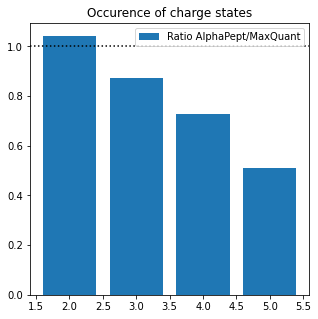

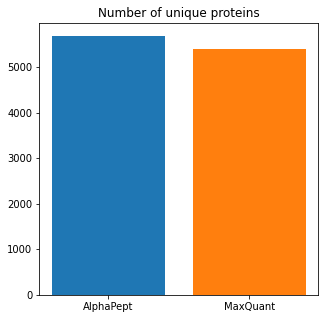

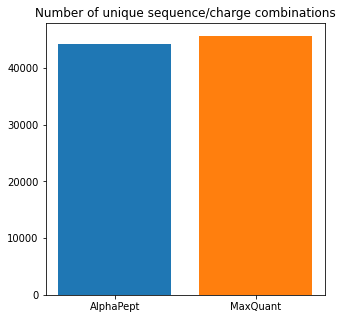

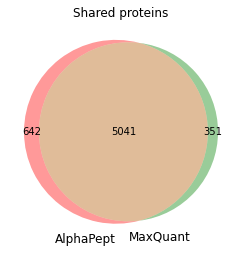

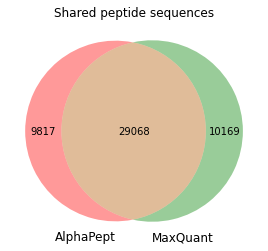

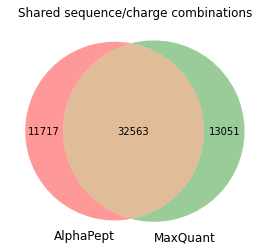

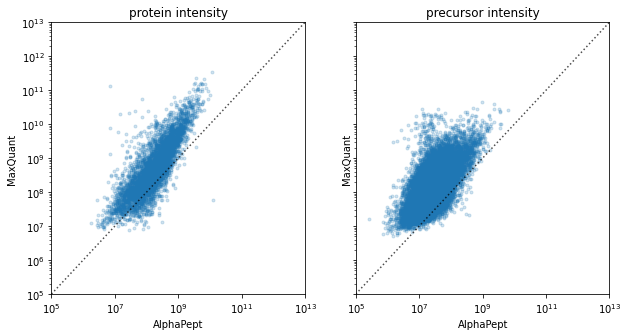

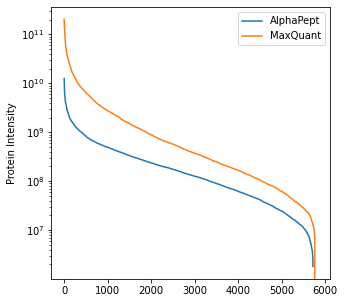

In [4]:
from test_helper import prepare_files, compare_field, compare_populations, compare_intensities, protein_rank

df1, df2 = prepare_files('E:/test_temp/results.hdf', os.path.join(tmp_folder,'thermo_HeLa_evd.txt'))
for field in ['charge','protein','precursor']:
    compare_field(df1, df2, software_1, software_2, field)
    
for field in ['protein','sequence','precursor']:
    compare_populations(df1, df2, software_1, software_2, field)
    
compare_intensities(df1, df2,software_1, software_2)

protein_rank(df1, df2,software_1, software_2)

### Calling custom steps of the pipeline

Work with already processed results and call individual steps

--- ML ---
2021-05-26 00:50:15> 53,151 target (5,315 decoy) of 63826 PSMs. fdr 0.099998 for a cutoff of 19.77 (set fdr was 0.1)
2021-05-26 00:50:15> Training & cross-validation on 45222 targets and 45221 decoys
2021-05-26 01:00:26> The best parameters selected by 5-fold cross-validation were {'clf__max_depth': 25, 'clf__max_leaf_nodes': 250}
2021-05-26 01:00:27> The train accuracy was 0.9182468516081952
2021-05-26 01:00:27> Testing on 11305 targets and 11306 decoys
2021-05-26 01:00:27> The test accuracy was 0.911414798107116
2021-05-26 01:00:27> Top features {'y_hits': 0.26360134911308003, 'x_tandem': 0.19844062658834294, 'hits': 0.15621663891754764, 'matched_ion_fraction': 0.07559960288760224, 'matched_int_ratio': 0.04541761300810536, 'n_ions': 0.044376295112431345, 'n_missed': 0.033474718640285055, 'matched_int': 0.03029805906643819, 'b_hits': 0.02432804929841368, 'mz': 0.018050891092582056, 'o_mass_ppm': 0.01122898865166004, 'o_mass': 0.0102624988506544, 'o_mass_ppm_raw': 0.00983474

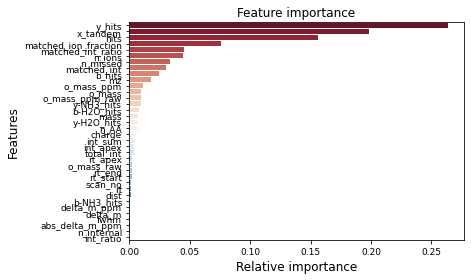

2021-05-26 01:00:27> Filter df with x_tandem score
2021-05-26 01:00:30> Global FDR on precursor
2021-05-26 01:00:30> 44,950 target (449 decoy) of 62214 PSMs. fdr 0.009989 for a cutoff of 0.69 (set fdr was 0.01)


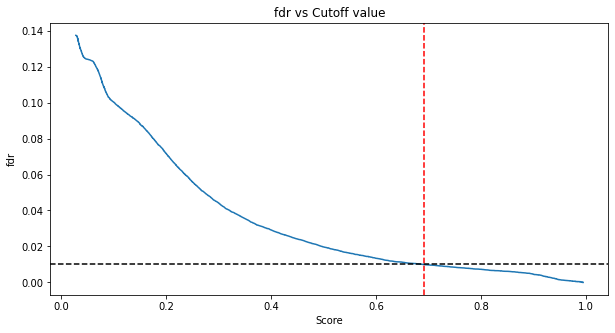

C:\Users\admin\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\admin\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


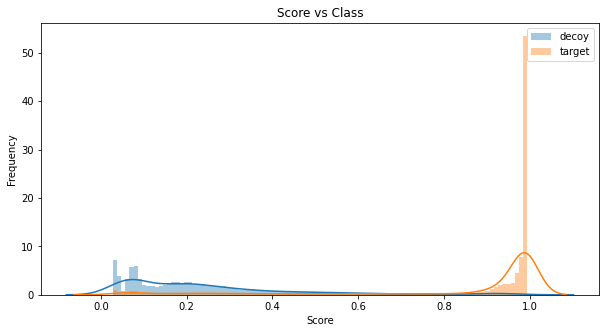

--- x! ---
2021-05-26 01:00:31> Filter df with x_tandem score
2021-05-26 01:00:31> Global FDR on precursor
2021-05-26 01:00:32> Last q_value 0.010 of dataset is smaller than fdr_level 0.010
2021-05-26 01:00:32> 44,950 target (449 decoy) of 45399 PSMs. fdr 0.009989 for a cutoff of 18.72 (set fdr was 0.01)


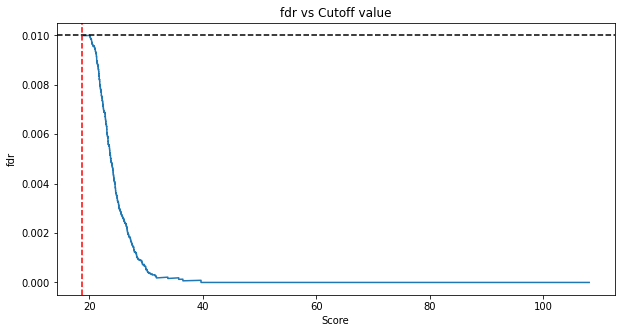

C:\Users\admin\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\admin\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


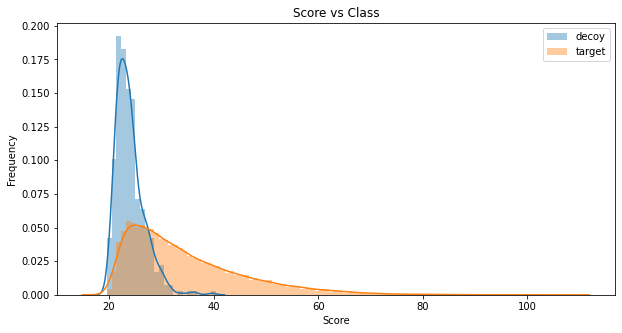

In [5]:
import alphapept.io
from alphapept.score import get_ML_features, filter_with_ML, filter_with_x_tandem, cut_global_fdr, train_RF

ms_file = alphapept.io.MS_Data_File('E:/test_temp/thermo_HeLa.ms_data.hdf')

df = ms_file.read(dataset_name='second_search')
df = get_ML_features(df)

print('--- ML ---')
cv, features = train_RF(df, plot=True)
df = filter_with_ML(df, cv, features = features)
df = cut_global_fdr(df, analyte_level='precursor',  plot=True)

print('--- x! ---')
df = filter_with_x_tandem(df)
df = cut_global_fdr(df, analyte_level='precursor',  plot=True)

### Bruker HeLa

In [6]:
%run -i ../test_ci.py bruker_hela

['../test_ci.py', 'bruker_hela'] 2
2021-05-26 01:00:34> Creating dir E:/test_temp/.
2021-05-26 01:01:44> Logging to C:\Users\admin\alphapept\logs\log_20210526010144.txt.
2021-05-26 01:01:44> Platform information:
2021-05-26 01:01:44> system     - Windows
2021-05-26 01:01:44> release    - 10
2021-05-26 01:01:44> version    - 10.0.18362
2021-05-26 01:01:44> machine    - AMD64
2021-05-26 01:01:44> processor  - Intel64 Family 6 Model 85 Stepping 4, GenuineIntel
2021-05-26 01:01:44> cpu count  - 24
2021-05-26 01:01:44> ram memory - 101.6/127.7 Gb (available/total)
2021-05-26 01:01:44> 
2021-05-26 01:01:44> Python information:
2021-05-26 01:01:44> SQLAlchemy     - 1.3.22
2021-05-26 01:01:44> alphapept      - 0.3.23
2021-05-26 01:01:44> biopython      - 1.78
2021-05-26 01:01:44> click          - 7.1.2
2021-05-26 01:01:44> comtypes       - 1.1.7
2021-05-26 01:01:44> fastcore       - 1.3.5
2021-05-26 01:01:44> h5py           - 3.2.1
2021-05-26 01:01:44> lxml           - 4.6.2
2021-05-26 01:01:4



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 01:01:45> FASTA contains 36,789 entries.




  3%|█▋                                                              | 0.02702702702702703/1 [01:26<51:47, 3193.45s/it]

  5%|███▍                                                            | 0.05405405405405406/1 [01:28<21:19, 1352.63s/it]

  8%|█████▎                                                           | 0.08108108108108109/1 [01:29<11:43, 765.98s/it]

  0%|                                                                                            | 0/1 [13:22<?, ?it/s]


 14%|████████▊                                                        | 0.13513513513513514/1 [01:33<04:53, 339.28s/it]

 16%|██████████▌                                                      | 0.16216216216216217/1 [01:34<03:22, 241.22s/it]

 19%|████████████▍                                                     | 0.1891891891891892/1 [01:37<02:32, 188.14s/it]

 22%|██████████████                                                   | 0.21621621621621623/1 [01:38<01:52, 143.10s/it]

 24%|███████████████▊        

2021-05-26 01:04:25> Digested 36,789 proteins and generated 9,107,982 spectra
2021-05-26 01:06:17> Database saved to E:\test_temp\database.hdf. Filesize of database is 3.42 GB


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 01:06:33> Processing 1 files for step raw_conversion
2021-05-26 01:06:33> File E:/test_temp/bruker_HeLa has extension .d - converting from Bruker.


100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [04:49<00:00, 289.49s/it]


2021-05-26 01:36:03> File conversion complete. Extracted 299,728 precursors.
2021-05-26 01:36:12> File conversion of file E:/test_temp/bruker_HeLa.d complete.



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 01:36:12> Processing 1 files for step find_features
2021-05-26 01:36:12> No *.hdf file with features found for E:/test_temp/bruker_HeLa.ms_data.hdf. Adding to feature finding list.
2021-05-26 01:36:12> Feature finding on E:/test_temp/bruker_HeLa.d
2021-05-26 01:36:12> Using Windows FF
2021-05-26 01:36:14> TopLevelUffWorkflow: Initializing 4d Feature Finder Workflow for lc-timstof data
2021-05-26 01:36:14> bdal.uff.TopLevelUffWorkflow: This is Universal Feature Finder 3.13.1.0
2021-05-26 01:36:14> 
2021-05-26 01:36:14> bdal.uff.cmdline: Parameters for ParameterSet path '':
2021-05-26 01:36:14> 
2021-05-26 01:36:14>  directory containing the data to be processed." , "required":true , "hidden":false , "type":"class std::basic_string<char,struct std::char_traits<char>,class std::allocator<char> >" , "constraint":null , "value":"E:/test_temp/bruker_HeLa.d"}
2021-05-26 01:36:14> 
2021-05-26 01:36:14> nable lcms denoising. Will only denoise if the data has not been denoised already

2021-05-26 01:36:15> 
2021-05-26 01:36:15>  non-deconvoluted peaks are filled up." , "required":false , "hidden":true , "type":"class std::basic_string<char,struct std::char_traits<char>,class std::allocator<char> >" , "constraint":"[topN,threshold] (class std::basic_string<char,struct std::char_traits<char>,class std::allocator<char> >)" , "value":"topN"}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> , all raw peaks are written. Otherwise, only deisotoped peaks are written" , "required":false , "hidden":false , "type":"bool" , "constraint":null , "value":false}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> ':
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> :
2021-05-26 01:36:15> 
2021-05-26 01:36:15> c":"intensity threshold for matching calibrant peaks" , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":0}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> able lock mass calibration" , "required":false , "hidden":false , "type":"bool" , "constraint"

2021-05-26 01:36:15> 
2021-05-26 01:36:15> :"end (RT) of the calibration segment" , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":1e+22}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> c":"begin (RT) of the calibration segment" , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":0}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> mum intensity of a calibrant" , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":1e+22}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> lag indicating which algorithm to use: false = use calibration-segment, true = do not use calibration-segment, default = false" , "required":false , "hidden":false , "type":"bool" , "constraint":null , "value":false}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> sc":"vector of vector with lower rt boundaries for the reference peaks for segment-free calibration only" , "required":false , "hidden":false , "type":"class std::vector<class std::vector

2021-05-26 01:36:15>  "desc":"Lower RT value for range to look for mobility calibrants" , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":0}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> .Calibration.ReadTimsCalibrants':
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> Ms.Calibration.WriteCalibration':
2021-05-26 01:36:15> 
2021-05-26 01:36:15> "vector of CCS values of reference peaks for mobility calibration" , "required":false , "hidden":false , "type":"class std::vector<double,class std::allocator<double> >" , "constraint":null , "value":[]}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> .Calibration.WriteCalibration':
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> Ms.ClusterDeisotoping':
2021-05-26 01:36:15> 
2021-05-26 01:36:15> ":"Ions must have at least this absolute abundance to be used as seed cluster for a component. Default 0.0" , "required":false , "hidden":false , "type":"double" , "constraint":"in [0,1.79769e+30

2021-05-26 01:36:15> 
2021-05-26 01:36:15> raction of isotope pattern which must be covered (starting from the largest peaks)" , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":0.95}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> l molecules: path to file with table: 6 x M/Z and 6 isotope intensities" , "required":false , "hidden":false , "type":"class std::basic_string<char,struct std::char_traits<char>,class std::allocator<char> >" , "constraint":null , "value":"isotopePatterns3.txt"}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> e threshold for incorporation of non-essential isotopes into feature. if <= 0, not used (abs. threshold maxIsotopePatternError used)." , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":-1}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> equired":false , "hidden":false , "type":"double" , "constraint":null , "value":0.2}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> nce to find isotopes (applied to mean MZ 

2021-05-26 01:36:15> equired":false , "hidden":false , "type":"double" , "constraint":null , "value":0}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> quired":false , "hidden":false , "type":"double" , "constraint":null , "value":0}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> " , "required":false , "hidden":false , "type":"bool" , "constraint":null , "value":false}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> quired":false , "hidden":false , "type":"double" , "constraint":null , "value":0}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> rue, all peaks for positions [-1, maxIsotopes-1] (with pos. 0 first isotope of feature) are reported" , "required":false , "hidden":false , "type":"bool" , "constraint":null , "value":false}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> fraction of the maximum intensity is considered as not saturated (for bigger intensities we don't know)" , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":0.8}
2021-05-26 01:36:15> 
2021-05-26 01:36:15

2021-05-26 01:36:15> 
2021-05-26 01:36:15> quired":false , "hidden":false , "type":"double" , "constraint":null , "value":0.03}
2021-05-26 01:36:15> 
2021-05-26 01:36:15>  , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":2}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> ed":false , "hidden":false , "type":"double" , "constraint":null , "value":0.014}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> d":false , "hidden":false , "type":"double" , "constraint":null , "value":0.01}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> d":false , "hidden":false , "type":"double" , "constraint":null , "value":4}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> " , "required":false , "hidden":false , "type":"double" , "constraint":null , "value":1}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> equired":false , "hidden":false , "type":"double" , "constraint":null , "value":3.5}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> ":false , "hidden":false , "type":"double" , "constraint":null , "valu

2021-05-26 01:36:15> 
2021-05-26 01:36:15>  sqlite result file '<shortFilename>.features'" , "required":false , "hidden":false , "type":"bool" , "constraint":null , "value":true}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> aw peaks for each cluster are written" , "required":false , "hidden":true , "type":"bool" , "constraint":null , "value":false}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> .IsotopeClustersOutput':
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> Ms.PrecursorInfoSource':
2021-05-26 01:36:15> 
2021-05-26 01:36:15> value for read range" , "required":false , "hidden":true , "type":"double" , "constraint":null , "value":1e+22}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> value for read range" , "required":false , "hidden":true , "type":"double" , "constraint":null , "value":0}
2021-05-26 01:36:15> 
2021-05-26 01:36:15> .PrecursorInfoSource':
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> Ms.ReadTimsData':
2021-05-26 01:36:15> 
2021-05-26 01:36

2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 00000
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 0000
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 00
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 0000.000000
2021-05-26 01:36:15> 
2021-05-26 01:36:15> e
2021-05-26 01:36:15> th.enableRecalibration=true
2021

2021-05-26 01:36:15> false
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 10
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> alse
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> ing=20
2021-05-26 01:36:15> 00000
2021-05-26 01:36:15> or=2.000000
2021-05-26 01:36:15> 300000
2021-05-26 01:36:15> 0
2021-05-26 01:36:15> 50000
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> .000000
2021-05-26 01:36:15> 
2021-05-26 01:36:15> 
2021-05-26 01:36:15> ters=<unprintable type>
2021-05-26 01:36:15> ue
2021-05-26 01:36:15> eaks=false
2021-05-26 01:36:15> nds=10000000000000000000000.000000
2021-05-26 01:36:15> nds=0.000000
2021-05-26 01:36:15> meNrTolerance=2
2021-05-26 01:36:15> imalFrequency=20
2021-05-26 01:36:15> nNrTolerance=20
2021-05-26 01:36:15> lerance=3
2021-05-26 01:36:15> eClustering"
2021-05-26 01:36:15> ue
2021-0

2021-05-26 01:59:49> bdal.algorithm.LcmsClusterDeisotoping: 2052951 clusters after splitting (if active).
2021-05-26 01:59:49> bdal.algorithm.LcmsClusterDeisotoping:  min/max apex intensity: 34.7222/1.31159e+06
2021-05-26 01:59:58> bdal.algorithm.PerioTab.InitPerioTabStream: User-defined periodic table extension is empty or file could not be opened. Proceeding with standard elements.
2021-05-26 01:59:58> bdal.algorithm.LcmsClusterDeisotoping: correlation threshold: 10623.9
2021-05-26 01:59:58> bdal.algorithm.LcmsClusterDeisotoping: Progress: 0% (1/2052951)
2021-05-26 01:59:59> bdal.algorithm.LcmsClusterDeisotoping: Progress: 0.487104% (10001/2052951)
2021-05-26 02:00:01> bdal.algorithm.LcmsClusterDeisotoping: Progress: 0.974207% (20001/2052951)
2021-05-26 02:00:02> bdal.algorithm.LcmsClusterDeisotoping: Progress: 1.46131% (30001/2052951)
2021-05-26 02:00:03> bdal.algorithm.LcmsClusterDeisotoping: Progress: 1.94841% (40001/2052951)
2021-05-26 02:00:04> bdal.algorithm.LcmsClusterDeisotop

2021-05-26 02:01:25> bdal.algorithm.LcmsClusterDeisotoping: Progress: 39.4554% (810001/2052951)
2021-05-26 02:01:26> bdal.algorithm.LcmsClusterDeisotoping: Progress: 39.9425% (820001/2052951)
2021-05-26 02:01:27> bdal.algorithm.LcmsClusterDeisotoping: Progress: 40.4296% (830001/2052951)
2021-05-26 02:01:28> bdal.algorithm.LcmsClusterDeisotoping: Progress: 40.9167% (840001/2052951)
2021-05-26 02:01:29> bdal.algorithm.LcmsClusterDeisotoping: Progress: 41.4038% (850001/2052951)
2021-05-26 02:01:29> bdal.algorithm.LcmsClusterDeisotoping: Progress: 41.8909% (860001/2052951)
2021-05-26 02:01:30> bdal.algorithm.LcmsClusterDeisotoping: Progress: 42.378% (870001/2052951)
2021-05-26 02:01:31> bdal.algorithm.LcmsClusterDeisotoping: Progress: 42.8651% (880001/2052951)
2021-05-26 02:01:32> bdal.algorithm.LcmsClusterDeisotoping: Progress: 43.3522% (890001/2052951)
2021-05-26 02:01:33> bdal.algorithm.LcmsClusterDeisotoping: Progress: 43.8393% (900001/2052951)
2021-05-26 02:01:34> bdal.algorithm.LcmsC

2021-05-26 02:02:30> bdal.algorithm.LcmsClusterDeisotoping: Progress: 80.8592% (1660001/2052951)
2021-05-26 02:02:30> bdal.algorithm.LcmsClusterDeisotoping: Progress: 81.3463% (1670001/2052951)
2021-05-26 02:02:31> bdal.algorithm.LcmsClusterDeisotoping: Progress: 81.8334% (1680001/2052951)
2021-05-26 02:02:32> bdal.algorithm.LcmsClusterDeisotoping: Progress: 82.3205% (1690001/2052951)
2021-05-26 02:02:32> bdal.algorithm.LcmsClusterDeisotoping: Progress: 82.8076% (1700001/2052951)
2021-05-26 02:02:33> bdal.algorithm.LcmsClusterDeisotoping: Progress: 83.2947% (1710001/2052951)
2021-05-26 02:02:34> bdal.algorithm.LcmsClusterDeisotoping: Progress: 83.7818% (1720001/2052951)
2021-05-26 02:02:34> bdal.algorithm.LcmsClusterDeisotoping: Progress: 84.2689% (1730001/2052951)
2021-05-26 02:02:35> bdal.algorithm.LcmsClusterDeisotoping: Progress: 84.756% (1740001/2052951)
2021-05-26 02:02:35> bdal.algorithm.LcmsClusterDeisotoping: Progress: 85.2431% (1750001/2052951)
2021-05-26 02:02:36> bdal.algor

  0%|                                                                                          | 0/1 [1:37:28<?, ?it/s]


2021-05-26 02:44:02> Bruker featurer finder complete. Extracted 261,932 features.
2021-05-26 02:44:02> Matching features to query data.
2021-05-26 02:44:09> Saving feature table.
2021-05-26 02:44:16> Feature table saved to E:/test_temp/bruker_HeLa.ms_data.hdf
2021-05-26 02:44:16> Saving features.
2021-05-26 02:44:16> Feature finding of file E:/test_temp/bruker_HeLa.d complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 02:44:16> Starting first search.
2021-05-26 02:44:16> Processing 1 files for step search_db
2021-05-26 02:44:17> Calibrating fragments


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\admin\.conda\envs\alphapept\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2021-05-26 02:44:48> Performing search on 348,181 query and 9,107,982 db entries with m_tol = 30.00 and m_offset = 30.00.
2021-05-26 02:46:00> Compared 385,244,800 spectra and found 650,168 psms.
2021-05-26 02:46:01> Extracting columns for scoring.


  0%|                                                                                          | 0/1 [1:09:52<?, ?it/s]


2021-05-26 02:47:42> Extracted columns from 650,168 spectra.
2021-05-26 02:47:43> Saving first_search results to E:/test_temp/bruker_HeLa.ms_data.hdf
2021-05-26 02:47:49> Search of file E:/test_temp/bruker_HeLa.d complete.
2021-05-26 02:48:21> First search complete.



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 02:48:21> Processing 1 files for step calibrate_hdf
2021-05-26 02:48:22> Scoring using X-Tandem
2021-05-26 02:48:24> 68,852 target (688 decoy) of 100706 PSMs. fdr 0.009992 for a cutoff of 17.20 (set fdr was 0.01)
2021-05-26 02:48:29> Calibration of file E:/test_temp/bruker_HeLa.ms_data.hdf complete.
2021-05-26 02:48:29> Calibrating fragments
2021-05-26 02:48:30> Median fragment offset -5.17 - std 14.92 ppm




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 02:48:33> Starting second search with DB.
2021-05-26 02:48:33> Processing 1 files for step search_db
2021-05-26 02:48:33> Found calibrated m_offset with value 8.54
2021-05-26 02:48:36> Performing search on 348,181 query and 9,107,982 db entries with m_tol = 30.00 and m_offset = 8.54.
2021-05-26 02:49:02> Compared 129,572,968 spectra and found 342,438 psms.
2021-05-26 02:49:02> Extracting columns for scoring.


  0%|                                                                                            | 0/1 [00:55<?, ?it/s]


2021-05-26 02:49:50> Extracted columns from 342,438 spectra.
2021-05-26 02:49:50> Saving second_search results to E:/test_temp/bruker_HeLa.ms_data.hdf
2021-05-26 02:49:53> Search of file E:/test_temp/bruker_HeLa.d complete.
2021-05-26 02:50:22> Second search complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 02:50:23> Processing 1 files for step score_hdf
2021-05-26 02:50:24> Found second search psms for scoring.
2021-05-26 02:50:30> Last q_value 0.079 of dataset is smaller than fdr_level 0.100
2021-05-26 02:50:30> 87,263 target (6,911 decoy) of 94174 PSMs. fdr 0.079197 for a cutoff of 10.72 (set fdr was 0.1)
2021-05-26 02:50:31> Training & cross-validation on 72059 targets and 72059 decoys
2021-05-26 03:08:05> The best parameters selected by 5-fold cross-validation were {'clf__max_depth': 25, 'clf__max_leaf_nodes': 250}
2021-05-26 03:08:06> The train accuracy was 0.936926685077506
2021-05-26 03:08:06> Testing on 18015 targets and 18015 decoys
2021-05-26 03:08:07> The test accuracy was 0.9319178462392451
2021-05-26 03:08:07> Top features {'y_hits': 0.2343669096601591, 'hits': 0.19588496076899234, 'x_tandem': 0.14184441963532066, 'total_int': 0.07315173407399725, 'matched_int_ratio': 0.05905374947876514, 'matched_ion_fraction': 0.055878293872721974, 'n_ions': 0.0372788889844017, 


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 03:08:37> Fasta dict with length 36,789, Pept dict with length 9,107,988
2021-05-26 03:08:37> Extracting protein groups.





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 03:08:38> A total of 60,458 unique and 3,392 shared peptides.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


2021-05-26 03:08:40> A total of 903 ambigious proteins
2021-05-26 03:08:40> A total of 706 unique and 42 shared peptides.
2021-05-26 03:08:40> A total of 41 ambigious proteins
2021-05-26 03:08:40> Global FDR on protein
2021-05-26 03:08:40> 6,790 target (67 decoy) of 8261 PSMs. fdr 0.009867 for a cutoff of 0.85 (set fdr was 0.01)
2021-05-26 03:08:41> FDR on proteins complete. For 0.01 FDR found 74,724 targets and 72 decoys. A total of 6,835 proteins found.
2021-05-26 03:08:44> Saving complete.
2021-05-26 03:08:44> Protein groups complete.


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\pandas\core\generic.py:2605: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block5_values] [items->Index(['ion_int', 'ion_types', 'naked_sequence', 'precursor', 'sequence',
       'filename', 'shortname', 'protein', 'protein_group', 'razor'],
      dtype='object')]

  pytables.to_hdf(


2021-05-26 03:08:45> Complete. 
2021-05-26 03:08:45> Starting profile extraction.



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.25it/s]

2021-05-26 03:08:45> LFQ complete.
2021-05-26 03:08:45> Exporting as csv.
2021-05-26 03:08:48> Saved df of length 74,796 saved to E:\test_temp\results


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.00s/it]


2021-05-26 03:08:51> Settings saved to E:\test_temp\results.yaml
2021-05-26 03:08:51> Analysis complete.


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


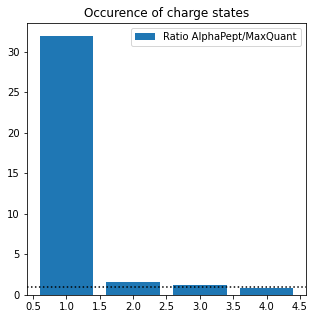

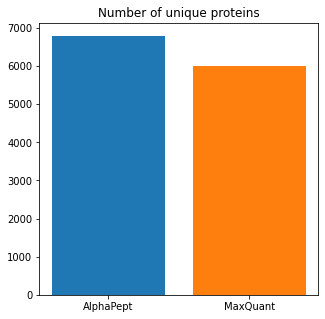

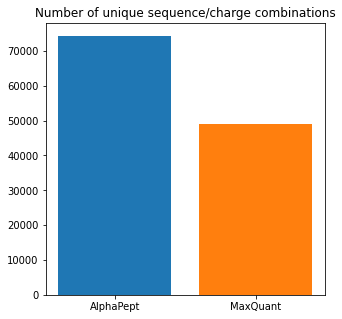

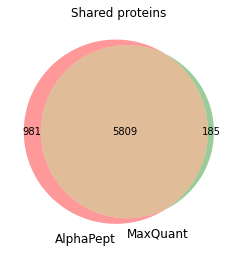

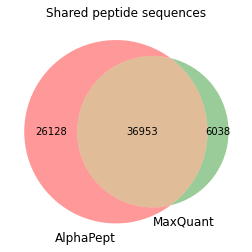

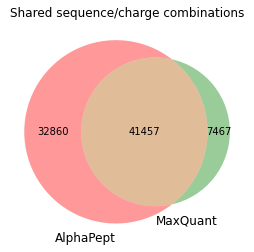

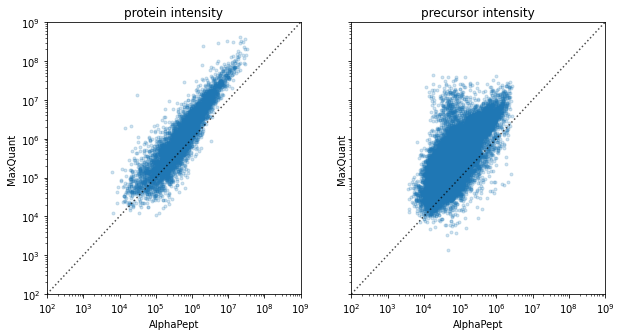

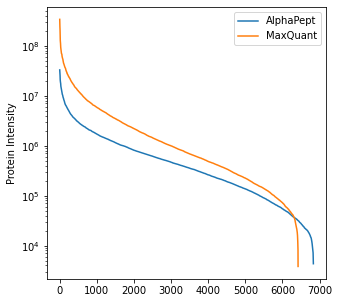

In [7]:
from test_helper import prepare_files, compare_field, compare_populations, compare_intensities, protein_rank

df1, df2 = prepare_files('E:/test_temp/results.hdf', os.path.join(tmp_folder,'bruker_HeLa_evd.txt'))
for field in ['charge','protein','precursor']:
    compare_field(df1, df2, software_1, software_2, field)
    
for field in ['protein','sequence','precursor']:
    compare_populations(df1, df2, software_1, software_2, field)
    
compare_intensities(df1, df2,software_1, software_2)

protein_rank(df1, df2,software_1, software_2)

# Quantification Test

This notebook will run `PXD006109` and `PXD010012` and compare the quantificaiton performance.

## PXD006109

In [8]:
%run -i ../test_ci.py PXD006109

['../test_ci.py', 'PXD006109'] 2
2021-05-26 03:08:57> Creating dir E:/test_temp/.
2021-05-26 03:09:01> Logging to C:\Users\admin\alphapept\logs\log_20210526030901.txt.
2021-05-26 03:09:01> Platform information:
2021-05-26 03:09:01> system     - Windows
2021-05-26 03:09:01> release    - 10
2021-05-26 03:09:01> version    - 10.0.18362
2021-05-26 03:09:01> machine    - AMD64
2021-05-26 03:09:01> processor  - Intel64 Family 6 Model 85 Stepping 4, GenuineIntel
2021-05-26 03:09:01> cpu count  - 24
2021-05-26 03:09:01> ram memory - 95.1/127.7 Gb (available/total)
2021-05-26 03:09:01> 
2021-05-26 03:09:02> Python information:
2021-05-26 03:09:02> SQLAlchemy     - 1.3.22
2021-05-26 03:09:02> alphapept      - 0.3.23
2021-05-26 03:09:02> biopython      - 1.78
2021-05-26 03:09:02> click          - 7.1.2
2021-05-26 03:09:02> comtypes       - 1.1.7
2021-05-26 03:09:02> fastcore       - 1.3.5
2021-05-26 03:09:02> h5py           - 3.2.1
2021-05-26 03:09:02> lxml           - 4.6.2
2021-05-26 03:09:02> 


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 03:09:03> FASTA contains 43,752 entries.



  2%|█▍                                                             | 0.022727272727272728/1 [01:02<44:32, 2734.40s/it]
  5%|██▊                                                            | 0.045454545454545456/1 [01:02<18:07, 1139.61s/it]
  7%|████▍                                                            | 0.06818181818181818/1 [01:04<10:03, 647.98s/it]
  9%|█████▉                                                           | 0.09090909090909091/1 [01:14<08:48, 581.32s/it]
 11%|███████▍                                                         | 0.11363636363636363/1 [01:31<09:14, 626.02s/it]
 14%|████████▊                                                        | 0.13636363636363635/1 [01:32<06:19, 439.51s/it]
 16%|██████████▌                                                       | 0.1590909090909091/1 [01:34<04:28, 319.69s/it]
  0%|                                                                                            | 0/1 [02:02<?, ?it/s]

 20%|█████████████▎                   

2021-05-26 03:11:27> Digested 43,752 proteins and generated 6,163,992 spectra
2021-05-26 03:12:43> Database saved to E:\test_temp\database.hdf. Filesize of database is 2.33 GB


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 03:12:53> Processing 6 files for step raw_conversion
AlphaPool was set to 24 processes. Setting max to 24.


 67%|████████████████████████████████████████████                      | 0.6666666666666666/1 [01:36<00:36, 109.61s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 03:14:30> Processing 6 files for step find_features
2021-05-26 03:14:30> Setting Process limit to 12
AlphaPool was set to 12 processes. Setting max to 12.




 17%|██████████▋                                                     | 0.16666666666666666/1 [06:28<32:24, 2333.95s/it]

 50%|████████████████████████████████████████▌                                        | 0.5/1 [06:31<05:05, 610.91s/it]

 83%|███████████████████████████████████████████████████████           | 0.8333333333333334/1 [06:35<00:50, 302.17s/it]

100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [06:36<00:00, 223.84s/it]


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 03:21:07> Starting first search.
2021-05-26 03:21:07> Processing 6 files for step search_db
2021-05-26 03:21:07> Searching. Setting Process limit to 17.
AlphaPool was set to 17 processes. Setting max to 17.





 17%|██████████▊                                                      | 0.16666666666666666/1 [01:23<06:59, 502.96s/it]


100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [09:50<00:00, 590.39s/it]
100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [08:13<00:00, 493.75s/it]
100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [13:48<00:00, 828.96s/it]


2021-05-26 03:23:00> First search complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 03:23:00> Processing 6 files for step calibrate_hdf
AlphaPool was set to 24 processes. Setting max to 24.


 67%|████████████████████████████████████████████▋                      | 0.6666666666666666/1 [00:14<00:05, 16.35s/it]
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 03:23:14> Starting second search with DB.
2021-05-26 03:23:14> Processing 6 files for step search_db
2021-05-26 03:23:14> Searching. Setting Process limit to 16.
AlphaPool was set to 16 processes. Setting max to 16.



 17%|██████████▊                                                      | 0.16666666666666666/1 [00:35<02:55, 211.18s/it]
100%|██████████████████████████████████████████████████████████████████████████████████| 1.0/1 [00:55<00:00, 55.02s/it]
100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [02:50<00:00, 170.69s/it]


2021-05-26 03:24:11> Second search complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 03:24:12> Processing 6 files for step score_hdf
AlphaPool was set to 24 processes. Setting max to 24.


100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [02:33<00:00, 153.15s/it]


2021-05-26 03:26:54> Total deviation before calibration {'mz': 3.896350352629293e-06, 'rt': 7.731371520202037}
2021-05-26 03:26:54> Mean deviation before calibration {'mz': 2.597566901752862e-07, 'rt': 0.5154247680134691}
2021-05-26 03:26:54> Solving equation system
2021-05-26 03:26:54> Regression score is 0.9997291799241506
2021-05-26 03:26:54> Solving equation system complete.
2021-05-26 03:26:54> Applying offset
2021-05-26 03:26:54> Saving E:/test_temp/PXD006109_HeLa12_1.ms_data.hdf - peptide_fdr.
2021-05-26 03:26:54> Saving E:/test_temp/PXD006109_HeLa12_1.ms_data.hdf - feature_table.
2021-05-26 03:26:55> Saving E:/test_temp/PXD006109_HeLa12_2.ms_data.hdf - peptide_fdr.
2021-05-26 03:26:55> Saving E:/test_temp/PXD006109_HeLa12_2.ms_data.hdf - feature_table.
2021-05-26 03:26:55> Saving E:/test_temp/PXD006109_HeLa12_3.ms_data.hdf - peptide_fdr.
2021-05-26 03:26:55> Saving E:/test_temp/PXD006109_HeLa12_3.ms_data.hdf - feature_table.
2021-05-26 03:26:56> Saving E:/test_temp/PXD006109_He

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 03:27:07> Fasta dict with length 43,752, Pept dict with length 6,163,998
2021-05-26 03:27:07> Extracting protein groups.




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


2021-05-26 03:27:09> A total of 49,413 unique and 10,253 shared peptides.
2021-05-26 03:27:13> A total of 1876 ambigious proteins
2021-05-26 03:27:14> A total of 1,088 unique and 148 shared peptides.
2021-05-26 03:27:14> A total of 145 ambigious proteins
2021-05-26 03:27:15> Global FDR on protein
2021-05-26 03:27:15> 6,742 target (67 decoy) of 9300 PSMs. fdr 0.009938 for a cutoff of 0.83 (set fdr was 0.01)
2021-05-26 03:27:17> FDR on proteins complete. For 0.01 FDR found 190,203 targets and 195 decoys. A total of 6,783 proteins found.
2021-05-26 03:27:25> Saving complete.


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\pandas\core\generic.py:2605: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block5_values] [items->Index(['ion_int', 'ion_types', 'naked_sequence', 'precursor', 'sequence',
       'filename', 'shortname', 'protein', 'protein_group', 'razor'],
      dtype='object')]

  pytables.to_hdf(


2021-05-26 03:27:25> Protein groups complete.
2021-05-26 03:27:27> Complete. 
2021-05-26 03:27:27> Starting profile extraction.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 03:27:27> Preparing protein table for parallel processing.


 20%|█████████████                                                     | 0.19849624060150375/1 [00:04<00:17, 21.94s/it]

2021-05-26 03:27:32> Starting protein extraction for 6783 proteins.
AlphaPool was set to 24 processes. Setting max to 24.


100%|█████████████████████████████████████████████████████████████████▉| 0.9994102904319622/1 [02:35<00:00, 164.66s/it]

2021-05-26 03:30:09> LFQ complete.
2021-05-26 03:30:09> Exporting as csv.
2021-05-26 03:30:16> Saved df of length 190,398 saved to E:\test_temp\results
2021-05-26 03:30:20> Settings saved to E:\test_temp\results.yaml
2021-05-26 03:30:20> Analysis complete.


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (120,121) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


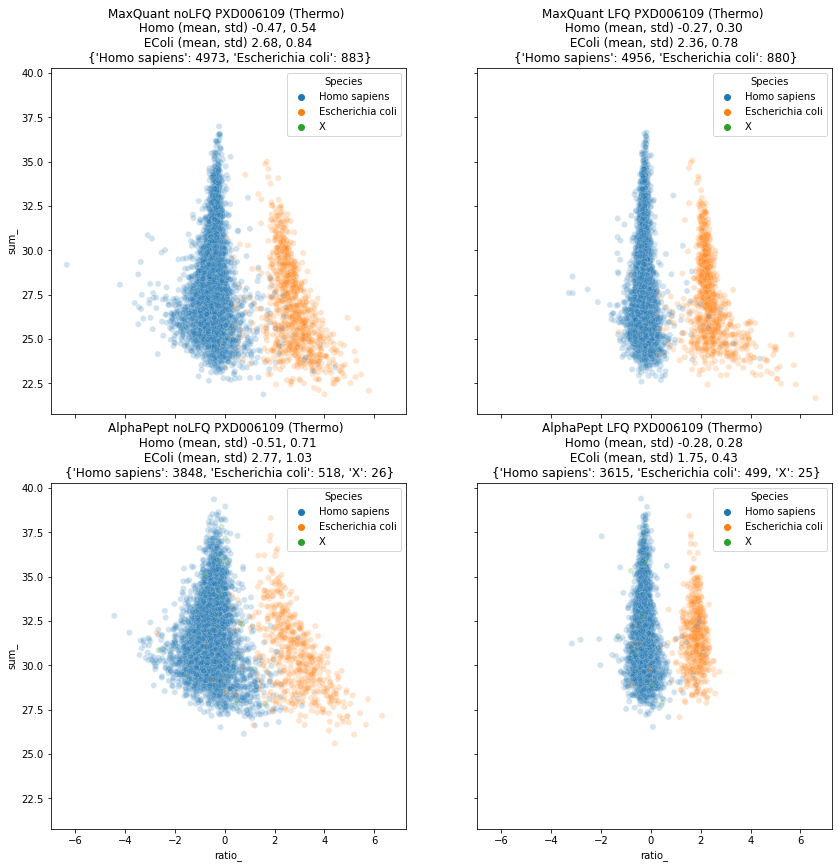

In [9]:
from test_helper import get_plot_df
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14,14), sharex=True,sharey=True)

ref = pd.read_csv(os.path.join(tmp_folder,'PXD006109_ref.txt'), sep='\t') 
no_rev_cont = [(x[0]!="+") & (x[1] !="+") for x in ref[["Reverse","Potential contaminant"]].values]
ref = ref[no_rev_cont]
ref['Species'] = ref['Species'].replace(np.nan, "X")

for j, _ in enumerate(['noLFQ','LFQ']):
    if _ == 'LFQ':
        x = 'LFQ i'
    else:
        x = 'I'
        
    base_columns = [f"{x}ntensity Shotgun_02-01_{i}" for i in range(1,4)]
    ratio_columns = [f"{x}ntensity Shotgun_12-01_{i}" for i in range(1,4)]

    id_ = 'MaxQuant ' +_+' PXD006109 (Thermo)'
    get_plot_df(ref, base_columns, ratio_columns, axes[0,j], id_)


path = 'E:/test_temp/results.hdf' #TEST_DIR as set in test_ci.py
ref = pd.read_hdf(path, 'protein_table')

species = []
for _ in ref.index:
    if 'HUMAN' in _:
        species.append('Homo sapiens')
    elif 'ECO' in _:
        species.append('Escherichia coli')
    else:
        species.append('X')
        
ref['Species'] = species

for j, _ in enumerate(['noLFQ','LFQ']):
    if _ == 'LFQ':
        x = '_LFQ'
    else:
        x = ''
        
    base_columns = [f"PXD006109_HeLa2_{i}{x}" for i in range(1,4)]
    ratio_columns = [f"PXD006109_HeLa12_{i}{x}" for i in range(1,4)]

    id_ = 'AlphaPept ' +_+' PXD006109 (Thermo)'
    get_plot_df(ref, base_columns, ratio_columns, axes[1,j], id_)

plt.show()

## CV plot

C:\Users\admin\.conda\envs\alphapept\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (120,121) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-10-958b491455a4>:21: RuntimeWarning: invalid value encountered in true_divide
  cv = np.nanstd(ref[base_columns + ratio_columns], axis=1) / np.nanmean(ref[base_columns + ratio_columns], axis=1)
C:\Users\admin\.conda\envs\alphapept\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-10-958b491455a4>:50: RuntimeWarning: Mean of empty slice
  cv = np.nanstd(ref[base_columns + ratio_columns], axis=1) / np.nanmean(ref[base_columns + ratio_columns], axis=1)


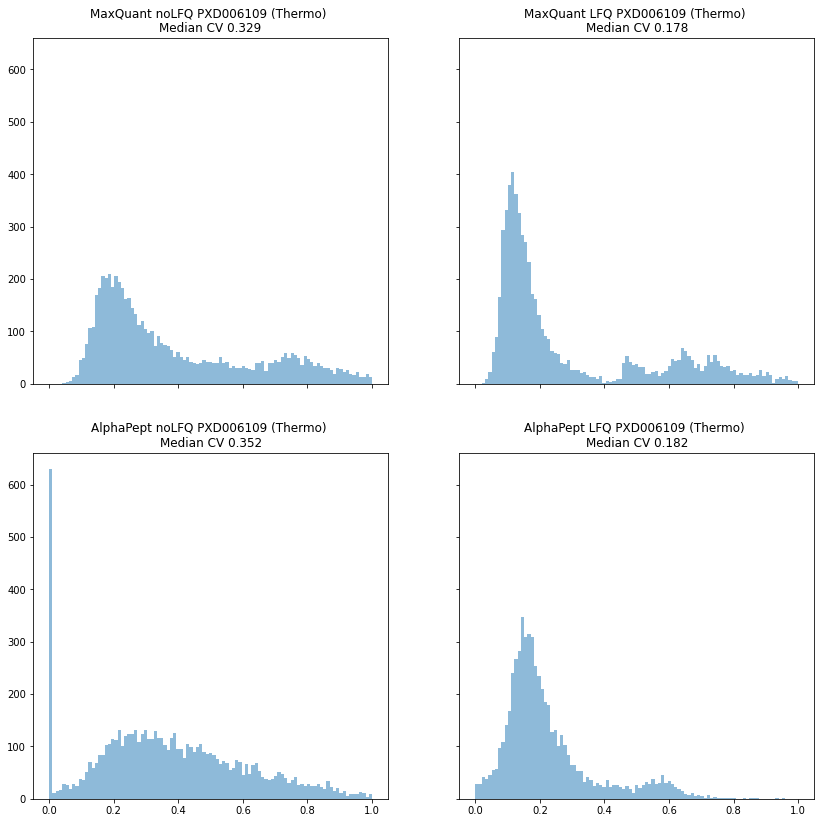

In [10]:
bins = np.linspace(0,1,100)

fig, axes = plt.subplots(2, 2, figsize=(14,14), sharex=True,sharey=True)

ref = pd.read_csv(os.path.join(tmp_folder,'PXD006109_ref.txt'), sep='\t') 
no_rev_cont = [(x[0]!="+") & (x[1] !="+") for x in ref[["Reverse","Potential contaminant"]].values]
ref = ref[no_rev_cont]
ref['Species'] = ref['Species'].replace(np.nan, "X")

for j, _ in enumerate(['noLFQ','LFQ']):
    if _ == 'LFQ':
        x = 'LFQ i'
    else:
        x = 'I'
        
    base_columns = [f"{x}ntensity Shotgun_02-01_{i}" for i in range(1,4)]
    ratio_columns = [f"{x}ntensity Shotgun_12-01_{i}" for i in range(1,4)]

    id_ = 'MaxQuant ' +_+' PXD006109 (Thermo)'
    
    cv = np.nanstd(ref[base_columns + ratio_columns], axis=1) / np.nanmean(ref[base_columns + ratio_columns], axis=1)

    axes[0,j].hist(cv, bins = bins, label = id_, alpha = 0.5)
    axes[0,j].set_title(f'{id_} \nMedian CV {np.nanmedian(cv):.3f}')

path = 'E:/test_temp/results.hdf' #TEST_DIR as set in test_ci.py
ref = pd.read_hdf(path, 'protein_table')

species = []
for _ in ref.index:
    if 'HUMAN' in _:
        species.append('Homo sapiens')
    elif 'ECO' in _:
        species.append('Escherichia coli')
    else:
        species.append('X')
        
ref['Species'] = species

for j, _ in enumerate(['noLFQ','LFQ']):
    if _ == 'LFQ':
        x = '_LFQ'
    else:
        x = ''
        
    base_columns = [f"PXD006109_HeLa2_{i}{x}" for i in range(1,4)]
    ratio_columns = [f"PXD006109_HeLa12_{i}{x}" for i in range(1,4)]

    id_ = 'AlphaPept ' +_+' PXD006109 (Thermo)'
    cv = np.nanstd(ref[base_columns + ratio_columns], axis=1) / np.nanmean(ref[base_columns + ratio_columns], axis=1)

    axes[1,j].hist(cv, bins = bins, label = id_, alpha = 0.5)
    axes[1,j].set_title(f'{id_} \nMedian CV {np.nanmedian(cv):.3f}')

plt.show()

## Algorithm Test

Test performance of LFQ algorithm on MaxQuant evidence file.

In [11]:
try: 
    import ipywidgets
except ModuleNotFoundError:
    !pip install ipywidgets

2021-05-26 03:30:24> Loading files


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (52,53,61) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


2021-05-26 03:30:30> A total of 12 files.


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (120,121) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


2021-05-26 03:30:41> A total of 6,882 proteins.


100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [07:28<00:00, 448.64s/it]
  0%|                                                                                            | 0/1 [03:35<?, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [03:16<00:00, 196.16s/it]


2021-05-26 03:30:53> Preparing protein table for parallel processing.
2021-05-26 03:31:13> Starting protein extraction for 6882 proteins.
AlphaPool was set to 24 processes. Setting max to 24.


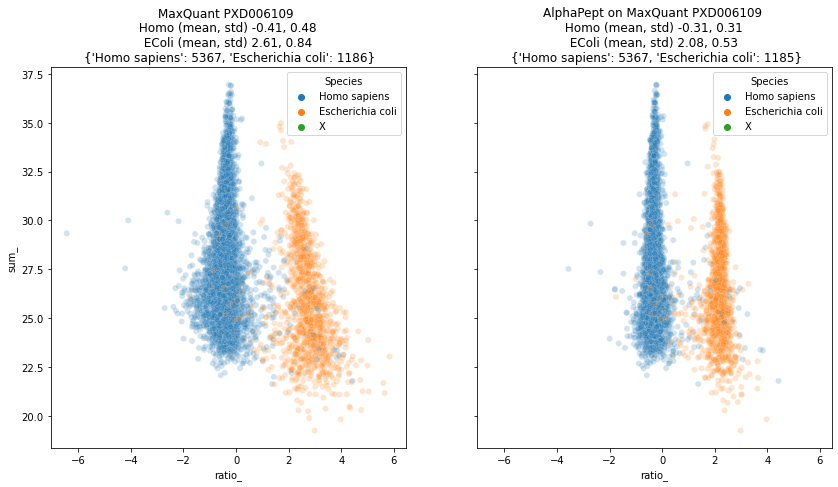

In [12]:
from alphapept.quantification import protein_profile_parallel_mq
from test_helper import get_plot_df


evidence_path = os.path.join(tmp_folder,'PXD006109_ref_evd.txt')
protein_group_path = os.path.join(tmp_folder,'PXD006109_ref.txt')

pt = protein_profile_parallel_mq(evidence_path, protein_group_path)

ref = pd.read_csv(protein_group_path, sep='\t')
species_dict = pd.Series(ref['Species'].values, index=ref['Protein IDs']).to_dict()
pt['Species'] = [species_dict[_] for _ in pt.index]


pre_lfq = [_ for _ in pt.columns if not _.endswith('_LFQ')]
lfq = [_ for _ in pt.columns if _.endswith('_LFQ')]

test_id = 'PXD006109'

fig, axes = plt.subplots(1, 2, figsize=(14,7), sharex=True,sharey=True)

ids = [f'{software_2} {test_id}', f'{software_1} on {software_2} {test_id}']

for i, ds in enumerate([pre_lfq, lfq]):

    base_columns = [_ for _ in ds if 'HeLa2' in _]
    ratio_columns = [_ for _ in ds if 'HeLa12' in _]
    get_plot_df(pt, base_columns, ratio_columns, axes[i], ids[i])

## PXD010012

In [13]:
%run -i ../test_ci.py PXD010012

['../test_ci.py', 'PXD010012'] 2
2021-05-26 03:33:49> Creating dir E:/test_temp/.
2021-05-26 04:03:15> Logging to C:\Users\admin\alphapept\logs\log_20210526040315.txt.
2021-05-26 04:03:15> Platform information:
2021-05-26 04:03:15> system     - Windows
2021-05-26 04:03:15> release    - 10
2021-05-26 04:03:15> version    - 10.0.18362
2021-05-26 04:03:15> machine    - AMD64
2021-05-26 04:03:15> processor  - Intel64 Family 6 Model 85 Stepping 4, GenuineIntel
2021-05-26 04:03:15> cpu count  - 24
2021-05-26 04:03:15> ram memory - 96.8/127.7 Gb (available/total)
2021-05-26 04:03:15> 
2021-05-26 04:03:15> Python information:
2021-05-26 04:03:15> SQLAlchemy     - 1.3.22
2021-05-26 04:03:15> alphapept      - 0.3.23
2021-05-26 04:03:15> biopython      - 1.78
2021-05-26 04:03:15> click          - 7.1.2
2021-05-26 04:03:15> comtypes       - 1.1.7
2021-05-26 04:03:15> fastcore       - 1.3.5
2021-05-26 04:03:15> h5py           - 3.2.1
2021-05-26 04:03:15> lxml           - 4.6.2
2021-05-26 04:03:15> 

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 04:03:17> FASTA contains 43,752 entries.


100%|██████████████████████████████████████████████████████████████████████████████████| 1.0/1 [02:20<00:00, 19.26s/it]

2021-05-26 04:05:52> Digested 43,752 proteins and generated 6,163,992 spectra
2021-05-26 04:07:08> Database saved to E:\test_temp\database.hdf. Filesize of database is 2.33 GB



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 04:07:19> Processing 10 files for step raw_conversion
AlphaPool was set to 24 processes. Setting max to 24.



 10%|███████▎                                                                 | 0.1/1 [3:15:29<29:19:25, 117294.74s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 07:22:48> Processing 10 files for step find_features
2021-05-26 07:22:48> Using Bruker Feature Finder. Setting Process limit to 4.
AlphaPool was set to 4 processes. Setting max to 4.




 10%|███████▋                                                                     | 0.1/1 [48:08<7:13:19, 28888.47s/it]

 30%|███████████████████████▍                                                      | 0.3/1 [48:19<1:27:51, 7530.41s/it]

 50%|█████████████████████████████████████▌                                     | 0.5/1 [1:36:06<1:31:54, 11028.67s/it]

 60%|██████████████████████████████████████████████▊                               | 0.6/1 [1:36:17<53:57, 8094.71s/it]

 70%|██████████████████████████████████████████████████████▌                       | 0.7/1 [1:36:40<29:34, 5914.38s/it]

 80%|██████████████████████████████████████████████████████████████▍               | 0.8/1 [1:39:18<15:36, 4684.62s/it]

 90%|██████████████████████████████████████████████████████████████████████▏       | 0.9/1 [2:15:49<16:05, 9654.14s/it]

100%|██████████████████████████████████████████████████████████████████████████████| 1.0/1 [2:15:51<00:00, 6842.43s/it]


  0%|                        

2021-05-26 09:38:40> Starting first search.
2021-05-26 09:38:40> Processing 10 files for step search_db
2021-05-26 09:38:40> Searching. Setting Process limit to 17.
AlphaPool was set to 17 processes. Setting max to 17.





 10%|███████▊                                                                      | 0.1/1 [09:00<1:21:08, 5409.84s/it]


 20%|████████████████                                                                | 0.2/1 [09:21<31:17, 2347.36s/it]


100%|█████████████████████████████████████████████████████████████████████████████| 1.0/1 [5:40:57<00:00, 20457.46s/it]
100%|██████████████████████████████████████████████████████████████████████████████| 1.0/1 [2:25:27<00:00, 8727.87s/it]
100%|█████████████████████████████████████████████████████████████████████████████| 1.0/1 [5:45:17<00:00, 20717.84s/it]


2021-05-26 09:48:41> First search complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 09:48:42> Processing 10 files for step calibrate_hdf
AlphaPool was set to 24 processes. Setting max to 24.


 70%|█████████████████████████████████████████████████████████▍                        | 0.7/1 [01:03<00:10, 34.55s/it]
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 09:49:45> Starting second search with DB.
2021-05-26 09:49:45> Processing 10 files for step search_db
2021-05-26 09:49:45> Searching. Setting Process limit to 17.
AlphaPool was set to 17 processes. Setting max to 17.



 10%|████████                                                                        | 0.1/1 [02:03<18:28, 1232.12s/it]
 40%|████████████████████████████████▍                                                | 0.4/1 [02:07<02:27, 245.44s/it]
 60%|████████████████████████████████████████████████▌                                | 0.6/1 [02:13<01:00, 151.70s/it]
 70%|████████████████████████████████████████████████████████▋                        | 0.7/1 [02:14<00:34, 116.66s/it]
100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [03:24<00:00, 204.18s/it]
100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [13:37<00:00, 817.75s/it]


2021-05-26 09:52:28> Second search complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 09:52:29> Processing 10 files for step score_hdf
AlphaPool was set to 24 processes. Setting max to 24.


 60%|████████████████████████████████████████████████▌                                | 0.6/1 [14:12<06:20, 952.44s/it]

2021-05-26 10:06:42> Also using mobility for calibration.


100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [14:14<00:00, 854.36s/it]


2021-05-26 10:07:26> Total deviation before calibration {'mz': 8.75432960836332e-06, 'rt': 3.308771769205711, 'mobility': 0.05065605360769921}
2021-05-26 10:07:26> Mean deviation before calibration {'mz': 1.9454065796362933e-07, 'rt': 0.07352826153790469, 'mobility': 0.0011256900801710937}
2021-05-26 10:07:26> Solving equation system
2021-05-26 10:07:26> Regression score is 0.9969155145868284
2021-05-26 10:07:26> Solving equation system complete.
2021-05-26 10:07:26> Applying offset
2021-05-26 10:07:27> Saving E:/test_temp/PXD010012_CT_1_C1_01_Base.ms_data.hdf - peptide_fdr.
2021-05-26 10:07:27> Saving E:/test_temp/PXD010012_CT_1_C1_01_Base.ms_data.hdf - feature_table.
2021-05-26 10:07:27> Saving E:/test_temp/PXD010012_CT_2_C1_01_Base.ms_data.hdf - peptide_fdr.
2021-05-26 10:07:28> Saving E:/test_temp/PXD010012_CT_2_C1_01_Base.ms_data.hdf - feature_table.
2021-05-26 10:07:28> Saving E:/test_temp/PXD010012_CT_3_C1_01_Base.ms_data.hdf - peptide_fdr.
2021-05-26 10:07:29> Saving E:/test_te

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 10:08:21> Fasta dict with length 43,752, Pept dict with length 6,163,998
2021-05-26 10:08:21> Extracting protein groups.




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


2021-05-26 10:08:26> A total of 58,934 unique and 8,376 shared peptides.
2021-05-26 10:08:29> A total of 1925 ambigious proteins
2021-05-26 10:08:31> A total of 2,546 unique and 285 shared peptides.
2021-05-26 10:08:31> A total of 267 ambigious proteins
2021-05-26 10:08:33> Global FDR on protein
2021-05-26 10:08:33> 7,567 target (75 decoy) of 12248 PSMs. fdr 0.009911 for a cutoff of 0.97 (set fdr was 0.01)
2021-05-26 10:08:36> FDR on proteins complete. For 0.01 FDR found 478,886 targets and 277 decoys. A total of 7,620 proteins found.


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\pandas\core\generic.py:2605: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block5_values] [items->Index(['ion_int', 'ion_types', 'naked_sequence', 'precursor', 'sequence',
       'filename', 'shortname', 'protein', 'protein_group', 'razor'],
      dtype='object')]

  pytables.to_hdf(


2021-05-26 10:08:58> Saving complete.
2021-05-26 10:08:58> Protein groups complete.
2021-05-26 10:09:02> Complete. 
2021-05-26 10:09:02> Starting profile extraction.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 10:09:03> Preparing protein table for parallel processing.


 20%|█████████████▏                                                    | 0.19931758530183727/1 [00:15<00:57, 71.20s/it]

2021-05-26 10:09:18> Starting protein extraction for 7620 proteins.
AlphaPool was set to 24 processes. Setting max to 24.


100%|█████████████████████████████████████████████████████████████████▉| 0.9996850393700787/1 [03:20<00:00, 224.34s/it]

2021-05-26 10:12:30> LFQ complete.
2021-05-26 10:12:30> Exporting as csv.
2021-05-26 10:12:49> Saved df of length 479,163 saved to E:\test_temp\results
2021-05-26 10:13:15> Settings saved to E:\test_temp\results.yaml
2021-05-26 10:13:15> Analysis complete.


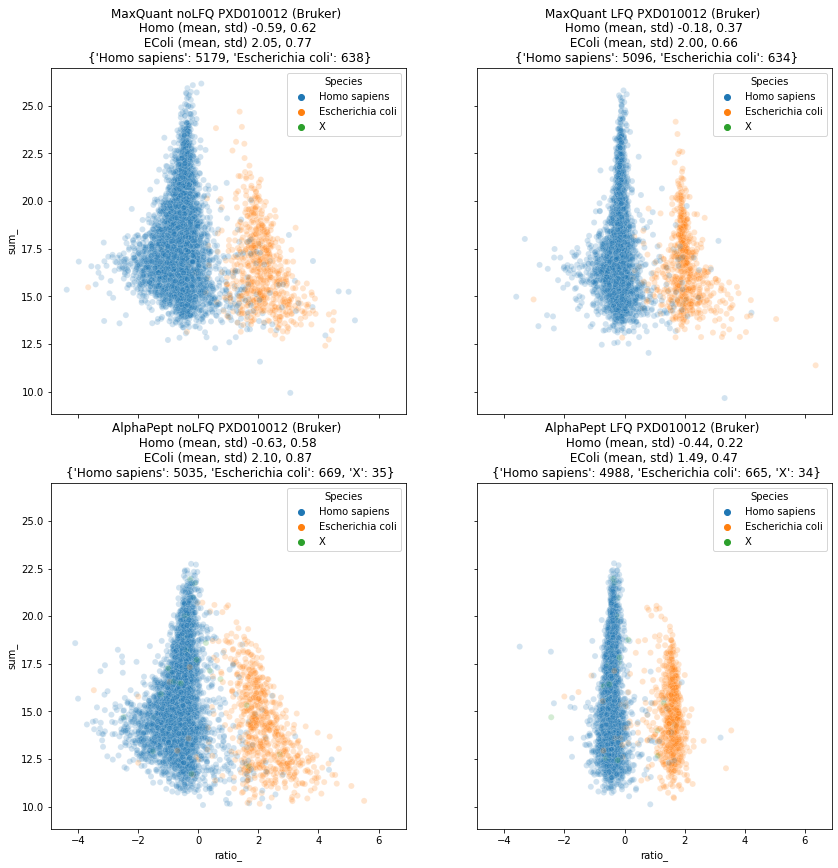

In [14]:
from test_helper import get_plot_df
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14,14), sharex=True,sharey=True)

ref = pd.read_csv(os.path.join(tmp_folder,'PXD010012_ref.txt'), sep='\t') 

for j, _ in enumerate(['noLFQ','LFQ']):
    if _ == 'LFQ':
        x = 'LFQ i'
    else:
        x = 'I'
        
    base_columns = [f"{x}ntensity Base_{i}" for i in range(1,6)]
    ratio_columns = [f"{x}ntensity Ratio_{i}" for i in range(1,6)]

    id_ = 'MaxQuant ' +_+' PXD010012 (Bruker)'
    get_plot_df(ref, base_columns, ratio_columns, axes[0,j], id_)


path = 'E:/test_temp/results.hdf' #TEST_DIR as set in test_ci.py
ref = pd.read_hdf(path, 'protein_table')

species = []
for _ in ref.index:
    if 'HUMAN' in _:
        species.append('Homo sapiens')
    elif 'ECO' in _:
        species.append('Escherichia coli')
    else:
        species.append('X')
        
ref['Species'] = species

for j, _ in enumerate(['noLFQ','LFQ']):
    if _ == 'LFQ':
        x = '_LFQ'
    else:
        x = ''
        
    base_columns = [f"PXD010012_CT_{i}_C1_01_Base{x}" for i in range(1,4)]
    ratio_columns = [f"PXD010012_CT_{i}_C2_01_Ratio{x}" for i in range(1,4)]

    id_ = 'AlphaPept ' +_+' PXD010012 (Bruker)'
    get_plot_df(ref, base_columns, ratio_columns, axes[1,j], id_)

plt.show()

2021-05-26 10:13:19> Loading files


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (54) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


2021-05-26 10:13:22> A total of 10 files.
2021-05-26 10:13:33> A total of 7,413 proteins.
2021-05-26 10:13:45> Preparing protein table for parallel processing.
2021-05-26 10:13:56> Starting protein extraction for 7413 proteins.
AlphaPool was set to 24 processes. Setting max to 24.


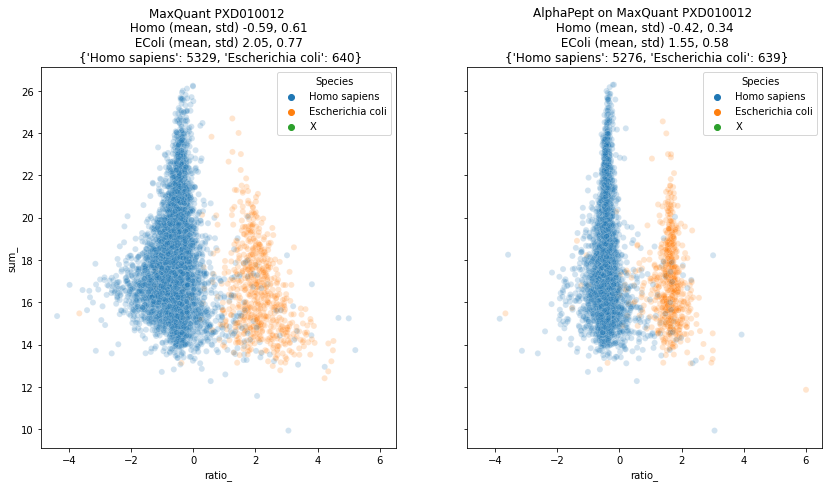

In [15]:
from alphapept.quantification import protein_profile_parallel_mq
from test_helper import get_plot_df


evidence_path = os.path.join(tmp_folder,'PXD010012_ref_evd.txt')
protein_group_path = os.path.join(tmp_folder,'PXD010012_ref.txt')

pt = protein_profile_parallel_mq(evidence_path, protein_group_path)

ref = pd.read_csv(protein_group_path, sep='\t')
species_dict = pd.Series(ref['Species'].values, index=ref['Protein IDs']).to_dict()
pt['Species'] = [species_dict[_] for _ in pt.index]


pre_lfq = [_ for _ in pt.columns if not _.endswith('_LFQ')]
lfq = [_ for _ in pt.columns if _.endswith('_LFQ')]

test_id = 'PXD010012'

fig, axes = plt.subplots(1, 2, figsize=(14,7), sharex=True,sharey=True)

ids = [f'{software_2} {test_id}', f'{software_1} on {software_2} {test_id}']

for i, ds in enumerate([pre_lfq, lfq]):

    base_columns = [_ for _ in ds if 'Base' in _]
    ratio_columns = [_ for _ in ds if 'Ratio' in _]
    get_plot_df(pt, base_columns, ratio_columns, axes[i], ids[i])

### Large Fasta

In [16]:
%run -i ../test_ci.py thermo_hela_large_fasta

['../test_ci.py', 'thermo_hela_large_fasta'] 2
2021-05-26 10:16:16> Creating dir E:/test_temp/.
2021-05-26 10:16:49> Logging to C:\Users\admin\alphapept\logs\log_20210526101649.txt.
2021-05-26 10:16:49> Platform information:
2021-05-26 10:16:49> system     - Windows
2021-05-26 10:16:49> release    - 10
2021-05-26 10:16:49> version    - 10.0.18362
2021-05-26 10:16:49> machine    - AMD64
2021-05-26 10:16:49> processor  - Intel64 Family 6 Model 85 Stepping 4, GenuineIntel
2021-05-26 10:16:49> cpu count  - 24
2021-05-26 10:16:49> ram memory - 102.9/127.7 Gb (available/total)
2021-05-26 10:16:49> 
2021-05-26 10:16:49> Python information:
2021-05-26 10:16:49> SQLAlchemy     - 1.3.22
2021-05-26 10:16:49> alphapept      - 0.3.23
2021-05-26 10:16:49> biopython      - 1.78
2021-05-26 10:16:49> click          - 7.1.2
2021-05-26 10:16:49> comtypes       - 1.1.7
2021-05-26 10:16:49> fastcore       - 1.3.5
2021-05-26 10:16:49> h5py           - 3.2.1
2021-05-26 10:16:49> lxml           - 4.6.2
2021-0




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 10:16:49> Processing 1 files for step raw_conversion
2021-05-26 10:16:49> File E:/test_temp/thermo_HeLa has extension .raw - converting from Thermo.
2021-05-26 10:18:57> File conversion complete. Extracted 120,226 precursors.
2021-05-26 10:19:03> File conversion of file E:/test_temp/thermo_HeLa.raw complete.






  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 10:19:03> Processing 1 files for step find_features
2021-05-26 10:19:03> No *.hdf file with features found for E:/test_temp/thermo_HeLa.ms_data.hdf. Adding to feature finding list.
2021-05-26 10:19:03> Feature finding on E:/test_temp/thermo_HeLa.raw
2021-05-26 10:19:09> Number of hills 1,105,353, len = 17.35
2021-05-26 10:19:09> Repeating hill extraction with ppm_tol 5.87
2021-05-26 10:19:15> Number of hills 1,227,331, len = 19.44


  0%|                                                                                            | 0/1 [02:29<?, ?it/s]
Exception in thread Thread-6:
Traceback (most recent call last):
  File "C:\Users\admin\.conda\envs\alphapept\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\admin\AppData\Roaming\Python\Python38\site-packages\tqdm\_monitor.py", line 69, in run
    instances = self.get_instances()
  File "C:\Users\admin\AppData\Roaming\Python\Python38\site-packages\tqdm\_monitor.py", line 49, in get_instances
    return [i for i in self.tqdm_cls._instances.copy()
  File "C:\Users\admin\.conda\envs\alphapept\lib\_weakrefset.py", line 92, in copy
    return self.__class__(self)
  File "C:\Users\admin\.conda\envs\alphapept\lib\_weakrefset.py", line 50, in __init__
    self.update(data)
  File "C:\Users\admin\.conda\envs\alphapept\lib\_weakrefset.py", line 119, in update
    for element in other:
  File "C:\Users\admin\.conda\envs\alphapept\lib\_weakrefset

2021-05-26 10:19:35> After split hill_ptrs 1,635,903
2021-05-26 10:19:36> After filter hill_ptrs 1,585,989
2021-05-26 10:22:35> Extracting hill stats complete


100%|████████████████████████████████████████████████████████████████████████████████| 1.0/1 [32:59<00:00, 1979.74s/it]
  0%|                                                                                            | 0/1 [14:24<?, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [13:42<00:00, 822.59s/it]


2021-05-26 10:22:49> Found 190,099 pre isotope patterns.
2021-05-26 10:23:56> Extracted 223,430 isotope patterns.
2021-05-26 10:23:59> Report complete.
2021-05-26 10:23:59> Matching features to query data.
2021-05-26 10:24:01> Saving feature table.
2021-05-26 10:24:01> Feature table saved to E:/test_temp/thermo_HeLa.ms_data.hdf
2021-05-26 10:24:01> Saving features.
2021-05-26 10:24:02> Feature finding of file E:/test_temp/thermo_HeLa.raw complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 10:24:02> Starting first search.
2021-05-26 10:24:13> Number of FASTA entries: 564,523 - FASTA settings {'mods_fixed': ['cC'], 'mods_fixed_terminal': [], 'mods_variable': ['oxM'], 'mods_variable_terminal': [], 'mods_fixed_terminal_prot': [], 'mods_variable_terminal_prot': ['a<^'], 'num_missed_cleavages': 2, 'min_length': 6, 'max_length': 27, 'max_isoforms': 1024, 'limit_modifications': 8, 'pseudo_reverse': True, 'AL_swap': False, 'KR_swap': False, 'protease': 'trypsin', 'spectra_block': 100000, 'fasta_block': 1000, 'save_db': True, 'max_fasta_size': 100}
AlphaPool was set to 60 processes. Setting max to 24.
2021-05-26 10:25:42> Block 1 of 565 complete - 0.18 % - created peptides 131,706 


  0%|                                                          | 0.0017699115044247787/1 [01:39<15:39:44, 56484.27s/it]

2021-05-26 10:25:42> Block 2 of 565 complete - 0.35 % - created peptides 137,200 


  0%|▏                                                          | 0.0035398230088495575/1 [01:40<6:29:08, 23431.30s/it]

2021-05-26 10:25:42> Block 3 of 565 complete - 0.53 % - created peptides 136,294 


  1%|▎                                                           | 0.005309734513274336/1 [01:40<3:33:06, 12854.85s/it]

2021-05-26 10:25:44> Block 4 of 565 complete - 0.71 % - created peptides 145,388 


  1%|▍                                                            | 0.007079646017699115/1 [01:42<2:14:56, 8154.13s/it]

2021-05-26 10:25:44> Block 5 of 565 complete - 0.88 % - created peptides 141,928 


  0%|                                                                                            | 0/1 [06:42<?, ?it/s]
  1%|▌                                                            | 0.008849557522123894/1 [01:44<1:31:27, 5536.47s/it]

2021-05-26 10:25:47> Block 6 of 565 complete - 1.06 % - created peptides 142,782 


  1%|▋                                                            | 0.010619469026548672/1 [01:46<1:07:33, 4097.11s/it]

2021-05-26 10:25:49> Block 7 of 565 complete - 1.24 % - created peptides 150,010 


  1%|▊                                                              | 0.012389380530973451/1 [01:48<52:06, 3166.02s/it]

2021-05-26 10:25:50> Block 8 of 565 complete - 1.42 % - created peptides 151,508 


  1%|▉                                                               | 0.01415929203539823/1 [01:50<40:51, 2486.64s/it]

2021-05-26 10:25:52> Block 9 of 565 complete - 1.59 % - created peptides 153,884 


  2%|█                                                               | 0.01592920353982301/1 [01:53<37:03, 2259.53s/it]

2021-05-26 10:25:55> Block 10 of 565 complete - 1.77 % - created peptides 160,432 


  2%|█                                                              | 0.017699115044247787/1 [01:56<33:23, 2039.56s/it]

2021-05-26 10:25:58> Block 11 of 565 complete - 1.95 % - created peptides 134,370 


  2%|█▏                                                             | 0.019469026548672566/1 [01:59<32:29, 1988.50s/it]

2021-05-26 10:26:01> Block 12 of 565 complete - 2.12 % - created peptides 158,708 


  2%|█▎                                                             | 0.021238938053097345/1 [02:02<31:11, 1912.59s/it]

2021-05-26 10:26:05> Block 13 of 565 complete - 2.30 % - created peptides 172,810 


  2%|█▍                                                             | 0.023008849557522124/1 [02:05<28:16, 1736.25s/it]

2021-05-26 10:26:07> Block 14 of 565 complete - 2.48 % - created peptides 170,612 


  2%|█▌                                                             | 0.024778761061946902/1 [02:07<27:16, 1678.35s/it]

2021-05-26 10:26:10> Block 15 of 565 complete - 2.65 % - created peptides 175,712 


  3%|█▋                                                              | 0.02654867256637168/1 [02:10<26:52, 1656.64s/it]

2021-05-26 10:26:12> Block 16 of 565 complete - 2.83 % - created peptides 175,322 


  3%|█▊                                                              | 0.02831858407079646/1 [02:13<24:59, 1543.21s/it]

2021-05-26 10:26:15> Block 17 of 565 complete - 3.01 % - created peptides 176,668 


  3%|█▉                                                              | 0.03008849557522124/1 [02:16<26:24, 1633.80s/it]

2021-05-26 10:26:18> Block 18 of 565 complete - 3.19 % - created peptides 176,542 


  3%|██                                                              | 0.03185840707964602/1 [02:19<27:02, 1676.23s/it]

2021-05-26 10:26:21> Block 19 of 565 complete - 3.36 % - created peptides 181,094 


  3%|██                                                             | 0.033628318584070796/1 [02:22<28:28, 1768.26s/it]

2021-05-26 10:26:25> Block 20 of 565 complete - 3.54 % - created peptides 181,926 


  4%|██▏                                                            | 0.035398230088495575/1 [02:26<29:37, 1842.41s/it]

2021-05-26 10:26:28> Block 21 of 565 complete - 3.72 % - created peptides 182,860 


  4%|██▍                                                             | 0.03716814159292035/1 [02:29<30:05, 1874.87s/it]

2021-05-26 10:26:32> Block 22 of 565 complete - 3.89 % - created peptides 168,696 


  4%|██▍                                                             | 0.03893805309734513/1 [02:34<33:46, 2108.69s/it]

2021-05-26 10:26:36> Block 23 of 565 complete - 4.07 % - created peptides 193,612 


  4%|██▌                                                             | 0.04070796460176991/1 [02:38<34:49, 2177.77s/it]

2021-05-26 10:26:40> Block 24 of 565 complete - 4.25 % - created peptides 206,820 


  4%|██▋                                                             | 0.04247787610619469/1 [02:44<39:50, 2496.95s/it]

2021-05-26 10:26:46> Block 25 of 565 complete - 4.42 % - created peptides 132,994 


  4%|██▊                                                             | 0.04424778761061947/1 [02:50<43:04, 2704.37s/it]

2021-05-26 10:26:52> Block 26 of 565 complete - 4.60 % - created peptides 133,548 


  5%|██▉                                                             | 0.04601769911504425/1 [02:55<43:39, 2746.27s/it]

2021-05-26 10:26:57> Block 27 of 565 complete - 4.78 % - created peptides 147,430 


  5%|███                                                            | 0.047787610619469026/1 [03:01<46:17, 2917.06s/it]

2021-05-26 10:27:03> Block 28 of 565 complete - 4.96 % - created peptides 130,340 


  5%|███                                                            | 0.049557522123893805/1 [03:06<47:01, 2968.61s/it]

2021-05-26 10:27:08> Block 29 of 565 complete - 5.13 % - created peptides 174,392 


  5%|███▎                                                            | 0.05132743362831858/1 [03:11<46:03, 2912.99s/it]

2021-05-26 10:27:13> Block 30 of 565 complete - 5.31 % - created peptides 164,200 


  5%|███▍                                                            | 0.05309734513274336/1 [03:16<45:06, 2857.89s/it]

2021-05-26 10:27:18> Block 31 of 565 complete - 5.49 % - created peptides 181,200 


  5%|███▌                                                            | 0.05486725663716814/1 [03:21<44:35, 2830.38s/it]

2021-05-26 10:27:23> Block 32 of 565 complete - 5.66 % - created peptides 134,648 


  6%|███▌                                                            | 0.05663716814159292/1 [03:25<43:05, 2740.26s/it]

2021-05-26 10:27:27> Block 33 of 565 complete - 5.84 % - created peptides 163,276 


  6%|███▊                                                             | 0.0584070796460177/1 [03:29<41:04, 2617.66s/it]

2021-05-26 10:27:32> Block 34 of 565 complete - 6.02 % - created peptides 146,326 


  6%|███▊                                                            | 0.06017699115044248/1 [03:35<44:20, 2830.46s/it]

2021-05-26 10:27:37> Block 35 of 565 complete - 6.19 % - created peptides 149,212 


  6%|███▉                                                           | 0.061946902654867256/1 [03:39<41:20, 2644.03s/it]

2021-05-26 10:27:41> Block 36 of 565 complete - 6.37 % - created peptides 185,570 


  6%|████                                                            | 0.06371681415929203/1 [03:44<42:18, 2710.88s/it]

2021-05-26 10:27:46> Block 37 of 565 complete - 6.55 % - created peptides 171,860 


  7%|████▏                                                           | 0.06548672566371681/1 [03:50<45:01, 2890.53s/it]

2021-05-26 10:27:52> Block 38 of 565 complete - 6.73 % - created peptides 171,700 


  7%|████▎                                                           | 0.06725663716814159/1 [03:56<48:16, 3105.28s/it]

2021-05-26 10:27:59> Block 39 of 565 complete - 6.90 % - created peptides 225,264 


  7%|████▍                                                           | 0.06902654867256637/1 [04:02<48:27, 3122.94s/it]

2021-05-26 10:28:04> Block 40 of 565 complete - 7.08 % - created peptides 216,084 


  7%|████▌                                                           | 0.07079646017699115/1 [04:09<51:44, 3341.18s/it]

2021-05-26 10:28:11> Block 41 of 565 complete - 7.26 % - created peptides 212,378 


  7%|████▋                                                           | 0.07256637168141593/1 [04:14<50:15, 3250.99s/it]

2021-05-26 10:28:16> Block 42 of 565 complete - 7.43 % - created peptides 206,834 


  7%|████▊                                                            | 0.0743362831858407/1 [04:20<49:59, 3240.42s/it]

2021-05-26 10:28:22> Block 43 of 565 complete - 7.61 % - created peptides 198,478 


  8%|████▊                                                           | 0.07610619469026549/1 [04:25<47:35, 3091.15s/it]

2021-05-26 10:28:27> Block 44 of 565 complete - 7.79 % - created peptides 202,198 


  8%|████▉                                                           | 0.07787610619469026/1 [04:31<48:25, 3150.72s/it]

2021-05-26 10:28:33> Block 45 of 565 complete - 7.96 % - created peptides 181,538 


  8%|█████                                                           | 0.07964601769911504/1 [04:37<49:37, 3235.28s/it]

2021-05-26 10:28:39> Block 46 of 565 complete - 8.14 % - created peptides 235,102 


  8%|█████▏                                                          | 0.08141592920353982/1 [04:42<49:47, 3251.77s/it]

2021-05-26 10:28:45> Block 47 of 565 complete - 8.32 % - created peptides 208,136 


  8%|█████▍                                                           | 0.0831858407079646/1 [04:49<51:17, 3356.35s/it]

2021-05-26 10:28:51> Block 48 of 565 complete - 8.50 % - created peptides 150,464 


  8%|█████▍                                                          | 0.08495575221238938/1 [04:55<50:49, 3332.36s/it]

2021-05-26 10:28:57> Block 49 of 565 complete - 8.67 % - created peptides 214,350 


  9%|█████▌                                                          | 0.08672566371681416/1 [05:00<50:18, 3305.21s/it]

2021-05-26 10:29:03> Block 50 of 565 complete - 8.85 % - created peptides 161,286 


  9%|█████▋                                                          | 0.08849557522123894/1 [05:05<47:49, 3148.18s/it]

2021-05-26 10:29:08> Block 51 of 565 complete - 9.03 % - created peptides 139,836 


  9%|█████▊                                                          | 0.09026548672566372/1 [05:11<49:04, 3236.61s/it]

2021-05-26 10:29:14> Block 52 of 565 complete - 9.20 % - created peptides 142,328 


  9%|█████▉                                                           | 0.0920353982300885/1 [05:18<51:09, 3381.12s/it]

2021-05-26 10:29:20> Block 53 of 565 complete - 9.38 % - created peptides 200,772 


  9%|██████                                                          | 0.09380530973451327/1 [05:24<52:01, 3445.12s/it]

2021-05-26 10:29:27> Block 54 of 565 complete - 9.56 % - created peptides 152,274 


 10%|██████                                                          | 0.09557522123893805/1 [05:30<51:03, 3387.68s/it]

2021-05-26 10:29:32> Block 55 of 565 complete - 9.73 % - created peptides 192,526 


 10%|██████▏                                                         | 0.09734513274336283/1 [05:37<52:01, 3457.64s/it]

2021-05-26 10:29:39> Block 56 of 565 complete - 9.91 % - created peptides 175,328 


 10%|██████▎                                                         | 0.09911504424778761/1 [05:42<51:05, 3402.25s/it]

2021-05-26 10:29:45> Block 57 of 565 complete - 10.09 % - created peptides 171,034 


 10%|██████▍                                                         | 0.10088495575221239/1 [05:47<47:15, 3153.81s/it]

2021-05-26 10:29:49> Block 58 of 565 complete - 10.27 % - created peptides 145,706 


 10%|██████▌                                                         | 0.10265486725663717/1 [05:53<48:35, 3248.84s/it]

2021-05-26 10:29:55> Block 59 of 565 complete - 10.44 % - created peptides 210,320 


 10%|██████▋                                                         | 0.10442477876106195/1 [06:00<50:48, 3403.79s/it]

2021-05-26 10:30:02> Block 60 of 565 complete - 10.62 % - created peptides 184,958 


 11%|██████▊                                                         | 0.10619469026548672/1 [06:05<47:52, 3214.02s/it]

2021-05-26 10:30:07> Block 61 of 565 complete - 10.80 % - created peptides 200,642 


 11%|███████                                                          | 0.1079646017699115/1 [06:11<49:28, 3327.82s/it]

2021-05-26 10:30:13> Block 62 of 565 complete - 10.97 % - created peptides 184,052 


 11%|███████                                                         | 0.10973451327433628/1 [06:18<51:10, 3448.95s/it]

2021-05-26 10:30:20> Block 63 of 565 complete - 11.15 % - created peptides 165,616 


 11%|███████▏                                                        | 0.11150442477876106/1 [06:23<48:26, 3271.27s/it]

2021-05-26 10:30:25> Block 64 of 565 complete - 11.33 % - created peptides 170,182 


 11%|███████▏                                                        | 0.11327433628318584/1 [06:29<50:20, 3406.81s/it]

2021-05-26 10:30:31> Block 65 of 565 complete - 11.50 % - created peptides 168,210 


 12%|███████▎                                                        | 0.11504424778761062/1 [06:36<51:34, 3496.75s/it]

2021-05-26 10:30:38> Block 66 of 565 complete - 11.68 % - created peptides 176,008 


 12%|███████▌                                                         | 0.1168141592920354/1 [06:44<55:33, 3774.27s/it]

2021-05-26 10:30:46> Block 67 of 565 complete - 11.86 % - created peptides 200,942 


 12%|███████▌                                                        | 0.11858407079646018/1 [06:50<54:53, 3736.93s/it]

2021-05-26 10:30:52> Block 68 of 565 complete - 12.04 % - created peptides 212,550 


 12%|███████▋                                                        | 0.12035398230088495/1 [06:55<51:31, 3514.48s/it]

2021-05-26 10:30:58> Block 69 of 565 complete - 12.21 % - created peptides 226,892 


 12%|███████▊                                                        | 0.12212389380530973/1 [07:03<53:56, 3686.21s/it]

2021-05-26 10:31:05> Block 70 of 565 complete - 12.39 % - created peptides 147,694 


 12%|███████▉                                                        | 0.12389380530973451/1 [07:08<50:17, 3444.31s/it]

2021-05-26 10:31:10> Block 71 of 565 complete - 12.57 % - created peptides 193,414 


 13%|████████▏                                                        | 0.1256637168141593/1 [07:15<52:43, 3618.00s/it]

2021-05-26 10:31:17> Block 72 of 565 complete - 12.74 % - created peptides 152,250 


 13%|████████▏                                                       | 0.12743362831858407/1 [07:21<53:17, 3664.91s/it]

2021-05-26 10:31:24> Block 73 of 565 complete - 12.92 % - created peptides 229,114 


 13%|████████▎                                                       | 0.12920353982300886/1 [07:27<51:08, 3523.91s/it]

2021-05-26 10:31:29> Block 74 of 565 complete - 13.10 % - created peptides 234,608 


 13%|████████▍                                                       | 0.13097345132743363/1 [07:35<54:03, 3732.44s/it]

2021-05-26 10:31:37> Block 75 of 565 complete - 13.27 % - created peptides 184,850 


 13%|████████▍                                                       | 0.13274336283185842/1 [07:40<50:21, 3484.04s/it]

2021-05-26 10:31:42> Block 76 of 565 complete - 13.45 % - created peptides 199,456 


 13%|████████▌                                                       | 0.13451327433628318/1 [07:47<53:48, 3730.22s/it]

2021-05-26 10:31:50> Block 77 of 565 complete - 13.63 % - created peptides 193,852 


 14%|████████▋                                                       | 0.13628318584070798/1 [07:56<57:39, 4005.11s/it]

2021-05-26 10:31:58> Block 78 of 565 complete - 13.81 % - created peptides 151,570 


 14%|████████▊                                                       | 0.13805309734513274/1 [08:03<58:30, 4072.62s/it]

2021-05-26 10:32:05> Block 79 of 565 complete - 13.98 % - created peptides 150,592 


 14%|████████▉                                                       | 0.13982300884955753/1 [08:09<54:09, 3777.26s/it]

2021-05-26 10:32:11> Block 80 of 565 complete - 14.16 % - created peptides 183,342 


 14%|█████████▏                                                       | 0.1415929203539823/1 [08:17<57:43, 4035.04s/it]

2021-05-26 10:32:19> Block 81 of 565 complete - 14.34 % - created peptides 177,422 


 14%|█████████▎                                                       | 0.1433628318584071/1 [08:22<52:53, 3704.16s/it]

2021-05-26 10:32:24> Block 82 of 565 complete - 14.51 % - created peptides 171,176 


 15%|█████████▎                                                      | 0.14513274336283186/1 [08:30<57:23, 4028.43s/it]

2021-05-26 10:32:33> Block 83 of 565 complete - 14.69 % - created peptides 142,104 


 15%|█████████▍                                                      | 0.14690265486725665/1 [08:36<53:34, 3768.31s/it]

2021-05-26 10:32:38> Block 84 of 565 complete - 14.87 % - created peptides 199,258 


 15%|█████████▋                                                       | 0.1486725663716814/1 [08:43<54:57, 3872.82s/it]

2021-05-26 10:32:45> Block 85 of 565 complete - 15.04 % - created peptides 199,534 


 15%|█████████▊                                                       | 0.1504424778761062/1 [08:52<58:12, 4110.84s/it]

2021-05-26 10:32:54> Block 86 of 565 complete - 15.22 % - created peptides 218,448 


 15%|█████████▋                                                      | 0.15221238938053097/1 [08:58<57:19, 4056.49s/it]

2021-05-26 10:33:01> Block 87 of 565 complete - 15.40 % - created peptides 182,478 


 15%|█████████▊                                                      | 0.15398230088495576/1 [09:06<57:44, 4095.04s/it]

2021-05-26 10:33:08> Block 88 of 565 complete - 15.58 % - created peptides 193,426 


 16%|█████████▉                                                      | 0.15575221238938053/1 [09:12<53:49, 3824.96s/it]

2021-05-26 10:33:14> Block 89 of 565 complete - 15.75 % - created peptides 161,900 


 16%|██████████                                                      | 0.15752212389380532/1 [09:20<57:30, 4095.80s/it]

2021-05-26 10:33:22> Block 90 of 565 complete - 15.93 % - created peptides 181,748 


 16%|██████████▎                                                      | 0.1592920353982301/1 [09:25<52:58, 3780.33s/it]

2021-05-26 10:33:28> Block 91 of 565 complete - 16.11 % - created peptides 200,434 


 16%|█████████▉                                                    | 0.16106194690265488/1 [09:35<1:00:02, 4294.05s/it]

2021-05-26 10:33:37> Block 92 of 565 complete - 16.28 % - created peptides 192,288 


 16%|██████████▍                                                     | 0.16283185840707964/1 [09:40<53:26, 3829.77s/it]

2021-05-26 10:33:42> Block 93 of 565 complete - 16.46 % - created peptides 149,864 


 16%|██████████▌                                                     | 0.16460176991150444/1 [09:48<57:20, 4117.97s/it]

2021-05-26 10:33:51> Block 94 of 565 complete - 16.64 % - created peptides 190,196 


 17%|██████████▊                                                      | 0.1663716814159292/1 [09:54<53:28, 3848.47s/it]

2021-05-26 10:33:56> Block 95 of 565 complete - 16.81 % - created peptides 178,320 


 17%|███████████                                                       | 0.168141592920354/1 [10:03<57:41, 4161.30s/it]

2021-05-26 10:34:05> Block 96 of 565 complete - 16.99 % - created peptides 230,228 


 17%|██████████▊                                                     | 0.16991150442477876/1 [10:09<54:06, 3911.53s/it]

2021-05-26 10:34:11> Block 97 of 565 complete - 17.17 % - created peptides 151,016 


 17%|██████████▉                                                     | 0.17168141592920355/1 [10:16<56:03, 4060.18s/it]

2021-05-26 10:34:19> Block 98 of 565 complete - 17.35 % - created peptides 188,974 


 17%|███████████                                                     | 0.17345132743362832/1 [10:22<52:30, 3811.93s/it]

2021-05-26 10:34:24> Block 99 of 565 complete - 17.52 % - created peptides 144,978 


 18%|███████████▍                                                     | 0.1752212389380531/1 [10:31<57:13, 4162.58s/it]

2021-05-26 10:34:33> Block 100 of 565 complete - 17.70 % - created peptides 161,746 


 18%|███████████▎                                                    | 0.17699115044247787/1 [10:37<55:02, 4013.16s/it]

2021-05-26 10:34:40> Block 101 of 565 complete - 17.88 % - created peptides 186,390 


 18%|███████████▍                                                    | 0.17876106194690267/1 [10:46<57:55, 4232.21s/it]

2021-05-26 10:34:48> Block 102 of 565 complete - 18.05 % - created peptides 148,160 


 18%|███████████▌                                                    | 0.18053097345132743/1 [10:52<55:15, 4046.14s/it]

2021-05-26 10:34:54> Block 103 of 565 complete - 18.23 % - created peptides 200,970 


 18%|███████████▋                                                    | 0.18230088495575222/1 [11:00<57:28, 4217.01s/it]

2021-05-26 10:35:03> Block 104 of 565 complete - 18.41 % - created peptides 188,426 


 18%|████████████▏                                                     | 0.184070796460177/1 [11:06<54:13, 3987.37s/it]

2021-05-26 10:35:09> Block 105 of 565 complete - 18.58 % - created peptides 174,134 


 19%|███████████▉                                                    | 0.18584070796460178/1 [11:15<58:20, 4300.14s/it]

2021-05-26 10:35:18> Block 106 of 565 complete - 18.76 % - created peptides 157,028 


 19%|████████████                                                    | 0.18761061946902655/1 [11:21<53:28, 3949.94s/it]

2021-05-26 10:35:23> Block 107 of 565 complete - 18.94 % - created peptides 182,438 


 19%|████████████                                                    | 0.18938053097345134/1 [11:29<56:21, 4171.13s/it]

2021-05-26 10:35:31> Block 108 of 565 complete - 19.12 % - created peptides 157,718 


 19%|████████████▍                                                    | 0.1911504424778761/1 [11:36<54:26, 4038.04s/it]

2021-05-26 10:35:38> Block 109 of 565 complete - 19.29 % - created peptides 160,210 


 19%|████████████▌                                                    | 0.1929203539823009/1 [11:45<58:06, 4319.69s/it]

2021-05-26 10:35:47> Block 110 of 565 complete - 19.47 % - created peptides 148,316 


 19%|████████████▍                                                   | 0.19469026548672566/1 [11:50<53:40, 3999.12s/it]

2021-05-26 10:35:53> Block 111 of 565 complete - 19.65 % - created peptides 156,360 


 20%|████████████▌                                                   | 0.19646017699115045/1 [11:59<57:49, 4317.48s/it]

2021-05-26 10:36:02> Block 112 of 565 complete - 19.82 % - created peptides 169,722 


 20%|████████████▋                                                   | 0.19823008849557522/1 [12:05<53:20, 3991.67s/it]

2021-05-26 10:36:07> Block 113 of 565 complete - 20.00 % - created peptides 152,464 


 20%|████████████████                                                                | 0.2/1 [12:13<55:43, 4179.97s/it]

2021-05-26 10:36:15> Block 114 of 565 complete - 20.18 % - created peptides 156,726 


 20%|████████████▉                                                   | 0.20176991150442478/1 [12:19<51:03, 3838.04s/it]

2021-05-26 10:36:21> Block 115 of 565 complete - 20.35 % - created peptides 210,872 


 20%|█████████████                                                   | 0.20353982300884957/1 [12:25<49:22, 3719.15s/it]

2021-05-26 10:36:27> Block 116 of 565 complete - 20.53 % - created peptides 147,526 


 21%|█████████████▏                                                  | 0.20530973451327433/1 [12:33<53:34, 4045.35s/it]

2021-05-26 10:36:35> Block 117 of 565 complete - 20.71 % - created peptides 180,536 


 21%|█████████████▎                                                  | 0.20707964601769913/1 [12:39<50:15, 3803.19s/it]

2021-05-26 10:36:41> Block 118 of 565 complete - 20.88 % - created peptides 159,952 


 21%|█████████████▌                                                   | 0.2088495575221239/1 [12:48<55:22, 4199.22s/it]

2021-05-26 10:36:50> Block 119 of 565 complete - 21.06 % - created peptides 154,866 


 21%|█████████████▍                                                  | 0.21061946902654868/1 [12:54<52:15, 3972.03s/it]

2021-05-26 10:36:56> Block 120 of 565 complete - 21.24 % - created peptides 118,604 


 21%|█████████████▌                                                  | 0.21238938053097345/1 [13:00<48:48, 3717.96s/it]

2021-05-26 10:37:02> Block 121 of 565 complete - 21.42 % - created peptides 222,658 


 21%|█████████████▋                                                  | 0.21415929203539824/1 [13:10<58:09, 4440.77s/it]

2021-05-26 10:37:13> Block 122 of 565 complete - 21.59 % - created peptides 226,130 


 22%|██████████████▎                                                   | 0.215929203539823/1 [13:16<52:58, 4053.97s/it]

2021-05-26 10:37:18> Block 123 of 565 complete - 21.77 % - created peptides 195,164 


 22%|██████████████▏                                                  | 0.2176991150442478/1 [13:25<57:41, 4424.37s/it]

2021-05-26 10:37:28> Block 124 of 565 complete - 21.95 % - created peptides 242,590 


 22%|██████████████                                                  | 0.21946902654867256/1 [13:32<53:51, 4139.65s/it]

2021-05-26 10:37:34> Block 125 of 565 complete - 22.12 % - created peptides 213,292 


 22%|██████████████▏                                                 | 0.22123893805309736/1 [13:38<52:04, 4012.16s/it]

2021-05-26 10:37:40> Block 126 of 565 complete - 22.30 % - created peptides 175,664 


 22%|██████████████▎                                                 | 0.22300884955752212/1 [13:48<58:00, 4479.64s/it]

2021-05-26 10:37:50> Block 127 of 565 complete - 22.48 % - created peptides 190,570 


 22%|██████████████▌                                                  | 0.2247787610619469/1 [13:54<53:31, 4142.60s/it]

2021-05-26 10:37:56> Block 128 of 565 complete - 22.65 % - created peptides 158,736 


 23%|██████████████▍                                                 | 0.22654867256637168/1 [14:03<57:44, 4479.12s/it]

2021-05-26 10:38:05> Block 129 of 565 complete - 22.83 % - created peptides 181,780 


 23%|██████████████▌                                                 | 0.22831858407079647/1 [14:10<54:45, 4257.06s/it]

2021-05-26 10:38:12> Block 130 of 565 complete - 23.01 % - created peptides 190,868 


 23%|██████████████▋                                                 | 0.23008849557522124/1 [14:16<51:37, 4023.01s/it]

2021-05-26 10:38:18> Block 131 of 565 complete - 23.19 % - created peptides 167,154 


 23%|██████████████▊                                                 | 0.23185840707964603/1 [14:26<56:43, 4430.93s/it]

2021-05-26 10:38:28> Block 132 of 565 complete - 23.36 % - created peptides 149,960 


 23%|███████████████▏                                                 | 0.2336283185840708/1 [14:31<51:00, 3993.32s/it]

2021-05-26 10:38:33> Block 133 of 565 complete - 23.54 % - created peptides 184,644 


 24%|███████████████                                                 | 0.23539823008849559/1 [14:40<55:39, 4368.19s/it]

2021-05-26 10:38:42> Block 134 of 565 complete - 23.72 % - created peptides 151,244 


 24%|███████████████▏                                                | 0.23716814159292035/1 [14:45<50:10, 3946.90s/it]

2021-05-26 10:38:48> Block 135 of 565 complete - 23.89 % - created peptides 175,630 


 24%|███████████████▎                                                | 0.23893805309734514/1 [14:52<48:20, 3810.53s/it]

2021-05-26 10:38:54> Block 136 of 565 complete - 24.07 % - created peptides 144,486 


 24%|███████████████▋                                                 | 0.2407079646017699/1 [15:02<56:59, 4503.85s/it]

2021-05-26 10:39:05> Block 137 of 565 complete - 24.25 % - created peptides 191,560 


 24%|███████████████▊                                                 | 0.2424778761061947/1 [15:09<54:13, 4294.43s/it]

2021-05-26 10:39:11> Block 138 of 565 complete - 24.42 % - created peptides 188,606 


 24%|███████████████▋                                                | 0.24424778761061947/1 [15:15<51:20, 4076.29s/it]

2021-05-26 10:39:18> Block 139 of 565 complete - 24.60 % - created peptides 139,342 


 25%|███████████████▋                                                | 0.24601769911504426/1 [15:25<57:05, 4542.76s/it]

2021-05-26 10:39:28> Block 140 of 565 complete - 24.78 % - created peptides 142,766 


 25%|███████████████▊                                                | 0.24778761061946902/1 [15:32<53:38, 4278.82s/it]

2021-05-26 10:39:34> Block 141 of 565 complete - 24.96 % - created peptides 210,538 


 25%|███████████████▉                                                | 0.24955752212389382/1 [15:37<48:40, 3892.12s/it]

2021-05-26 10:39:39> Block 142 of 565 complete - 25.13 % - created peptides 144,476 


 25%|████████████████▎                                                | 0.2513274336283186/1 [15:47<54:52, 4398.25s/it]

2021-05-26 10:39:49> Block 143 of 565 complete - 25.31 % - created peptides 164,846 


 25%|████████████████▏                                               | 0.25309734513274335/1 [15:53<51:15, 4118.05s/it]

2021-05-26 10:39:55> Block 144 of 565 complete - 25.49 % - created peptides 147,202 


 25%|████████████████▎                                               | 0.25486725663716814/1 [16:00<50:31, 4068.88s/it]

2021-05-26 10:40:02> Block 145 of 565 complete - 25.66 % - created peptides 216,994 


 26%|████████████████▍                                               | 0.25663716814159293/1 [16:10<56:14, 4540.16s/it]

2021-05-26 10:40:12> Block 146 of 565 complete - 25.84 % - created peptides 186,032 


 26%|████████████████▊                                                | 0.2584070796460177/1 [16:17<54:07, 4379.18s/it]

2021-05-26 10:40:19> Block 147 of 565 complete - 26.02 % - created peptides 191,098 


 26%|████████████████▋                                               | 0.26017699115044246/1 [16:23<50:26, 4090.83s/it]

2021-05-26 10:40:25> Block 148 of 565 complete - 26.19 % - created peptides 204,878 


 26%|████████████████▊                                               | 0.26194690265486725/1 [16:34<57:20, 4661.32s/it]

2021-05-26 10:40:36> Block 149 of 565 complete - 26.37 % - created peptides 178,618 


 26%|████████████████▉                                               | 0.26371681415929205/1 [16:39<51:24, 4189.45s/it]

2021-05-26 10:40:42> Block 150 of 565 complete - 26.55 % - created peptides 177,984 


 27%|████████████████▉                                               | 0.26548672566371684/1 [16:45<47:38, 3892.22s/it]

2021-05-26 10:40:47> Block 151 of 565 complete - 26.73 % - created peptides 176,392 


 27%|█████████████████▎                                               | 0.2672566371681416/1 [16:56<55:11, 4519.10s/it]

2021-05-26 10:40:58> Block 152 of 565 complete - 26.90 % - created peptides 159,518 


 27%|█████████████████▏                                              | 0.26902654867256637/1 [17:02<52:28, 4307.77s/it]

2021-05-26 10:41:05> Block 153 of 565 complete - 27.08 % - created peptides 171,596 


 27%|█████████████████▎                                              | 0.27079646017699116/1 [17:09<50:32, 4159.29s/it]

2021-05-26 10:41:11> Block 154 of 565 complete - 27.26 % - created peptides 168,394 


 27%|█████████████████▍                                              | 0.27256637168141595/1 [17:20<58:08, 4795.35s/it]

2021-05-26 10:41:22> Block 155 of 565 complete - 27.43 % - created peptides 147,076 


 27%|█████████████████▊                                               | 0.2743362831858407/1 [17:27<54:12, 4482.04s/it]

2021-05-26 10:41:29> Block 156 of 565 complete - 27.61 % - created peptides 207,402 


 28%|█████████████████▉                                               | 0.2761061946902655/1 [17:33<50:34, 4192.47s/it]

2021-05-26 10:41:35> Block 157 of 565 complete - 27.79 % - created peptides 226,022 


 28%|██████████████████                                               | 0.2778761061946903/1 [17:43<54:51, 4558.27s/it]

2021-05-26 10:41:45> Block 158 of 565 complete - 27.96 % - created peptides 162,304 


 28%|█████████████████▉                                              | 0.27964601769911507/1 [17:48<50:10, 4178.65s/it]

2021-05-26 10:41:51> Block 159 of 565 complete - 28.14 % - created peptides 192,848 


 28%|██████████████████▎                                              | 0.2814159292035398/1 [17:55<48:17, 4032.10s/it]

2021-05-26 10:41:57> Block 160 of 565 complete - 28.32 % - created peptides 175,270 


 28%|██████████████████▍                                              | 0.2831858407079646/1 [18:07<57:19, 4798.22s/it]

2021-05-26 10:42:09> Block 161 of 565 complete - 28.50 % - created peptides 205,550 


 28%|██████████████████▌                                              | 0.2849557522123894/1 [18:14<55:33, 4661.79s/it]

2021-05-26 10:42:17> Block 162 of 565 complete - 28.67 % - created peptides 193,232 


 29%|██████████████████▋                                              | 0.2867256637168142/1 [18:22<53:10, 4473.57s/it]

2021-05-26 10:42:24> Block 163 of 565 complete - 28.85 % - created peptides 176,826 


 29%|██████████████████▏                                            | 0.2884955752212389/1 [18:33<1:00:09, 5072.78s/it]

2021-05-26 10:42:35> Block 164 of 565 complete - 29.03 % - created peptides 149,158 


 29%|██████████████████▊                                              | 0.2902654867256637/1 [18:39<54:04, 4572.11s/it]

2021-05-26 10:42:41> Block 165 of 565 complete - 29.20 % - created peptides 162,394 


 29%|██████████████████▉                                              | 0.2920353982300885/1 [18:46<51:30, 4365.37s/it]

2021-05-26 10:42:48> Block 166 of 565 complete - 29.38 % - created peptides 172,390 


 29%|███████████████████                                              | 0.2938053097345133/1 [18:56<56:12, 4776.15s/it]

2021-05-26 10:42:58> Block 167 of 565 complete - 29.56 % - created peptides 213,498 


 30%|██████████████████▉                                             | 0.29557522123893804/1 [19:02<52:07, 4439.65s/it]

2021-05-26 10:43:05> Block 168 of 565 complete - 29.73 % - created peptides 150,036 


 30%|███████████████████▎                                             | 0.2973451327433628/1 [19:09<49:01, 4186.88s/it]

2021-05-26 10:43:11> Block 169 of 565 complete - 29.91 % - created peptides 153,560 


 30%|███████████████████▍                                             | 0.2991150442477876/1 [19:15<47:02, 4027.06s/it]

2021-05-26 10:43:18> Block 170 of 565 complete - 30.09 % - created peptides 180,820 


 30%|███████████████████▌                                             | 0.3008849557522124/1 [19:26<54:21, 4665.81s/it]

2021-05-26 10:43:28> Block 171 of 565 complete - 30.27 % - created peptides 171,850 


 30%|███████████████████▎                                            | 0.30265486725663715/1 [19:33<51:06, 4397.32s/it]

2021-05-26 10:43:35> Block 172 of 565 complete - 30.44 % - created peptides 173,846 


 30%|███████████████████▍                                            | 0.30442477876106194/1 [19:40<49:05, 4234.69s/it]

2021-05-26 10:43:42> Block 173 of 565 complete - 30.62 % - created peptides 146,874 


 31%|███████████████████▌                                            | 0.30619469026548674/1 [19:50<53:40, 4641.18s/it]

2021-05-26 10:43:52> Block 174 of 565 complete - 30.80 % - created peptides 156,236 


 31%|███████████████████▋                                            | 0.30796460176991153/1 [19:55<48:25, 4198.20s/it]

2021-05-26 10:43:57> Block 175 of 565 complete - 30.97 % - created peptides 141,456 


 31%|███████████████████▊                                            | 0.30973451327433627/1 [20:01<45:21, 3942.00s/it]

2021-05-26 10:44:03> Block 176 of 565 complete - 31.15 % - created peptides 207,560 


 31%|███████████████████▉                                            | 0.31150442477876106/1 [20:07<43:51, 3822.64s/it]

2021-05-26 10:44:10> Block 177 of 565 complete - 31.33 % - created peptides 146,956 


 31%|████████████████████                                            | 0.31327433628318585/1 [20:19<53:19, 4659.06s/it]

2021-05-26 10:44:21> Block 178 of 565 complete - 31.50 % - created peptides 159,864 


 32%|████████████████████▏                                           | 0.31504424778761064/1 [20:26<50:53, 4457.95s/it]

2021-05-26 10:44:28> Block 179 of 565 complete - 31.68 % - created peptides 148,658 


 32%|████████████████████▌                                            | 0.3168141592920354/1 [20:32<47:44, 4193.33s/it]

2021-05-26 10:44:35> Block 180 of 565 complete - 31.86 % - created peptides 139,662 


 32%|████████████████████▋                                            | 0.3185840707964602/1 [20:46<58:31, 5153.55s/it]

2021-05-26 10:44:48> Block 181 of 565 complete - 32.04 % - created peptides 190,864 


 32%|████████████████████▌                                           | 0.32035398230088497/1 [20:52<53:04, 4685.10s/it]

2021-05-26 10:44:54> Block 182 of 565 complete - 32.21 % - created peptides 182,724 


 32%|████████████████████▌                                           | 0.32212389380530976/1 [20:58<48:27, 4289.80s/it]

2021-05-26 10:45:00> Block 183 of 565 complete - 32.39 % - created peptides 202,286 


 32%|█████████████████████                                            | 0.3238938053097345/1 [21:04<44:45, 3971.52s/it]

2021-05-26 10:45:06> Block 184 of 565 complete - 32.57 % - created peptides 140,434 


 33%|█████████████████████▏                                           | 0.3256637168141593/1 [21:15<52:39, 4685.64s/it]

2021-05-26 10:45:17> Block 185 of 565 complete - 32.74 % - created peptides 137,594 


 33%|█████████████████████▎                                           | 0.3274336283185841/1 [21:22<50:20, 4490.29s/it]

2021-05-26 10:45:24> Block 186 of 565 complete - 32.92 % - created peptides 174,774 


 33%|█████████████████████▍                                           | 0.3292035398230089/1 [21:29<48:37, 4348.87s/it]

2021-05-26 10:45:31> Block 187 of 565 complete - 33.10 % - created peptides 173,458 


 33%|█████████████████████▌                                           | 0.3309734513274336/1 [21:37<48:29, 4348.31s/it]

2021-05-26 10:45:39> Block 188 of 565 complete - 33.27 % - created peptides 174,340 


 33%|█████████████████████▋                                           | 0.3327433628318584/1 [21:49<56:57, 5121.42s/it]

2021-05-26 10:45:51> Block 189 of 565 complete - 33.45 % - created peptides 154,774 


 33%|█████████████████████▋                                           | 0.3345132743362832/1 [21:55<51:02, 4601.76s/it]

2021-05-26 10:45:57> Block 190 of 565 complete - 33.63 % - created peptides 195,590 


 34%|██████████████████████▏                                           | 0.336283185840708/1 [22:02<47:55, 4332.71s/it]

2021-05-26 10:46:04> Block 191 of 565 complete - 33.81 % - created peptides 179,824 


 34%|█████████████████████▉                                           | 0.3380530973451327/1 [22:07<43:28, 3940.22s/it]

2021-05-26 10:46:09> Block 192 of 565 complete - 33.98 % - created peptides 132,622 


 34%|██████████████████████                                           | 0.3398230088495575/1 [22:18<51:35, 4688.59s/it]

2021-05-26 10:46:21> Block 193 of 565 complete - 34.16 % - created peptides 181,134 


 34%|██████████████████████▏                                          | 0.3415929203539823/1 [22:25<47:36, 4338.95s/it]

2021-05-26 10:46:27> Block 194 of 565 complete - 34.34 % - created peptides 174,324 


 34%|██████████████████████▎                                          | 0.3433628318584071/1 [22:31<45:28, 4155.16s/it]

2021-05-26 10:46:33> Block 195 of 565 complete - 34.51 % - created peptides 150,682 


 35%|██████████████████████                                          | 0.34513274336283184/1 [22:38<44:50, 4109.15s/it]

2021-05-26 10:46:40> Block 196 of 565 complete - 34.69 % - created peptides 190,104 


 35%|██████████████████████▏                                         | 0.34690265486725663/1 [22:51<54:24, 4998.24s/it]

2021-05-26 10:46:53> Block 197 of 565 complete - 34.87 % - created peptides 160,616 


 35%|██████████████████████▋                                          | 0.3486725663716814/1 [22:57<50:00, 4606.67s/it]

2021-05-26 10:47:00> Block 198 of 565 complete - 35.04 % - created peptides 153,616 


 35%|██████████████████████▊                                          | 0.3504424778761062/1 [23:04<46:39, 4309.27s/it]

2021-05-26 10:47:06> Block 199 of 565 complete - 35.22 % - created peptides 173,540 


 35%|██████████████████████▌                                         | 0.35221238938053095/1 [23:10<44:25, 4114.10s/it]

2021-05-26 10:47:12> Block 200 of 565 complete - 35.40 % - created peptides 180,816 


 35%|██████████████████████▋                                         | 0.35398230088495575/1 [23:23<54:15, 5039.44s/it]

2021-05-26 10:47:25> Block 201 of 565 complete - 35.58 % - created peptides 163,526 


 36%|██████████████████████▊                                         | 0.35575221238938054/1 [23:30<50:05, 4665.77s/it]

2021-05-26 10:47:32> Block 202 of 565 complete - 35.75 % - created peptides 197,664 


 36%|██████████████████████▉                                         | 0.35752212389380533/1 [23:37<47:39, 4450.99s/it]

2021-05-26 10:47:39> Block 203 of 565 complete - 35.93 % - created peptides 182,354 


 36%|██████████████████████▉                                         | 0.35929203539823007/1 [23:43<45:39, 4276.25s/it]

2021-05-26 10:47:46> Block 204 of 565 complete - 36.11 % - created peptides 186,254 


 36%|███████████████████████                                         | 0.36106194690265486/1 [23:56<54:26, 5112.22s/it]

2021-05-26 10:47:58> Block 205 of 565 complete - 36.28 % - created peptides 152,188 


 36%|███████████████████████▏                                        | 0.36283185840707965/1 [24:03<50:13, 4730.00s/it]

2021-05-26 10:48:05> Block 206 of 565 complete - 36.46 % - created peptides 188,586 


 36%|███████████████████████▎                                        | 0.36460176991150445/1 [24:09<45:58, 4341.62s/it]

2021-05-26 10:48:11> Block 207 of 565 complete - 36.64 % - created peptides 162,998 


 37%|███████████████████████▊                                         | 0.3663716814159292/1 [24:16<44:29, 4212.54s/it]

2021-05-26 10:48:18> Block 208 of 565 complete - 36.81 % - created peptides 175,708 


 37%|████████████████████████▎                                         | 0.368141592920354/1 [24:23<44:07, 4190.60s/it]

2021-05-26 10:48:25> Block 209 of 565 complete - 36.99 % - created peptides 175,714 


 37%|███████████████████████▋                                        | 0.36991150442477877/1 [24:35<52:32, 5002.94s/it]

2021-05-26 10:48:38> Block 210 of 565 complete - 37.17 % - created peptides 186,626 


 37%|███████████████████████▊                                        | 0.37168141592920356/1 [24:42<49:21, 4714.13s/it]

2021-05-26 10:48:45> Block 211 of 565 complete - 37.35 % - created peptides 181,242 


 37%|████████████████████████▎                                        | 0.3734513274336283/1 [24:49<46:33, 4459.19s/it]

2021-05-26 10:48:52> Block 212 of 565 complete - 37.52 % - created peptides 185,830 


 38%|████████████████████████▍                                        | 0.3752212389380531/1 [24:56<44:29, 4272.29s/it]

2021-05-26 10:48:58> Block 213 of 565 complete - 37.70 % - created peptides 199,602 


 38%|████████████████████████▌                                        | 0.3769911504424779/1 [25:08<51:26, 4953.88s/it]

2021-05-26 10:49:10> Block 214 of 565 complete - 37.88 % - created peptides 185,490 


 38%|████████████████████████▌                                        | 0.3787610619469027/1 [25:14<47:07, 4550.61s/it]

2021-05-26 10:49:16> Block 215 of 565 complete - 38.05 % - created peptides 199,220 


 38%|████████████████████████▋                                        | 0.3805309734513274/1 [25:21<44:13, 4284.31s/it]

2021-05-26 10:49:23> Block 216 of 565 complete - 38.23 % - created peptides 179,258 


 38%|████████████████████████▊                                        | 0.3823008849557522/1 [25:26<41:15, 4007.22s/it]

2021-05-26 10:49:29> Block 217 of 565 complete - 38.41 % - created peptides 200,100 


 38%|█████████████████████████▎                                        | 0.384070796460177/1 [25:39<50:23, 4909.12s/it]

2021-05-26 10:49:41> Block 218 of 565 complete - 38.58 % - created peptides 181,700 


 39%|█████████████████████████                                        | 0.3858407079646018/1 [25:45<44:57, 4392.82s/it]

2021-05-26 10:49:47> Block 219 of 565 complete - 38.76 % - created peptides 182,224 


 39%|████████████████████████▊                                       | 0.38761061946902653/1 [25:49<39:13, 3843.22s/it]

2021-05-26 10:49:51> Block 220 of 565 complete - 38.94 % - created peptides 186,684 


 39%|█████████████████████████▎                                       | 0.3893805309734513/1 [25:53<33:47, 3319.64s/it]

2021-05-26 10:49:55> Block 221 of 565 complete - 39.12 % - created peptides 183,288 


 39%|█████████████████████████▍                                       | 0.3911504424778761/1 [25:56<29:17, 2885.92s/it]

2021-05-26 10:49:58> Block 222 of 565 complete - 39.29 % - created peptides 191,836 


 39%|█████████████████████████▌                                       | 0.3929203539823009/1 [26:03<33:02, 3265.54s/it]

2021-05-26 10:50:06> Block 223 of 565 complete - 39.47 % - created peptides 189,564 


 39%|█████████████████████████▎                                      | 0.39469026548672564/1 [26:07<28:46, 2852.68s/it]

2021-05-26 10:50:09> Block 224 of 565 complete - 39.65 % - created peptides 163,980 


 40%|█████████████████████████▎                                      | 0.39646017699115044/1 [26:10<25:43, 2557.95s/it]

2021-05-26 10:50:12> Block 225 of 565 complete - 39.82 % - created peptides 165,064 


 40%|█████████████████████████▍                                      | 0.39823008849557523/1 [26:13<23:35, 2352.91s/it]

2021-05-26 10:50:16> Block 226 of 565 complete - 40.00 % - created peptides 189,868 


 40%|████████████████████████████████                                                | 0.4/1 [26:17<22:09, 2215.41s/it]

2021-05-26 10:50:19> Block 227 of 565 complete - 40.18 % - created peptides 166,188 


 40%|█████████████████████████▋                                      | 0.40176991150442476/1 [26:24<28:00, 2809.55s/it]

2021-05-26 10:50:26> Block 228 of 565 complete - 40.35 % - created peptides 186,782 


 40%|█████████████████████████▊                                      | 0.40353982300884955/1 [26:28<25:11, 2534.16s/it]

2021-05-26 10:50:30> Block 229 of 565 complete - 40.53 % - created peptides 185,668 


 41%|█████████████████████████▉                                      | 0.40530973451327434/1 [26:31<23:12, 2341.28s/it]

2021-05-26 10:50:33> Block 230 of 565 complete - 40.71 % - created peptides 202,070 


 41%|██████████████████████████                                      | 0.40707964601769914/1 [26:34<22:05, 2236.06s/it]

2021-05-26 10:50:37> Block 231 of 565 complete - 40.88 % - created peptides 171,176 


 41%|██████████████████████████▌                                      | 0.4088495575221239/1 [26:38<21:09, 2147.64s/it]

2021-05-26 10:50:40> Block 232 of 565 complete - 41.06 % - created peptides 197,166 


 41%|██████████████████████████▎                                     | 0.41061946902654867/1 [26:41<20:23, 2075.87s/it]

2021-05-26 10:50:43> Block 233 of 565 complete - 41.24 % - created peptides 127,306 


 41%|██████████████████████████▍                                     | 0.41238938053097346/1 [26:48<26:11, 2674.47s/it]

2021-05-26 10:50:51> Block 234 of 565 complete - 41.42 % - created peptides 185,910 


 41%|██████████████████████████▌                                     | 0.41415929203539825/1 [26:52<23:54, 2448.30s/it]

2021-05-26 10:50:54> Block 235 of 565 complete - 41.59 % - created peptides 141,762 


 42%|███████████████████████████▍                                      | 0.415929203539823/1 [26:55<22:13, 2282.73s/it]

2021-05-26 10:50:57> Block 236 of 565 complete - 41.77 % - created peptides 208,444 


 42%|███████████████████████████▏                                     | 0.4176991150442478/1 [26:59<21:08, 2178.95s/it]

2021-05-26 10:51:01> Block 237 of 565 complete - 41.95 % - created peptides 183,776 


 42%|███████████████████████████▎                                     | 0.4194690265486726/1 [27:02<20:20, 2102.53s/it]

2021-05-26 10:51:04> Block 238 of 565 complete - 42.12 % - created peptides 157,214 


 42%|██████████████████████████▉                                     | 0.42123893805309737/1 [27:09<26:00, 2697.03s/it]

2021-05-26 10:51:11> Block 239 of 565 complete - 42.30 % - created peptides 141,716 


 42%|███████████████████████████▍                                     | 0.4230088495575221/1 [27:13<23:38, 2458.86s/it]

2021-05-26 10:51:15> Block 240 of 565 complete - 42.48 % - created peptides 158,368 


 42%|███████████████████████████▌                                     | 0.4247787610619469/1 [27:16<21:59, 2293.62s/it]

2021-05-26 10:51:18> Block 241 of 565 complete - 42.65 % - created peptides 190,874 


 43%|███████████████████████████▋                                     | 0.4265486725663717/1 [27:19<20:52, 2184.52s/it]

2021-05-26 10:51:22> Block 242 of 565 complete - 42.83 % - created peptides 186,210 


 43%|███████████████████████████▊                                     | 0.4283185840707965/1 [27:23<20:06, 2110.62s/it]

2021-05-26 10:51:25> Block 243 of 565 complete - 43.01 % - created peptides 180,762 


 43%|███████████████████████████▉                                     | 0.4300884955752212/1 [27:30<25:36, 2695.52s/it]

2021-05-26 10:51:32> Block 244 of 565 complete - 43.19 % - created peptides 183,990 


 43%|████████████████████████████▌                                     | 0.431858407079646/1 [27:34<23:30, 2481.85s/it]

2021-05-26 10:51:36> Block 245 of 565 complete - 43.36 % - created peptides 196,762 


 43%|████████████████████████████▏                                    | 0.4336283185840708/1 [27:37<21:57, 2326.41s/it]

2021-05-26 10:51:39> Block 246 of 565 complete - 43.54 % - created peptides 162,336 


 44%|████████████████████████████▎                                    | 0.4353982300884956/1 [27:40<20:45, 2206.37s/it]

2021-05-26 10:51:43> Block 247 of 565 complete - 43.72 % - created peptides 233,428 


 44%|███████████████████████████▉                                    | 0.43716814159292033/1 [27:44<20:00, 2133.45s/it]

2021-05-26 10:51:46> Block 248 of 565 complete - 43.89 % - created peptides 174,002 


 44%|████████████████████████████▌                                    | 0.4389380530973451/1 [27:51<25:21, 2711.39s/it]

2021-05-26 10:51:53> Block 249 of 565 complete - 44.07 % - created peptides 169,630 


 44%|████████████████████████████▋                                    | 0.4407079646017699/1 [27:55<23:04, 2475.26s/it]

2021-05-26 10:51:57> Block 250 of 565 complete - 44.25 % - created peptides 152,488 


 44%|████████████████████████████▊                                    | 0.4424778761061947/1 [27:58<21:28, 2310.86s/it]

2021-05-26 10:52:00> Block 251 of 565 complete - 44.42 % - created peptides 164,878 


 44%|████████████████████████████▍                                   | 0.44424778761061945/1 [28:01<20:20, 2196.84s/it]

2021-05-26 10:52:04> Block 252 of 565 complete - 44.60 % - created peptides 175,044 


 45%|████████████████████████████▌                                   | 0.44601769911504424/1 [28:05<19:35, 2122.13s/it]

2021-05-26 10:52:07> Block 253 of 565 complete - 44.78 % - created peptides 157,420 


 45%|████████████████████████████▋                                   | 0.44778761061946903/1 [28:12<24:47, 2694.13s/it]

2021-05-26 10:52:14> Block 254 of 565 complete - 44.96 % - created peptides 195,436 


 45%|█████████████████████████████▏                                   | 0.4495575221238938/1 [28:15<22:39, 2469.75s/it]

2021-05-26 10:52:18> Block 255 of 565 complete - 45.13 % - created peptides 176,060 


 45%|████████████████████████████▉                                   | 0.45132743362831856/1 [28:19<21:08, 2311.14s/it]

2021-05-26 10:52:21> Block 256 of 565 complete - 45.31 % - created peptides 172,004 


 45%|████████████████████████████▉                                   | 0.45309734513274336/1 [28:22<20:05, 2203.44s/it]

2021-05-26 10:52:24> Block 257 of 565 complete - 45.49 % - created peptides 198,136 


 45%|█████████████████████████████                                   | 0.45486725663716815/1 [28:30<25:25, 2798.69s/it]

2021-05-26 10:52:32> Block 258 of 565 complete - 45.66 % - created peptides 173,358 


 46%|█████████████████████████████▏                                  | 0.45663716814159294/1 [28:33<23:03, 2546.62s/it]

2021-05-26 10:52:35> Block 259 of 565 complete - 45.84 % - created peptides 183,934 


 46%|█████████████████████████████▊                                   | 0.4584070796460177/1 [28:37<21:24, 2371.43s/it]

2021-05-26 10:52:39> Block 260 of 565 complete - 46.02 % - created peptides 164,064 


 46%|█████████████████████████████▍                                  | 0.46017699115044247/1 [28:40<20:13, 2248.01s/it]

2021-05-26 10:52:42> Block 261 of 565 complete - 46.19 % - created peptides 198,236 


 46%|█████████████████████████████▌                                  | 0.46194690265486726/1 [28:44<19:26, 2168.52s/it]

2021-05-26 10:52:46> Block 262 of 565 complete - 46.37 % - created peptides 173,078 


 46%|█████████████████████████████▋                                  | 0.46371681415929206/1 [28:51<24:36, 2752.36s/it]

2021-05-26 10:52:53> Block 263 of 565 complete - 46.55 % - created peptides 186,962 


 47%|██████████████████████████████▎                                  | 0.4654867256637168/1 [28:54<22:25, 2516.50s/it]

2021-05-26 10:52:57> Block 264 of 565 complete - 46.73 % - created peptides 169,244 


 47%|██████████████████████████████▎                                  | 0.4672566371681416/1 [28:58<20:51, 2349.93s/it]

2021-05-26 10:53:00> Block 265 of 565 complete - 46.90 % - created peptides 157,214 


 47%|██████████████████████████████▍                                  | 0.4690265486725664/1 [29:01<19:43, 2228.76s/it]

2021-05-26 10:53:03> Block 266 of 565 complete - 47.08 % - created peptides 169,902 


 47%|██████████████████████████████▏                                 | 0.47079646017699117/1 [29:05<18:57, 2149.59s/it]

2021-05-26 10:53:07> Block 267 of 565 complete - 47.26 % - created peptides 197,422 


 47%|██████████████████████████████▋                                  | 0.4725663716814159/1 [29:12<24:00, 2730.67s/it]

2021-05-26 10:53:14> Block 268 of 565 complete - 47.43 % - created peptides 170,456 


 47%|██████████████████████████████▊                                  | 0.4743362831858407/1 [29:15<21:55, 2502.08s/it]

2021-05-26 10:53:18> Block 269 of 565 complete - 47.61 % - created peptides 167,174 


 48%|██████████████████████████████▉                                  | 0.4761061946902655/1 [29:19<20:26, 2340.32s/it]

2021-05-26 10:53:21> Block 270 of 565 complete - 47.79 % - created peptides 190,656 


 48%|███████████████████████████████                                  | 0.4778761061946903/1 [29:22<19:27, 2235.42s/it]

2021-05-26 10:53:25> Block 271 of 565 complete - 47.96 % - created peptides 172,724 


 48%|███████████████████████████████▋                                  | 0.479646017699115/1 [29:26<18:41, 2154.39s/it]

2021-05-26 10:53:28> Block 272 of 565 complete - 48.14 % - created peptides 185,214 


 48%|███████████████████████████████▎                                 | 0.4814159292035398/1 [29:33<23:22, 2705.33s/it]

2021-05-26 10:53:35> Block 273 of 565 complete - 48.32 % - created peptides 174,136 


 48%|███████████████████████████████▍                                 | 0.4831858407079646/1 [29:37<21:26, 2488.53s/it]

2021-05-26 10:53:39> Block 274 of 565 complete - 48.50 % - created peptides 186,832 


 48%|███████████████████████████████▌                                 | 0.4849557522123894/1 [29:40<20:03, 2337.42s/it]

2021-05-26 10:53:42> Block 275 of 565 complete - 48.67 % - created peptides 189,776 


 49%|███████████████████████████████▏                                | 0.48672566371681414/1 [29:44<19:05, 2232.11s/it]

2021-05-26 10:53:46> Block 276 of 565 complete - 48.85 % - created peptides 175,312 


 49%|███████████████████████████████▎                                | 0.48849557522123893/1 [29:51<23:43, 2783.12s/it]

2021-05-26 10:53:53> Block 277 of 565 complete - 49.03 % - created peptides 171,646 


 49%|███████████████████████████████▊                                 | 0.4902654867256637/1 [29:54<21:36, 2544.33s/it]

2021-05-26 10:53:56> Block 278 of 565 complete - 49.20 % - created peptides 183,618 


 49%|███████████████████████████████▉                                 | 0.4920353982300885/1 [29:58<20:08, 2378.64s/it]

2021-05-26 10:54:00> Block 279 of 565 complete - 49.38 % - created peptides 189,652 


 49%|███████████████████████████████▌                                | 0.49380530973451325/1 [30:01<19:04, 2260.84s/it]

2021-05-26 10:54:03> Block 280 of 565 complete - 49.56 % - created peptides 187,474 


 50%|███████████████████████████████▋                                | 0.49557522123893805/1 [30:05<18:30, 2202.35s/it]

2021-05-26 10:54:07> Block 281 of 565 complete - 49.73 % - created peptides 175,706 


 50%|███████████████████████████████▊                                | 0.49734513274336284/1 [30:12<22:57, 2741.31s/it]

2021-05-26 10:54:14> Block 282 of 565 complete - 49.91 % - created peptides 192,034 


 50%|███████████████████████████████▉                                | 0.49911504424778763/1 [30:16<21:01, 2519.42s/it]

2021-05-26 10:54:18> Block 283 of 565 complete - 50.09 % - created peptides 180,716 


 50%|████████████████████████████████▌                                | 0.5008849557522124/1 [30:19<19:40, 2366.01s/it]

2021-05-26 10:54:21> Block 284 of 565 complete - 50.27 % - created peptides 192,912 


 50%|████████████████████████████████▋                                | 0.5026548672566372/1 [30:23<18:43, 2259.06s/it]

2021-05-26 10:54:25> Block 285 of 565 complete - 50.44 % - created peptides 175,362 


 50%|█████████████████████████████████▎                                | 0.504424778761062/1 [30:30<22:58, 2782.05s/it]

2021-05-26 10:54:32> Block 286 of 565 complete - 50.62 % - created peptides 172,970 


 51%|████████████████████████████████▉                                | 0.5061946902654867/1 [30:33<20:58, 2547.93s/it]

2021-05-26 10:54:36> Block 287 of 565 complete - 50.80 % - created peptides 194,782 


 51%|█████████████████████████████████                                | 0.5079646017699115/1 [30:37<19:35, 2389.43s/it]

2021-05-26 10:54:39> Block 288 of 565 complete - 50.97 % - created peptides 198,882 


 51%|█████████████████████████████████▏                               | 0.5097345132743363/1 [30:40<18:35, 2274.87s/it]

2021-05-26 10:54:43> Block 289 of 565 complete - 51.15 % - created peptides 174,410 


 51%|█████████████████████████████████▊                                | 0.511504424778761/1 [30:48<23:00, 2826.81s/it]

2021-05-26 10:54:50> Block 290 of 565 complete - 51.33 % - created peptides 191,740 


 51%|█████████████████████████████████▎                               | 0.5132743362831859/1 [30:51<20:56, 2581.95s/it]

2021-05-26 10:54:53> Block 291 of 565 complete - 51.50 % - created peptides 174,000 


 52%|█████████████████████████████████▍                               | 0.5150442477876106/1 [30:55<19:29, 2412.32s/it]

2021-05-26 10:54:57> Block 292 of 565 complete - 51.68 % - created peptides 173,950 


 52%|█████████████████████████████████▌                               | 0.5168141592920354/1 [30:58<18:28, 2293.38s/it]

2021-05-26 10:55:01> Block 293 of 565 complete - 51.86 % - created peptides 165,404 


 52%|█████████████████████████████████▋                               | 0.5185840707964602/1 [31:02<17:42, 2207.90s/it]

2021-05-26 10:55:04> Block 294 of 565 complete - 52.04 % - created peptides 198,340 


 52%|█████████████████████████████████▊                               | 0.5203539823008849/1 [31:09<21:47, 2726.78s/it]

2021-05-26 10:55:11> Block 295 of 565 complete - 52.21 % - created peptides 182,730 


 52%|█████████████████████████████████▉                               | 0.5221238938053098/1 [31:12<20:00, 2512.67s/it]

2021-05-26 10:55:15> Block 296 of 565 complete - 52.39 % - created peptides 189,248 


 52%|██████████████████████████████████                               | 0.5238938053097345/1 [31:16<18:46, 2365.57s/it]

2021-05-26 10:55:18> Block 297 of 565 complete - 52.57 % - created peptides 191,564 


 53%|██████████████████████████████████▏                              | 0.5256637168141592/1 [31:20<17:55, 2267.90s/it]

2021-05-26 10:55:22> Block 298 of 565 complete - 52.74 % - created peptides 199,242 


 53%|██████████████████████████████████▎                              | 0.5274336283185841/1 [31:27<21:53, 2780.18s/it]

2021-05-26 10:55:29> Block 299 of 565 complete - 52.92 % - created peptides 178,818 


 53%|██████████████████████████████████▍                              | 0.5292035398230088/1 [31:30<20:02, 2553.74s/it]

2021-05-26 10:55:33> Block 300 of 565 complete - 53.10 % - created peptides 186,146 


 53%|██████████████████████████████████▌                              | 0.5309734513274337/1 [31:34<18:46, 2402.78s/it]

2021-05-26 10:55:36> Block 301 of 565 complete - 53.27 % - created peptides 149,510 


 53%|██████████████████████████████████▋                              | 0.5327433628318584/1 [31:37<17:48, 2285.80s/it]

2021-05-26 10:55:40> Block 302 of 565 complete - 53.45 % - created peptides 173,312 


 53%|██████████████████████████████████▋                              | 0.5345132743362832/1 [31:45<21:39, 2790.96s/it]

2021-05-26 10:55:47> Block 303 of 565 complete - 53.63 % - created peptides 189,484 


 54%|███████████████████████████████████▍                              | 0.536283185840708/1 [31:48<19:52, 2571.04s/it]

2021-05-26 10:55:50> Block 304 of 565 complete - 53.81 % - created peptides 179,584 


 54%|██████████████████████████████████▉                              | 0.5380530973451327/1 [31:52<18:34, 2412.29s/it]

2021-05-26 10:55:54> Block 305 of 565 complete - 53.98 % - created peptides 156,934 


 54%|███████████████████████████████████                              | 0.5398230088495575/1 [31:55<17:37, 2296.99s/it]

2021-05-26 10:55:58> Block 306 of 565 complete - 54.16 % - created peptides 180,256 


 54%|███████████████████████████████████▏                             | 0.5415929203539823/1 [32:02<21:23, 2799.15s/it]

2021-05-26 10:56:05> Block 307 of 565 complete - 54.34 % - created peptides 163,304 


 54%|███████████████████████████████████▎                             | 0.5433628318584071/1 [32:06<19:32, 2567.12s/it]

2021-05-26 10:56:08> Block 308 of 565 complete - 54.51 % - created peptides 189,534 


 55%|███████████████████████████████████▍                             | 0.5451327433628319/1 [32:10<18:17, 2413.27s/it]

2021-05-26 10:56:12> Block 309 of 565 complete - 54.69 % - created peptides 186,228 


 55%|███████████████████████████████████▌                             | 0.5469026548672566/1 [32:13<17:24, 2305.47s/it]

2021-05-26 10:56:15> Block 310 of 565 complete - 54.87 % - created peptides 181,864 


 55%|███████████████████████████████████▋                             | 0.5486725663716814/1 [32:20<21:03, 2800.07s/it]

2021-05-26 10:56:22> Block 311 of 565 complete - 55.04 % - created peptides 179,296 


 55%|███████████████████████████████████▊                             | 0.5504424778761062/1 [32:24<19:16, 2573.38s/it]

2021-05-26 10:56:26> Block 312 of 565 complete - 55.22 % - created peptides 178,460 


 55%|████████████████████████████████████▍                             | 0.552212389380531/1 [32:27<18:00, 2413.01s/it]

2021-05-26 10:56:30> Block 313 of 565 complete - 55.40 % - created peptides 184,848 


 55%|████████████████████████████████████                             | 0.5539823008849557/1 [32:31<17:06, 2300.38s/it]

2021-05-26 10:56:33> Block 314 of 565 complete - 55.58 % - created peptides 121,822 


 56%|████████████████████████████████████                             | 0.5557522123893806/1 [32:38<20:37, 2786.00s/it]

2021-05-26 10:56:40> Block 315 of 565 complete - 55.75 % - created peptides 122,366 


 56%|████████████████████████████████████▏                            | 0.5575221238938053/1 [32:42<18:50, 2553.87s/it]

2021-05-26 10:56:44> Block 316 of 565 complete - 55.93 % - created peptides 202,480 


 56%|████████████████████████████████████▎                            | 0.5592920353982301/1 [32:45<17:39, 2405.21s/it]

2021-05-26 10:56:47> Block 317 of 565 complete - 56.11 % - created peptides 204,754 


 56%|████████████████████████████████████▍                            | 0.5610619469026549/1 [32:49<16:53, 2309.32s/it]

2021-05-26 10:56:51> Block 318 of 565 complete - 56.28 % - created peptides 185,184 


 56%|████████████████████████████████████▌                            | 0.5628318584070796/1 [32:56<20:29, 2813.43s/it]

2021-05-26 10:56:58> Block 319 of 565 complete - 56.46 % - created peptides 201,380 


 56%|████████████████████████████████████▋                            | 0.5646017699115045/1 [33:00<18:48, 2591.27s/it]

2021-05-26 10:57:02> Block 320 of 565 complete - 56.64 % - created peptides 175,056 


 57%|████████████████████████████████████▊                            | 0.5663716814159292/1 [33:03<17:32, 2427.03s/it]

2021-05-26 10:57:05> Block 321 of 565 complete - 56.81 % - created peptides 190,690 


 57%|████████████████████████████████████▉                            | 0.5681415929203539/1 [33:07<16:44, 2325.16s/it]

2021-05-26 10:57:09> Block 322 of 565 complete - 56.99 % - created peptides 172,588 


 57%|█████████████████████████████████████                            | 0.5699115044247788/1 [33:14<20:01, 2792.57s/it]

2021-05-26 10:57:16> Block 323 of 565 complete - 57.17 % - created peptides 182,200 


 57%|█████████████████████████████████████▏                           | 0.5716814159292035/1 [33:17<18:21, 2570.94s/it]

2021-05-26 10:57:20> Block 324 of 565 complete - 57.35 % - created peptides 180,868 


 57%|█████████████████████████████████████▎                           | 0.5734513274336284/1 [33:21<17:11, 2417.98s/it]

2021-05-26 10:57:23> Block 325 of 565 complete - 57.52 % - created peptides 191,542 


 58%|█████████████████████████████████████▍                           | 0.5752212389380531/1 [33:25<16:21, 2310.99s/it]

2021-05-26 10:57:27> Block 326 of 565 complete - 57.70 % - created peptides 191,096 


 58%|█████████████████████████████████████▌                           | 0.5769911504424778/1 [33:32<19:31, 2769.60s/it]

2021-05-26 10:57:34> Block 327 of 565 complete - 57.88 % - created peptides 207,230 


 58%|█████████████████████████████████████▌                           | 0.5787610619469027/1 [33:35<17:58, 2559.66s/it]

2021-05-26 10:57:37> Block 328 of 565 complete - 58.05 % - created peptides 176,348 


 58%|█████████████████████████████████████▋                           | 0.5805309734513274/1 [33:39<16:53, 2416.57s/it]

2021-05-26 10:57:41> Block 329 of 565 complete - 58.23 % - created peptides 199,700 


 58%|█████████████████████████████████████▊                           | 0.5823008849557522/1 [33:43<16:07, 2316.61s/it]

2021-05-26 10:57:45> Block 330 of 565 complete - 58.41 % - created peptides 196,028 


 58%|██████████████████████████████████████▌                           | 0.584070796460177/1 [33:49<19:03, 2749.68s/it]

2021-05-26 10:57:51> Block 331 of 565 complete - 58.58 % - created peptides 178,604 


 59%|██████████████████████████████████████                           | 0.5858407079646017/1 [33:53<17:36, 2551.15s/it]

2021-05-26 10:57:55> Block 332 of 565 complete - 58.76 % - created peptides 181,942 


 59%|██████████████████████████████████████▏                          | 0.5876106194690266/1 [33:57<16:35, 2413.90s/it]

2021-05-26 10:57:59> Block 333 of 565 complete - 58.94 % - created peptides 196,188 


 59%|██████████████████████████████████████▎                          | 0.5893805309734513/1 [34:03<19:29, 2847.17s/it]

2021-05-26 10:58:06> Block 334 of 565 complete - 59.12 % - created peptides 190,500 


 59%|██████████████████████████████████████▍                          | 0.5911504424778761/1 [34:07<17:50, 2617.57s/it]

2021-05-26 10:58:09> Block 335 of 565 complete - 59.29 % - created peptides 198,716 


 59%|██████████████████████████████████████▌                          | 0.5929203539823009/1 [34:11<16:40, 2456.82s/it]

2021-05-26 10:58:13> Block 336 of 565 complete - 59.47 % - created peptides 185,846 


 59%|██████████████████████████████████████▋                          | 0.5946902654867257/1 [34:15<15:48, 2339.72s/it]

2021-05-26 10:58:17> Block 337 of 565 complete - 59.65 % - created peptides 188,296 


 60%|██████████████████████████████████████▊                          | 0.5964601769911504/1 [34:21<18:53, 2808.59s/it]

2021-05-26 10:58:24> Block 338 of 565 complete - 59.82 % - created peptides 161,116 


 60%|██████████████████████████████████████▉                          | 0.5982300884955752/1 [34:25<17:29, 2612.65s/it]

2021-05-26 10:58:27> Block 339 of 565 complete - 60.00 % - created peptides 197,102 


 60%|████████████████████████████████████████████████                                | 0.6/1 [34:29<16:23, 2457.52s/it]

2021-05-26 10:58:31> Block 340 of 565 complete - 60.18 % - created peptides 199,518 


 60%|███████████████████████████████████████                          | 0.6017699115044248/1 [34:33<15:35, 2349.37s/it]

2021-05-26 10:58:35> Block 341 of 565 complete - 60.35 % - created peptides 188,562 


 60%|███████████████████████████████████████▏                         | 0.6035398230088496/1 [34:39<18:07, 2742.32s/it]

2021-05-26 10:58:41> Block 342 of 565 complete - 60.53 % - created peptides 182,568 


 61%|███████████████████████████████████████▎                         | 0.6053097345132743/1 [34:43<16:44, 2543.83s/it]

2021-05-26 10:58:45> Block 343 of 565 complete - 60.71 % - created peptides 177,840 


 61%|███████████████████████████████████████▍                         | 0.6070796460176991/1 [34:46<15:43, 2400.20s/it]

2021-05-26 10:58:49> Block 344 of 565 complete - 60.88 % - created peptides 178,484 


 61%|███████████████████████████████████████▌                         | 0.6088495575221239/1 [34:53<18:10, 2787.99s/it]

2021-05-26 10:58:55> Block 345 of 565 complete - 61.06 % - created peptides 167,052 


 61%|███████████████████████████████████████▋                         | 0.6106194690265486/1 [34:57<16:43, 2578.09s/it]

2021-05-26 10:58:59> Block 346 of 565 complete - 61.24 % - created peptides 166,744 


 61%|███████████████████████████████████████▊                         | 0.6123893805309735/1 [35:00<15:40, 2426.87s/it]

2021-05-26 10:59:03> Block 347 of 565 complete - 61.42 % - created peptides 178,854 


 61%|███████████████████████████████████████▉                         | 0.6141592920353982/1 [35:07<18:12, 2831.89s/it]

2021-05-26 10:59:09> Block 348 of 565 complete - 61.59 % - created peptides 198,012 


 62%|████████████████████████████████████████                         | 0.6159292035398231/1 [35:11<16:41, 2608.40s/it]

2021-05-26 10:59:13> Block 349 of 565 complete - 61.77 % - created peptides 185,884 


 62%|████████████████████████████████████████▏                        | 0.6176991150442478/1 [35:14<15:36, 2448.62s/it]

2021-05-26 10:59:17> Block 350 of 565 complete - 61.95 % - created peptides 176,328 


 62%|████████████████████████████████████████▎                        | 0.6194690265486725/1 [35:18<14:49, 2336.91s/it]

2021-05-26 10:59:20> Block 351 of 565 complete - 62.12 % - created peptides 192,386 


 62%|████████████████████████████████████████▍                        | 0.6212389380530974/1 [35:25<17:15, 2733.36s/it]

2021-05-26 10:59:27> Block 352 of 565 complete - 62.30 % - created peptides 186,616 


 62%|████████████████████████████████████████▍                        | 0.6230088495575221/1 [35:28<15:58, 2542.58s/it]

2021-05-26 10:59:30> Block 353 of 565 complete - 62.48 % - created peptides 188,828 


 62%|████████████████████████████████████████▌                        | 0.6247787610619469/1 [35:32<15:04, 2411.14s/it]

2021-05-26 10:59:34> Block 354 of 565 complete - 62.65 % - created peptides 203,316 


 63%|████████████████████████████████████████▋                        | 0.6265486725663717/1 [35:39<17:25, 2798.24s/it]

2021-05-26 10:59:41> Block 355 of 565 complete - 62.83 % - created peptides 184,190 


 63%|████████████████████████████████████████▊                        | 0.6283185840707964/1 [35:42<15:59, 2580.97s/it]

2021-05-26 10:59:44> Block 356 of 565 complete - 63.01 % - created peptides 170,882 


 63%|████████████████████████████████████████▉                        | 0.6300884955752213/1 [35:46<15:01, 2435.83s/it]

2021-05-26 10:59:48> Block 357 of 565 complete - 63.19 % - created peptides 169,808 


 63%|█████████████████████████████████████████▋                        | 0.631858407079646/1 [35:52<17:16, 2814.42s/it]

2021-05-26 10:59:55> Block 358 of 565 complete - 63.36 % - created peptides 166,644 


 63%|█████████████████████████████████████████▏                       | 0.6336283185840708/1 [35:56<15:51, 2598.22s/it]

2021-05-26 10:59:58> Block 359 of 565 complete - 63.54 % - created peptides 196,946 


 64%|█████████████████████████████████████████▎                       | 0.6353982300884956/1 [36:00<14:52, 2447.12s/it]

2021-05-26 11:00:02> Block 360 of 565 complete - 63.72 % - created peptides 173,454 


 64%|█████████████████████████████████████████▍                       | 0.6371681415929203/1 [36:07<17:07, 2831.98s/it]

2021-05-26 11:00:09> Block 361 of 565 complete - 63.89 % - created peptides 188,862 


 64%|█████████████████████████████████████████▌                       | 0.6389380530973451/1 [36:11<16:08, 2682.06s/it]

2021-05-26 11:00:13> Block 362 of 565 complete - 64.07 % - created peptides 183,460 


 64%|█████████████████████████████████████████▋                       | 0.6407079646017699/1 [36:15<15:28, 2585.04s/it]

2021-05-26 11:00:17> Block 363 of 565 complete - 64.25 % - created peptides 177,656 


 64%|█████████████████████████████████████████▊                       | 0.6424778761061947/1 [36:19<14:46, 2480.80s/it]

2021-05-26 11:00:21> Block 364 of 565 complete - 64.42 % - created peptides 186,840 


 64%|█████████████████████████████████████████▉                       | 0.6442477876106195/1 [36:26<17:08, 2890.08s/it]

2021-05-26 11:00:28> Block 365 of 565 complete - 64.60 % - created peptides 199,954 


 65%|█████████████████████████████████████████▉                       | 0.6460176991150443/1 [36:29<15:39, 2654.96s/it]

2021-05-26 11:00:32> Block 366 of 565 complete - 64.78 % - created peptides 188,214 


 65%|██████████████████████████████████████████▊                       | 0.647787610619469/1 [36:33<14:37, 2491.32s/it]

2021-05-26 11:00:35> Block 367 of 565 complete - 64.96 % - created peptides 186,892 


 65%|██████████████████████████████████████████▏                      | 0.6495575221238938/1 [36:39<16:29, 2822.93s/it]

2021-05-26 11:00:42> Block 368 of 565 complete - 65.13 % - created peptides 199,558 


 65%|██████████████████████████████████████████▎                      | 0.6513274336283186/1 [36:43<15:10, 2611.82s/it]

2021-05-26 11:00:45> Block 369 of 565 complete - 65.31 % - created peptides 183,668 


 65%|██████████████████████████████████████████▍                      | 0.6530973451327433/1 [36:47<14:13, 2461.54s/it]

2021-05-26 11:00:49> Block 370 of 565 complete - 65.49 % - created peptides 176,864 


 65%|██████████████████████████████████████████▌                      | 0.6548672566371682/1 [36:53<16:04, 2795.28s/it]

2021-05-26 11:00:55> Block 371 of 565 complete - 65.66 % - created peptides 186,480 


 66%|██████████████████████████████████████████▋                      | 0.6566371681415929/1 [36:57<14:50, 2592.45s/it]

2021-05-26 11:00:59> Block 372 of 565 complete - 65.84 % - created peptides 184,622 


 66%|██████████████████████████████████████████▊                      | 0.6584070796460177/1 [37:01<13:56, 2447.72s/it]

2021-05-26 11:01:03> Block 373 of 565 complete - 66.02 % - created peptides 202,228 


 66%|██████████████████████████████████████████▉                      | 0.6601769911504425/1 [37:07<15:47, 2789.18s/it]

2021-05-26 11:01:09> Block 374 of 565 complete - 66.19 % - created peptides 194,958 


 66%|███████████████████████████████████████████                      | 0.6619469026548672/1 [37:11<14:34, 2586.94s/it]

2021-05-26 11:01:13> Block 375 of 565 complete - 66.37 % - created peptides 202,906 


 66%|███████████████████████████████████████████▏                     | 0.6637168141592921/1 [37:15<13:43, 2450.30s/it]

2021-05-26 11:01:17> Block 376 of 565 complete - 66.55 % - created peptides 182,324 


 67%|███████████████████████████████████████████▎                     | 0.6654867256637168/1 [37:21<15:26, 2769.80s/it]

2021-05-26 11:01:23> Block 377 of 565 complete - 66.73 % - created peptides 180,934 


 67%|███████████████████████████████████████████▎                     | 0.6672566371681415/1 [37:25<14:17, 2577.37s/it]

2021-05-26 11:01:27> Block 378 of 565 complete - 66.90 % - created peptides 187,844 


 67%|███████████████████████████████████████████▍                     | 0.6690265486725664/1 [37:28<13:28, 2443.73s/it]

2021-05-26 11:01:31> Block 379 of 565 complete - 67.08 % - created peptides 201,798 


 67%|███████████████████████████████████████████▌                     | 0.6707964601769911/1 [37:35<15:10, 2764.76s/it]

2021-05-26 11:01:37> Block 380 of 565 complete - 67.26 % - created peptides 176,494 


 67%|████████████████████████████████████████████▍                     | 0.672566371681416/1 [37:38<14:02, 2573.54s/it]

2021-05-26 11:01:41> Block 381 of 565 complete - 67.43 % - created peptides 213,648 


 67%|███████████████████████████████████████████▊                     | 0.6743362831858407/1 [37:45<15:43, 2897.83s/it]

2021-05-26 11:01:47> Block 382 of 565 complete - 67.61 % - created peptides 195,488 


 68%|███████████████████████████████████████████▉                     | 0.6761061946902654/1 [37:49<14:23, 2665.25s/it]

2021-05-26 11:01:51> Block 383 of 565 complete - 67.79 % - created peptides 176,596 


 68%|████████████████████████████████████████████                     | 0.6778761061946903/1 [37:52<13:25, 2500.20s/it]

2021-05-26 11:01:54> Block 384 of 565 complete - 67.96 % - created peptides 183,048 


 68%|████████████████████████████████████████████▊                     | 0.679646017699115/1 [37:59<15:08, 2836.20s/it]

2021-05-26 11:02:01> Block 385 of 565 complete - 68.14 % - created peptides 207,586 


 68%|████████████████████████████████████████████▎                    | 0.6814159292035398/1 [38:02<13:56, 2624.82s/it]

2021-05-26 11:02:05> Block 386 of 565 complete - 68.32 % - created peptides 182,546 


 68%|████████████████████████████████████████████▍                    | 0.6831858407079646/1 [38:06<13:04, 2475.39s/it]

2021-05-26 11:02:08> Block 387 of 565 complete - 68.50 % - created peptides 183,316 


 68%|████████████████████████████████████████████▌                    | 0.6849557522123894/1 [38:13<14:43, 2803.10s/it]

2021-05-26 11:02:15> Block 388 of 565 complete - 68.67 % - created peptides 210,286 


 69%|████████████████████████████████████████████▋                    | 0.6867256637168142/1 [38:16<13:35, 2601.63s/it]

2021-05-26 11:02:19> Block 389 of 565 complete - 68.85 % - created peptides 170,588 


 69%|████████████████████████████████████████████▊                    | 0.6884955752212389/1 [38:20<12:45, 2456.94s/it]

2021-05-26 11:02:22> Block 390 of 565 complete - 69.03 % - created peptides 195,246 


 69%|████████████████████████████████████████████▊                    | 0.6902654867256637/1 [38:26<14:18, 2771.04s/it]

2021-05-26 11:02:28> Block 391 of 565 complete - 69.20 % - created peptides 206,630 


 69%|████████████████████████████████████████████▉                    | 0.6920353982300885/1 [38:30<13:14, 2580.73s/it]

2021-05-26 11:02:32> Block 392 of 565 complete - 69.38 % - created peptides 192,130 


 69%|█████████████████████████████████████████████                    | 0.6938053097345133/1 [38:34<12:28, 2445.93s/it]

2021-05-26 11:02:36> Block 393 of 565 complete - 69.56 % - created peptides 193,486 


 70%|█████████████████████████████████████████████▉                    | 0.695575221238938/1 [38:40<13:57, 2750.49s/it]

2021-05-26 11:02:42> Block 394 of 565 complete - 69.73 % - created peptides 157,348 


 70%|█████████████████████████████████████████████▎                   | 0.6973451327433628/1 [38:44<12:54, 2558.69s/it]

2021-05-26 11:02:46> Block 395 of 565 complete - 69.91 % - created peptides 208,464 


 70%|█████████████████████████████████████████████▍                   | 0.6991150442477876/1 [38:50<14:23, 2869.81s/it]

2021-05-26 11:02:52> Block 396 of 565 complete - 70.09 % - created peptides 178,012 


 70%|█████████████████████████████████████████████▌                   | 0.7008849557522124/1 [38:54<13:11, 2647.31s/it]

2021-05-26 11:02:56> Block 397 of 565 complete - 70.27 % - created peptides 183,950 


 70%|█████████████████████████████████████████████▋                   | 0.7026548672566372/1 [38:58<12:20, 2491.38s/it]

2021-05-26 11:03:00> Block 398 of 565 complete - 70.44 % - created peptides 196,170 


 70%|█████████████████████████████████████████████▊                   | 0.7044247787610619/1 [39:04<13:47, 2800.63s/it]

2021-05-26 11:03:06> Block 399 of 565 complete - 70.62 % - created peptides 180,482 


 71%|█████████████████████████████████████████████▉                   | 0.7061946902654868/1 [39:08<12:45, 2605.34s/it]

2021-05-26 11:03:10> Block 400 of 565 complete - 70.80 % - created peptides 211,962 


 71%|██████████████████████████████████████████████                   | 0.7079646017699115/1 [39:11<12:02, 2474.70s/it]

2021-05-26 11:03:14> Block 401 of 565 complete - 70.97 % - created peptides 203,338 


 71%|██████████████████████████████████████████████▏                  | 0.7097345132743362/1 [39:18<13:22, 2763.11s/it]

2021-05-26 11:03:20> Block 402 of 565 complete - 71.15 % - created peptides 188,250 


 71%|██████████████████████████████████████████████▏                  | 0.7115044247787611/1 [39:21<12:24, 2581.74s/it]

2021-05-26 11:03:24> Block 403 of 565 complete - 71.33 % - created peptides 180,514 


 71%|██████████████████████████████████████████████▎                  | 0.7132743362831858/1 [39:28<13:40, 2861.22s/it]

2021-05-26 11:03:30> Block 404 of 565 complete - 71.50 % - created peptides 177,804 


 72%|██████████████████████████████████████████████▍                  | 0.7150442477876107/1 [39:31<12:33, 2644.20s/it]

2021-05-26 11:03:34> Block 405 of 565 complete - 71.68 % - created peptides 191,222 


 72%|██████████████████████████████████████████████▌                  | 0.7168141592920354/1 [39:35<11:47, 2496.77s/it]

2021-05-26 11:03:37> Block 406 of 565 complete - 71.86 % - created peptides 201,880 


 72%|██████████████████████████████████████████████▋                  | 0.7185840707964601/1 [39:41<13:00, 2773.01s/it]

2021-05-26 11:03:43> Block 407 of 565 complete - 72.04 % - created peptides 195,754 


 72%|███████████████████████████████████████████████▌                  | 0.720353982300885/1 [39:45<12:03, 2587.00s/it]

2021-05-26 11:03:47> Block 408 of 565 complete - 72.21 % - created peptides 183,654 


 72%|██████████████████████████████████████████████▉                  | 0.7221238938053097/1 [39:51<13:14, 2858.34s/it]

2021-05-26 11:03:53> Block 409 of 565 complete - 72.39 % - created peptides 176,180 


 72%|███████████████████████████████████████████████                  | 0.7238938053097345/1 [39:55<12:08, 2639.83s/it]

2021-05-26 11:03:57> Block 410 of 565 complete - 72.57 % - created peptides 186,964 


 73%|███████████████████████████████████████████████▏                 | 0.7256637168141593/1 [39:59<11:24, 2494.95s/it]

2021-05-26 11:04:01> Block 411 of 565 complete - 72.74 % - created peptides 168,840 


 73%|████████████████████████████████████████████████                  | 0.727433628318584/1 [40:05<12:33, 2765.97s/it]

2021-05-26 11:04:07> Block 412 of 565 complete - 72.92 % - created peptides 170,790 


 73%|███████████████████████████████████████████████▍                 | 0.7292035398230089/1 [40:09<11:37, 2577.03s/it]

2021-05-26 11:04:11> Block 413 of 565 complete - 73.10 % - created peptides 194,202 


 73%|███████████████████████████████████████████████▌                 | 0.7309734513274336/1 [40:15<12:51, 2867.72s/it]

2021-05-26 11:04:17> Block 414 of 565 complete - 73.27 % - created peptides 179,872 


 73%|███████████████████████████████████████████████▋                 | 0.7327433628318584/1 [40:19<11:47, 2648.21s/it]

2021-05-26 11:04:21> Block 415 of 565 complete - 73.45 % - created peptides 185,582 


 73%|███████████████████████████████████████████████▋                 | 0.7345132743362832/1 [40:22<11:03, 2497.53s/it]

2021-05-26 11:04:25> Block 416 of 565 complete - 73.63 % - created peptides 193,130 


 74%|████████████████████████████████████████████████▌                 | 0.736283185840708/1 [40:28<12:11, 2774.01s/it]

2021-05-26 11:04:31> Block 417 of 565 complete - 73.81 % - created peptides 169,860 


 74%|███████████████████████████████████████████████▉                 | 0.7380530973451327/1 [40:32<11:24, 2612.32s/it]

2021-05-26 11:04:35> Block 418 of 565 complete - 73.98 % - created peptides 179,286 


 74%|████████████████████████████████████████████████                 | 0.7398230088495575/1 [40:39<12:24, 2861.62s/it]

2021-05-26 11:04:41> Block 419 of 565 complete - 74.16 % - created peptides 175,524 


 74%|████████████████████████████████████████████████▏                | 0.7415929203539823/1 [40:42<11:23, 2646.18s/it]

2021-05-26 11:04:45> Block 420 of 565 complete - 74.34 % - created peptides 191,970 


 74%|████████████████████████████████████████████████▎                | 0.7433628318584071/1 [40:46<10:40, 2494.58s/it]

2021-05-26 11:04:48> Block 421 of 565 complete - 74.51 % - created peptides 169,628 


 75%|████████████████████████████████████████████████▍                | 0.7451327433628319/1 [40:52<11:38, 2741.19s/it]

2021-05-26 11:04:54> Block 422 of 565 complete - 74.69 % - created peptides 185,976 


 75%|████████████████████████████████████████████████▌                | 0.7469026548672566/1 [40:56<10:48, 2563.06s/it]

2021-05-26 11:04:58> Block 423 of 565 complete - 74.87 % - created peptides 182,504 


 75%|████████████████████████████████████████████████▋                | 0.7486725663716814/1 [41:02<11:44, 2802.00s/it]

2021-05-26 11:05:04> Block 424 of 565 complete - 75.04 % - created peptides 196,424 


 75%|████████████████████████████████████████████████▊                | 0.7504424778761062/1 [41:06<10:51, 2610.04s/it]

2021-05-26 11:05:08> Block 425 of 565 complete - 75.22 % - created peptides 200,350 


 75%|████████████████████████████████████████████████▉                | 0.7522123893805309/1 [41:12<11:45, 2846.78s/it]

2021-05-26 11:05:14> Block 426 of 565 complete - 75.40 % - created peptides 174,238 


 75%|█████████████████████████████████████████████████                | 0.7539823008849558/1 [41:15<10:49, 2639.58s/it]

2021-05-26 11:05:18> Block 427 of 565 complete - 75.58 % - created peptides 189,006 


 76%|█████████████████████████████████████████████████                | 0.7557522123893805/1 [41:21<11:42, 2878.13s/it]

2021-05-26 11:05:24> Block 428 of 565 complete - 75.75 % - created peptides 169,858 


 76%|█████████████████████████████████████████████████▏               | 0.7575221238938054/1 [41:25<10:44, 2656.27s/it]

2021-05-26 11:05:27> Block 429 of 565 complete - 75.93 % - created peptides 170,310 


 76%|█████████████████████████████████████████████████▎               | 0.7592920353982301/1 [41:29<10:03, 2508.55s/it]

2021-05-26 11:05:31> Block 430 of 565 complete - 76.11 % - created peptides 186,068 


 76%|█████████████████████████████████████████████████▍               | 0.7610619469026548/1 [41:35<10:54, 2739.51s/it]

2021-05-26 11:05:37> Block 431 of 565 complete - 76.28 % - created peptides 199,164 


 76%|█████████████████████████████████████████████████▌               | 0.7628318584070797/1 [41:39<10:09, 2569.60s/it]

2021-05-26 11:05:41> Block 432 of 565 complete - 76.46 % - created peptides 186,828 


 76%|█████████████████████████████████████████████████▋               | 0.7646017699115044/1 [41:45<10:56, 2789.81s/it]

2021-05-26 11:05:47> Block 433 of 565 complete - 76.64 % - created peptides 173,804 


 77%|█████████████████████████████████████████████████▊               | 0.7663716814159292/1 [41:48<10:06, 2595.51s/it]

2021-05-26 11:05:51> Block 434 of 565 complete - 76.81 % - created peptides 176,370 


 77%|██████████████████████████████████████████████████▋               | 0.768141592920354/1 [41:54<10:51, 2809.93s/it]

2021-05-26 11:05:56> Block 435 of 565 complete - 76.99 % - created peptides 189,860 


 77%|██████████████████████████████████████████████████               | 0.7699115044247787/1 [41:58<10:01, 2613.35s/it]

2021-05-26 11:06:00> Block 436 of 565 complete - 77.17 % - created peptides 170,396 


 77%|██████████████████████████████████████████████████▏              | 0.7716814159292036/1 [42:04<10:48, 2839.83s/it]

2021-05-26 11:06:06> Block 437 of 565 complete - 77.35 % - created peptides 187,522 


 77%|██████████████████████████████████████████████████▎              | 0.7734513274336283/1 [42:08<09:57, 2635.21s/it]

2021-05-26 11:06:10> Block 438 of 565 complete - 77.52 % - created peptides 186,686 


 78%|██████████████████████████████████████████████████▍              | 0.7752212389380531/1 [42:12<09:20, 2493.72s/it]

2021-05-26 11:06:14> Block 439 of 565 complete - 77.70 % - created peptides 182,868 


 78%|██████████████████████████████████████████████████▌              | 0.7769911504424779/1 [42:17<10:00, 2694.30s/it]

2021-05-26 11:06:19> Block 440 of 565 complete - 77.88 % - created peptides 172,086 


 78%|██████████████████████████████████████████████████▌              | 0.7787610619469026/1 [42:23<10:40, 2893.91s/it]

2021-05-26 11:06:25> Block 441 of 565 complete - 78.05 % - created peptides 183,554 


 78%|██████████████████████████████████████████████████▋              | 0.7805309734513274/1 [42:27<09:48, 2679.71s/it]

2021-05-26 11:06:29> Block 442 of 565 complete - 78.23 % - created peptides 169,036 


 78%|██████████████████████████████████████████████████▊              | 0.7823008849557522/1 [42:31<09:08, 2520.76s/it]

2021-05-26 11:06:33> Block 443 of 565 complete - 78.41 % - created peptides 180,292 


 78%|███████████████████████████████████████████████████▋              | 0.784070796460177/1 [42:37<09:47, 2722.47s/it]

2021-05-26 11:06:39> Block 444 of 565 complete - 78.58 % - created peptides 184,676 


 79%|███████████████████████████████████████████████████              | 0.7858407079646018/1 [42:40<09:07, 2558.26s/it]

2021-05-26 11:06:43> Block 445 of 565 complete - 78.76 % - created peptides 184,496 


 79%|███████████████████████████████████████████████████▏             | 0.7876106194690266/1 [42:46<09:42, 2744.71s/it]

2021-05-26 11:06:48> Block 446 of 565 complete - 78.94 % - created peptides 208,064 


 79%|███████████████████████████████████████████████████▎             | 0.7893805309734513/1 [42:52<10:17, 2931.36s/it]

2021-05-26 11:06:54> Block 447 of 565 complete - 79.12 % - created peptides 177,928 


 79%|███████████████████████████████████████████████████▍             | 0.7911504424778761/1 [42:56<09:23, 2698.29s/it]

2021-05-26 11:06:58> Block 448 of 565 complete - 79.29 % - created peptides 176,402 


 79%|███████████████████████████████████████████████████▌             | 0.7929203539823009/1 [43:00<08:46, 2543.07s/it]

2021-05-26 11:07:02> Block 449 of 565 complete - 79.47 % - created peptides 179,328 


 79%|███████████████████████████████████████████████████▋             | 0.7946902654867256/1 [43:05<09:19, 2723.05s/it]

2021-05-26 11:07:07> Block 450 of 565 complete - 79.65 % - created peptides 185,160 


 80%|███████████████████████████████████████████████████▊             | 0.7964601769911505/1 [43:11<09:49, 2894.52s/it]

2021-05-26 11:07:13> Block 451 of 565 complete - 79.82 % - created peptides 186,472 


 80%|███████████████████████████████████████████████████▉             | 0.7982300884955752/1 [43:15<09:00, 2677.57s/it]

2021-05-26 11:07:17> Block 452 of 565 complete - 80.00 % - created peptides 191,502 


 80%|████████████████████████████████████████████████████████████████                | 0.8/1 [43:21<09:33, 2865.42s/it]

2021-05-26 11:07:23> Block 453 of 565 complete - 80.18 % - created peptides 109,126 


 80%|████████████████████████████████████████████████████             | 0.8017699115044248/1 [43:25<08:49, 2669.00s/it]

2021-05-26 11:07:27> Block 454 of 565 complete - 80.35 % - created peptides 187,550 


 80%|████████████████████████████████████████████████████▏            | 0.8035398230088495/1 [43:28<08:14, 2518.66s/it]

2021-05-26 11:07:31> Block 455 of 565 complete - 80.53 % - created peptides 182,296 


 81%|████████████████████████████████████████████████████▎            | 0.8053097345132744/1 [43:34<08:44, 2692.12s/it]

2021-05-26 11:07:36> Block 456 of 565 complete - 80.71 % - created peptides 196,426 


 81%|████████████████████████████████████████████████████▍            | 0.8070796460176991/1 [43:40<09:12, 2861.40s/it]

2021-05-26 11:07:42> Block 457 of 565 complete - 80.88 % - created peptides 187,626 


 81%|████████████████████████████████████████████████████▌            | 0.8088495575221238/1 [43:44<08:26, 2650.53s/it]

2021-05-26 11:07:46> Block 458 of 565 complete - 81.06 % - created peptides 173,458 


 81%|████████████████████████████████████████████████████▋            | 0.8106194690265487/1 [43:49<08:54, 2820.49s/it]

2021-05-26 11:07:51> Block 459 of 565 complete - 81.24 % - created peptides 191,018 


 81%|████████████████████████████████████████████████████▊            | 0.8123893805309734/1 [43:53<08:12, 2625.97s/it]

2021-05-26 11:07:55> Block 460 of 565 complete - 81.42 % - created peptides 177,576 


 81%|████████████████████████████████████████████████████▉            | 0.8141592920353983/1 [43:59<08:41, 2804.84s/it]

2021-05-26 11:08:01> Block 461 of 565 complete - 81.59 % - created peptides 190,512 


 82%|█████████████████████████████████████████████████████▊            | 0.815929203539823/1 [44:03<08:01, 2615.29s/it]

2021-05-26 11:08:05> Block 462 of 565 complete - 81.77 % - created peptides 169,222 


 82%|█████████████████████████████████████████████████████▏           | 0.8176991150442477/1 [44:08<08:26, 2775.69s/it]

2021-05-26 11:08:10> Block 463 of 565 complete - 81.95 % - created peptides 181,496 


 82%|█████████████████████████████████████████████████████▎           | 0.8194690265486726/1 [44:12<07:47, 2592.08s/it]

2021-05-26 11:08:14> Block 464 of 565 complete - 82.12 % - created peptides 179,976 


 82%|█████████████████████████████████████████████████████▍           | 0.8212389380530973/1 [44:17<08:10, 2741.18s/it]

2021-05-26 11:08:20> Block 465 of 565 complete - 82.30 % - created peptides 188,932 


 82%|█████████████████████████████████████████████████████▍           | 0.8230088495575221/1 [44:23<08:32, 2892.80s/it]

2021-05-26 11:08:25> Block 466 of 565 complete - 82.48 % - created peptides 189,602 


 82%|█████████████████████████████████████████████████████▌           | 0.8247787610619469/1 [44:27<07:49, 2677.15s/it]

2021-05-26 11:08:29> Block 467 of 565 complete - 82.65 % - created peptides 179,742 


 83%|█████████████████████████████████████████████████████▋           | 0.8265486725663717/1 [44:33<08:11, 2835.51s/it]

2021-05-26 11:08:35> Block 468 of 565 complete - 82.83 % - created peptides 178,324 


 83%|█████████████████████████████████████████████████████▊           | 0.8283185840707965/1 [44:37<07:33, 2638.90s/it]

2021-05-26 11:08:39> Block 469 of 565 complete - 83.01 % - created peptides 182,794 


 83%|█████████████████████████████████████████████████████▉           | 0.8300884955752212/1 [44:42<07:53, 2787.38s/it]

2021-05-26 11:08:44> Block 470 of 565 complete - 83.19 % - created peptides 171,152 


 83%|██████████████████████████████████████████████████████▉           | 0.831858407079646/1 [44:46<07:17, 2603.10s/it]

2021-05-26 11:08:48> Block 471 of 565 complete - 83.36 % - created peptides 200,044 


 83%|██████████████████████████████████████████████████████▏          | 0.8336283185840708/1 [44:51<07:37, 2748.71s/it]

2021-05-26 11:08:54> Block 472 of 565 complete - 83.54 % - created peptides 169,970 


 84%|██████████████████████████████████████████████████████▎          | 0.8353982300884956/1 [44:57<07:54, 2880.94s/it]

2021-05-26 11:08:59> Block 473 of 565 complete - 83.72 % - created peptides 186,690 


 84%|██████████████████████████████████████████████████████▍          | 0.8371681415929203/1 [45:01<07:20, 2705.39s/it]

2021-05-26 11:09:03> Block 474 of 565 complete - 83.89 % - created peptides 170,398 


 84%|██████████████████████████████████████████████████████▌          | 0.8389380530973451/1 [45:07<07:42, 2870.66s/it]

2021-05-26 11:09:09> Block 475 of 565 complete - 84.07 % - created peptides 155,670 


 84%|██████████████████████████████████████████████████████▋          | 0.8407079646017699/1 [45:11<07:18, 2752.27s/it]

2021-05-26 11:09:14> Block 476 of 565 complete - 84.25 % - created peptides 190,654 


 84%|██████████████████████████████████████████████████████▊          | 0.8424778761061947/1 [45:17<07:34, 2882.24s/it]

2021-05-26 11:09:19> Block 477 of 565 complete - 84.42 % - created peptides 187,006 


 84%|██████████████████████████████████████████████████████▉          | 0.8442477876106195/1 [45:23<07:47, 3003.50s/it]

2021-05-26 11:09:25> Block 478 of 565 complete - 84.60 % - created peptides 179,962 


 85%|██████████████████████████████████████████████████████▉          | 0.8460176991150442/1 [45:27<07:09, 2790.18s/it]

2021-05-26 11:09:29> Block 479 of 565 complete - 84.78 % - created peptides 178,086 


 85%|███████████████████████████████████████████████████████          | 0.8477876106194691/1 [45:33<07:29, 2954.32s/it]

2021-05-26 11:09:35> Block 480 of 565 complete - 84.96 % - created peptides 177,074 


 85%|███████████████████████████████████████████████████████▏         | 0.8495575221238938/1 [45:37<06:55, 2762.21s/it]

2021-05-26 11:09:39> Block 481 of 565 complete - 85.13 % - created peptides 193,510 


 85%|███████████████████████████████████████████████████████▎         | 0.8513274336283185/1 [45:42<07:04, 2857.83s/it]

2021-05-26 11:09:45> Block 482 of 565 complete - 85.31 % - created peptides 198,776 


 85%|███████████████████████████████████████████████████████▍         | 0.8530973451327434/1 [45:48<07:14, 2959.96s/it]

2021-05-26 11:09:50> Block 483 of 565 complete - 85.49 % - created peptides 189,378 


 85%|███████████████████████████████████████████████████████▌         | 0.8548672566371681/1 [45:52<06:37, 2740.81s/it]

2021-05-26 11:09:54> Block 484 of 565 complete - 85.66 % - created peptides 182,428 


 86%|████████████████████████████████████████████████████████▌         | 0.856637168141593/1 [45:57<06:47, 2842.75s/it]

2021-05-26 11:10:00> Block 485 of 565 complete - 85.84 % - created peptides 177,860 


 86%|███████████████████████████████████████████████████████▊         | 0.8584070796460177/1 [46:03<06:56, 2944.22s/it]

2021-05-26 11:10:05> Block 486 of 565 complete - 86.02 % - created peptides 185,044 


 86%|███████████████████████████████████████████████████████▉         | 0.8601769911504424/1 [46:07<06:21, 2727.33s/it]

2021-05-26 11:10:09> Block 487 of 565 complete - 86.19 % - created peptides 181,718 


 86%|████████████████████████████████████████████████████████         | 0.8619469026548673/1 [46:12<06:32, 2844.71s/it]

2021-05-26 11:10:15> Block 488 of 565 complete - 86.37 % - created peptides 180,076 


 86%|█████████████████████████████████████████████████████████         | 0.863716814159292/1 [46:18<06:44, 2966.51s/it]

2021-05-26 11:10:20> Block 489 of 565 complete - 86.55 % - created peptides 181,270 


 87%|████████████████████████████████████████████████████████▎        | 0.8654867256637168/1 [46:22<06:12, 2769.83s/it]

2021-05-26 11:10:24> Block 490 of 565 complete - 86.73 % - created peptides 181,024 


 87%|████████████████████████████████████████████████████████▎        | 0.8672566371681416/1 [46:28<06:22, 2880.74s/it]

2021-05-26 11:10:30> Block 491 of 565 complete - 86.90 % - created peptides 169,662 


 87%|████████████████████████████████████████████████████████▍        | 0.8690265486725663/1 [46:33<06:27, 2961.67s/it]

2021-05-26 11:10:36> Block 492 of 565 complete - 87.08 % - created peptides 183,448 


 87%|████████████████████████████████████████████████████████▌        | 0.8707964601769912/1 [46:37<05:55, 2751.82s/it]

2021-05-26 11:10:40> Block 493 of 565 complete - 87.26 % - created peptides 171,990 


 87%|████████████████████████████████████████████████████████▋        | 0.8725663716814159/1 [46:43<06:02, 2847.77s/it]

2021-05-26 11:10:45> Block 494 of 565 complete - 87.43 % - created peptides 201,958 


 87%|████████████████████████████████████████████████████████▊        | 0.8743362831858407/1 [46:48<06:10, 2947.40s/it]

2021-05-26 11:10:51> Block 495 of 565 complete - 87.61 % - created peptides 154,320 


 88%|████████████████████████████████████████████████████████▉        | 0.8761061946902655/1 [46:52<05:39, 2737.37s/it]

2021-05-26 11:10:55> Block 496 of 565 complete - 87.79 % - created peptides 188,994 


 88%|█████████████████████████████████████████████████████████        | 0.8778761061946903/1 [46:58<05:44, 2823.01s/it]

2021-05-26 11:11:00> Block 497 of 565 complete - 87.96 % - created peptides 174,940 


 88%|██████████████████████████████████████████████████████████        | 0.879646017699115/1 [47:03<05:47, 2891.22s/it]

2021-05-26 11:11:05> Block 498 of 565 complete - 88.14 % - created peptides 170,174 


 88%|█████████████████████████████████████████████████████████▎       | 0.8814159292035398/1 [47:09<05:52, 2974.09s/it]

2021-05-26 11:11:11> Block 499 of 565 complete - 88.32 % - created peptides 120,120 


 88%|█████████████████████████████████████████████████████████▍       | 0.8831858407079646/1 [47:13<05:24, 2778.35s/it]

2021-05-26 11:11:15> Block 500 of 565 complete - 88.50 % - created peptides 183,436 


 88%|█████████████████████████████████████████████████████████▌       | 0.8849557522123894/1 [47:18<05:26, 2837.51s/it]

2021-05-26 11:11:20> Block 501 of 565 complete - 88.67 % - created peptides 194,978 


 89%|█████████████████████████████████████████████████████████▋       | 0.8867256637168142/1 [47:23<05:24, 2865.31s/it]

2021-05-26 11:11:26> Block 502 of 565 complete - 88.85 % - created peptides 176,028 


 89%|█████████████████████████████████████████████████████████▊       | 0.8884955752212389/1 [47:29<05:22, 2891.99s/it]

2021-05-26 11:11:31> Block 503 of 565 complete - 89.03 % - created peptides 162,354 


 89%|█████████████████████████████████████████████████████████▊       | 0.8902654867256637/1 [47:34<05:22, 2937.49s/it]

2021-05-26 11:11:36> Block 504 of 565 complete - 89.20 % - created peptides 175,140 


 89%|█████████████████████████████████████████████████████████▉       | 0.8920353982300885/1 [47:39<05:21, 2980.63s/it]

2021-05-26 11:11:42> Block 505 of 565 complete - 89.38 % - created peptides 176,790 


 89%|██████████████████████████████████████████████████████████       | 0.8938053097345132/1 [47:43<04:51, 2745.79s/it]

2021-05-26 11:11:46> Block 506 of 565 complete - 89.56 % - created peptides 195,274 


 90%|██████████████████████████████████████████████████████████▏      | 0.8955752212389381/1 [47:49<04:52, 2801.00s/it]

2021-05-26 11:11:51> Block 507 of 565 complete - 89.73 % - created peptides 172,896 


 90%|██████████████████████████████████████████████████████████▎      | 0.8973451327433628/1 [47:54<04:52, 2850.51s/it]

2021-05-26 11:11:56> Block 508 of 565 complete - 89.91 % - created peptides 184,548 


 90%|██████████████████████████████████████████████████████████▍      | 0.8991150442477877/1 [47:59<04:53, 2910.14s/it]

2021-05-26 11:12:01> Block 509 of 565 complete - 90.09 % - created peptides 180,150 


 90%|██████████████████████████████████████████████████████████▌      | 0.9008849557522124/1 [48:03<04:27, 2697.07s/it]

2021-05-26 11:12:05> Block 510 of 565 complete - 90.27 % - created peptides 192,286 


 90%|██████████████████████████████████████████████████████████▋      | 0.9026548672566371/1 [48:08<04:27, 2746.92s/it]

2021-05-26 11:12:10> Block 511 of 565 complete - 90.44 % - created peptides 179,884 


 90%|███████████████████████████████████████████████████████████▋      | 0.904424778761062/1 [48:13<04:25, 2781.20s/it]

2021-05-26 11:12:15> Block 512 of 565 complete - 90.62 % - created peptides 184,684 


 91%|██████████████████████████████████████████████████████████▉      | 0.9061946902654867/1 [48:18<04:24, 2819.52s/it]

2021-05-26 11:12:21> Block 513 of 565 complete - 90.80 % - created peptides 179,894 


 91%|███████████████████████████████████████████████████████████      | 0.9079646017699115/1 [48:24<04:22, 2850.17s/it]

2021-05-26 11:12:26> Block 514 of 565 complete - 90.97 % - created peptides 203,418 


 91%|███████████████████████████████████████████████████████████▏     | 0.9097345132743363/1 [48:29<04:20, 2884.23s/it]

2021-05-26 11:12:31> Block 515 of 565 complete - 91.15 % - created peptides 191,682 


 91%|████████████████████████████████████████████████████████████▏     | 0.911504424778761/1 [48:34<04:18, 2917.79s/it]

2021-05-26 11:12:36> Block 516 of 565 complete - 91.33 % - created peptides 186,370 


 91%|███████████████████████████████████████████████████████████▎     | 0.9132743362831859/1 [48:39<04:15, 2946.40s/it]

2021-05-26 11:12:42> Block 517 of 565 complete - 91.50 % - created peptides 158,350 


 92%|███████████████████████████████████████████████████████████▍     | 0.9150442477876106/1 [48:43<03:50, 2715.67s/it]

2021-05-26 11:12:45> Block 518 of 565 complete - 91.68 % - created peptides 203,784 


 92%|███████████████████████████████████████████████████████████▌     | 0.9168141592920354/1 [48:48<03:49, 2759.43s/it]

2021-05-26 11:12:51> Block 519 of 565 complete - 91.86 % - created peptides 169,510 


 92%|███████████████████████████████████████████████████████████▋     | 0.9185840707964602/1 [48:53<03:46, 2780.02s/it]

2021-05-26 11:12:56> Block 520 of 565 complete - 92.04 % - created peptides 200,956 


 92%|███████████████████████████████████████████████████████████▊     | 0.9203539823008849/1 [48:58<03:42, 2793.74s/it]

2021-05-26 11:13:01> Block 521 of 565 complete - 92.21 % - created peptides 188,418 


 92%|███████████████████████████████████████████████████████████▉     | 0.9221238938053097/1 [49:03<03:38, 2802.00s/it]

2021-05-26 11:13:06> Block 522 of 565 complete - 92.39 % - created peptides 217,004 


 92%|████████████████████████████████████████████████████████████     | 0.9238938053097345/1 [49:08<03:33, 2811.54s/it]

2021-05-26 11:13:11> Block 523 of 565 complete - 92.57 % - created peptides 158,716 


 93%|████████████████████████████████████████████████████████████▏    | 0.9256637168141593/1 [49:15<03:45, 3037.32s/it]

2021-05-26 11:13:17> Block 524 of 565 complete - 92.74 % - created peptides 152,012 


 93%|████████████████████████████████████████████████████████████▎    | 0.9274336283185841/1 [49:19<03:21, 2782.11s/it]

2021-05-26 11:13:21> Block 525 of 565 complete - 92.92 % - created peptides 164,466 


 93%|████████████████████████████████████████████████████████████▍    | 0.9292035398230089/1 [49:25<03:32, 3003.37s/it]

2021-05-26 11:13:27> Block 526 of 565 complete - 93.10 % - created peptides 195,280 


 93%|████████████████████████████████████████████████████████████▌    | 0.9309734513274336/1 [49:29<03:11, 2767.81s/it]

2021-05-26 11:13:31> Block 527 of 565 complete - 93.27 % - created peptides 150,790 


 93%|████████████████████████████████████████████████████████████▋    | 0.9327433628318584/1 [49:35<03:20, 2985.69s/it]

2021-05-26 11:13:37> Block 528 of 565 complete - 93.45 % - created peptides 166,424 


 93%|████████████████████████████████████████████████████████████▋    | 0.9345132743362832/1 [49:39<03:00, 2752.94s/it]

2021-05-26 11:13:41> Block 529 of 565 complete - 93.63 % - created peptides 183,434 


 94%|████████████████████████████████████████████████████████████▊    | 0.9362831858407079/1 [49:45<03:10, 2988.94s/it]

2021-05-26 11:13:47> Block 530 of 565 complete - 93.81 % - created peptides 135,438 


 94%|████████████████████████████████████████████████████████████▉    | 0.9380530973451328/1 [49:49<02:50, 2748.62s/it]

2021-05-26 11:13:51> Block 531 of 565 complete - 93.98 % - created peptides 178,028 


 94%|█████████████████████████████████████████████████████████████    | 0.9398230088495575/1 [49:55<02:57, 2945.31s/it]

2021-05-26 11:13:57> Block 532 of 565 complete - 94.16 % - created peptides 146,878 


 94%|█████████████████████████████████████████████████████████████▏   | 0.9415929203539823/1 [50:00<02:51, 2931.75s/it]

2021-05-26 11:14:02> Block 533 of 565 complete - 94.34 % - created peptides 158,634 


 94%|█████████████████████████████████████████████████████████████▎   | 0.9433628318584071/1 [50:05<02:45, 2922.70s/it]

2021-05-26 11:14:07> Block 534 of 565 complete - 94.51 % - created peptides 133,472 


 95%|█████████████████████████████████████████████████████████████▍   | 0.9451327433628318/1 [50:10<02:39, 2913.15s/it]

2021-05-26 11:14:13> Block 535 of 565 complete - 94.69 % - created peptides 170,930 


 95%|█████████████████████████████████████████████████████████████▌   | 0.9469026548672567/1 [50:15<02:34, 2910.81s/it]

2021-05-26 11:14:18> Block 536 of 565 complete - 94.87 % - created peptides 141,452 


 95%|█████████████████████████████████████████████████████████████▋   | 0.9486725663716814/1 [50:21<02:29, 2903.43s/it]

2021-05-26 11:14:23> Block 537 of 565 complete - 95.04 % - created peptides 150,840 


 95%|█████████████████████████████████████████████████████████████▊   | 0.9504424778761061/1 [50:26<02:23, 2896.43s/it]

2021-05-26 11:14:28> Block 538 of 565 complete - 95.22 % - created peptides 181,316 


 95%|██████████████████████████████████████████████████████████████▊   | 0.952212389380531/1 [50:31<02:18, 2894.61s/it]

2021-05-26 11:14:33> Block 539 of 565 complete - 95.40 % - created peptides 142,870 


 95%|██████████████████████████████████████████████████████████████   | 0.9539823008849557/1 [50:36<02:12, 2887.53s/it]

2021-05-26 11:14:38> Block 540 of 565 complete - 95.58 % - created peptides 140,062 


 96%|██████████████████████████████████████████████████████████████   | 0.9557522123893806/1 [50:41<02:07, 2877.40s/it]

2021-05-26 11:14:43> Block 541 of 565 complete - 95.75 % - created peptides 149,488 


 96%|██████████████████████████████████████████████████████████████▏  | 0.9575221238938053/1 [50:46<02:01, 2869.92s/it]

2021-05-26 11:14:48> Block 542 of 565 complete - 95.93 % - created peptides 145,086 


 96%|████████████████████████████████████████████████████████████████▎  | 0.95929203539823/1 [50:51<01:56, 2857.47s/it]

2021-05-26 11:14:53> Block 543 of 565 complete - 96.11 % - created peptides 197,674 


 96%|██████████████████████████████████████████████████████████████▍  | 0.9610619469026549/1 [50:56<01:51, 2853.78s/it]

2021-05-26 11:14:58> Block 544 of 565 complete - 96.28 % - created peptides 137,842 


 96%|██████████████████████████████████████████████████████████████▌  | 0.9628318584070796/1 [51:01<01:45, 2833.22s/it]

2021-05-26 11:15:03> Block 545 of 565 complete - 96.46 % - created peptides 146,950 


 96%|██████████████████████████████████████████████████████████████▋  | 0.9646017699115044/1 [51:06<01:39, 2809.51s/it]

2021-05-26 11:15:08> Block 546 of 565 complete - 96.64 % - created peptides 192,992 


 97%|██████████████████████████████████████████████████████████████▊  | 0.9663716814159292/1 [51:11<01:33, 2788.29s/it]

2021-05-26 11:15:13> Block 547 of 565 complete - 96.81 % - created peptides 161,310 


 97%|███████████████████████████████████████████████████████████████▉  | 0.968141592920354/1 [51:16<01:33, 2932.79s/it]

2021-05-26 11:15:19> Block 548 of 565 complete - 96.99 % - created peptides 144,576 


 97%|███████████████████████████████████████████████████████████████  | 0.9699115044247788/1 [51:21<01:27, 2895.00s/it]

2021-05-26 11:15:24> Block 549 of 565 complete - 97.17 % - created peptides 172,730 


 97%|███████████████████████████████████████████████████████████████▏ | 0.9716814159292035/1 [51:26<01:21, 2865.02s/it]

2021-05-26 11:15:29> Block 550 of 565 complete - 97.35 % - created peptides 214,526 


 97%|███████████████████████████████████████████████████████████████▎ | 0.9734513274336283/1 [51:32<01:20, 3031.92s/it]

2021-05-26 11:15:35> Block 551 of 565 complete - 97.52 % - created peptides 162,692 


 98%|███████████████████████████████████████████████████████████████▍ | 0.9752212389380531/1 [51:37<01:13, 2979.70s/it]

2021-05-26 11:15:40> Block 552 of 565 complete - 97.70 % - created peptides 171,448 


 98%|███████████████████████████████████████████████████████████████▌ | 0.9769911504424779/1 [51:42<01:07, 2931.87s/it]

2021-05-26 11:15:45> Block 553 of 565 complete - 97.88 % - created peptides 148,804 


 98%|███████████████████████████████████████████████████████████████▌ | 0.9787610619469026/1 [51:47<01:01, 2891.79s/it]

2021-05-26 11:15:50> Block 554 of 565 complete - 98.05 % - created peptides 152,472 


 98%|███████████████████████████████████████████████████████████████▋ | 0.9805309734513274/1 [51:53<00:58, 3015.60s/it]

2021-05-26 11:15:55> Block 555 of 565 complete - 98.23 % - created peptides 197,066 


 98%|███████████████████████████████████████████████████████████████▊ | 0.9823008849557522/1 [51:58<00:52, 2968.31s/it]

2021-05-26 11:16:01> Block 556 of 565 complete - 98.41 % - created peptides 183,264 


 98%|████████████████████████████████████████████████████████████████▉ | 0.984070796460177/1 [52:04<00:49, 3078.76s/it]

2021-05-26 11:16:06> Block 557 of 565 complete - 98.58 % - created peptides 100,964 


 99%|████████████████████████████████████████████████████████████████ | 0.9858407079646018/1 [52:09<00:42, 3027.60s/it]

2021-05-26 11:16:12> Block 558 of 565 complete - 98.76 % - created peptides 180,636 


 99%|████████████████████████████████████████████████████████████████▏| 0.9876106194690265/1 [52:14<00:36, 2956.53s/it]

2021-05-26 11:16:17> Block 559 of 565 complete - 98.94 % - created peptides 201,552 


 99%|████████████████████████████████████████████████████████████████▎| 0.9893805309734514/1 [52:20<00:32, 3049.41s/it]

2021-05-26 11:16:22> Block 560 of 565 complete - 99.12 % - created peptides 145,266 


 99%|████████████████████████████████████████████████████████████████▍| 0.9911504424778761/1 [52:25<00:25, 2933.54s/it]

2021-05-26 11:16:27> Block 561 of 565 complete - 99.29 % - created peptides 195,808 


 99%|████████████████████████████████████████████████████████████████▌| 0.9929203539823008/1 [52:30<00:21, 3015.93s/it]

2021-05-26 11:16:33> Block 562 of 565 complete - 99.47 % - created peptides 151,108 


 99%|████████████████████████████████████████████████████████████████▋| 0.9946902654867257/1 [52:36<00:16, 3097.77s/it]

2021-05-26 11:16:39> Block 563 of 565 complete - 99.65 % - created peptides 222,900 


100%|████████████████████████████████████████████████████████████████▊| 0.9964601769911504/1 [52:41<00:10, 3024.23s/it]

2021-05-26 11:16:44> Block 564 of 565 complete - 99.82 % - created peptides 240,224 


100%|████████████████████████████████████████████████████████████████▉| 0.9982300884955753/1 [52:47<00:05, 3098.90s/it]

2021-05-26 11:16:49> Block 565 of 565 complete - 100.00 % - created peptides 170,404 


100%|████████████████████████████████████████████████████████████████████████████████| 1.0/1 [52:53<00:00, 3150.99s/it]

2021-05-26 11:16:59> Complete. Created peptides 100,748,966
2021-05-26 11:16:59> First search complete.



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 11:16:59> Processing 1 files for step calibrate_hdf
2021-05-26 11:17:01> Scoring using X-Tandem
2021-05-26 11:17:03> 28,139 target (281 decoy) of 77921 PSMs. fdr 0.009986 for a cutoff of 29.31 (set fdr was 0.01)
2021-05-26 11:17:04> Calibration of file E:/test_temp/thermo_HeLa.ms_data.hdf complete.
2021-05-26 11:17:04> Calibrating fragments
2021-05-26 11:17:04> No ions to calibrate fragment masses found




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 11:17:04> Starting second search with DB.
2021-05-26 11:17:04> Starting second search.


  0%|                                                                                            | 0/1 [00:08<?, ?it/s]


2021-05-26 11:17:16> Number of FASTA entries: 564,523 - FASTA settings {'mods_fixed': ['cC'], 'mods_fixed_terminal': [], 'mods_variable': ['oxM'], 'mods_variable_terminal': [], 'mods_fixed_terminal_prot': [], 'mods_variable_terminal_prot': ['a<^'], 'num_missed_cleavages': 2, 'min_length': 6, 'max_length': 27, 'max_isoforms': 1024, 'limit_modifications': 8, 'pseudo_reverse': True, 'AL_swap': False, 'KR_swap': False, 'protease': 'trypsin', 'spectra_block': 100000, 'fasta_block': 1000, 'save_db': True, 'max_fasta_size': 100}
AlphaPool was set to 60 processes. Setting max to 24.
2021-05-26 11:18:42> Block 1 of 565 complete - 0.18 % - created peptides 131,706 




  0%|                                                          | 0.0017699115044247787/1 [01:38<15:21:55, 55413.14s/it]

2021-05-26 11:18:43> Block 2 of 565 complete - 0.35 % - created peptides 136,294 




  0%|▏                                                          | 0.0035398230088495575/1 [01:38<6:20:58, 22939.96s/it]

2021-05-26 11:18:44> Block 3 of 565 complete - 0.53 % - created peptides 137,200 




  1%|▎                                                           | 0.005309734513274336/1 [01:40<3:33:18, 12866.87s/it]

2021-05-26 11:18:44> Block 4 of 565 complete - 0.71 % - created peptides 141,928 




  1%|▍                                                            | 0.007079646017699115/1 [01:40<2:09:27, 7822.46s/it]

2021-05-26 11:18:45> Block 5 of 565 complete - 0.88 % - created peptides 145,388 




  1%|▌                                                            | 0.008849557522123894/1 [01:40<1:23:58, 5083.24s/it]

2021-05-26 11:18:46> Block 6 of 565 complete - 1.06 % - created peptides 150,010 




  1%|▋                                                              | 0.010619469026548672/1 [01:41<59:40, 3619.35s/it]

2021-05-26 11:18:47> Block 7 of 565 complete - 1.24 % - created peptides 142,782 




  1%|▊                                                              | 0.012389380530973451/1 [01:42<41:54, 2546.01s/it]

2021-05-26 11:18:47> Block 8 of 565 complete - 1.42 % - created peptides 151,508 




  1%|▉                                                               | 0.01415929203539823/1 [01:43<29:56, 1822.56s/it]

2021-05-26 11:18:48> Block 9 of 565 complete - 1.59 % - created peptides 153,884 




  2%|█                                                               | 0.01592920353982301/1 [01:44<23:53, 1456.40s/it]

2021-05-26 11:18:49> Block 10 of 565 complete - 1.77 % - created peptides 160,432 




  2%|█                                                              | 0.017699115044247787/1 [01:45<20:08, 1229.91s/it]

2021-05-26 11:18:50> Block 11 of 565 complete - 1.95 % - created peptides 134,370 




  2%|█▏                                                             | 0.019469026548672566/1 [01:46<16:37, 1017.64s/it]

2021-05-26 11:18:51> Block 12 of 565 complete - 2.12 % - created peptides 158,708 




  2%|█▎                                                              | 0.021238938053097345/1 [01:46<12:50, 787.71s/it]

2021-05-26 11:18:51> Block 13 of 565 complete - 2.30 % - created peptides 170,612 


100%|████████████████████████████████████████████████████████████████████████████████| 1.0/1 [54:49<00:00, 3289.88s/it]


  2%|█▍                                                              | 0.023008849557522124/1 [01:47<11:20, 696.08s/it]

2021-05-26 11:18:52> Block 14 of 565 complete - 2.48 % - created peptides 168,696 




  2%|█▌                                                              | 0.024778761061946902/1 [01:48<09:36, 590.81s/it]

2021-05-26 11:18:53> Block 15 of 565 complete - 2.65 % - created peptides 175,712 




  3%|█▋                                                               | 0.02654867256637168/1 [01:49<09:34, 589.68s/it]

2021-05-26 11:18:54> Block 16 of 565 complete - 2.83 % - created peptides 175,322 




  3%|█▊                                                               | 0.02831858407079646/1 [01:50<08:27, 521.97s/it]

2021-05-26 11:18:54> Block 17 of 565 complete - 3.01 % - created peptides 176,668 




  3%|█▉                                                               | 0.03008849557522124/1 [01:50<07:25, 459.13s/it]

2021-05-26 11:18:55> Block 18 of 565 complete - 3.19 % - created peptides 172,810 




  3%|██                                                               | 0.03185840707964602/1 [01:51<08:08, 504.61s/it]

2021-05-26 11:18:56> Block 19 of 565 complete - 3.36 % - created peptides 176,542 




  3%|██▏                                                             | 0.033628318584070796/1 [01:52<07:17, 453.09s/it]

2021-05-26 11:18:56> Block 20 of 565 complete - 3.54 % - created peptides 181,094 




  4%|██▎                                                             | 0.035398230088495575/1 [01:53<07:19, 456.02s/it]

2021-05-26 11:18:57> Block 21 of 565 complete - 3.72 % - created peptides 193,612 




  4%|██▍                                                              | 0.03716814159292035/1 [01:54<08:19, 519.22s/it]

2021-05-26 11:18:58> Block 22 of 565 complete - 3.89 % - created peptides 181,926 




  4%|██▌                                                              | 0.03893805309734513/1 [01:54<07:37, 475.66s/it]

2021-05-26 11:18:59> Block 23 of 565 complete - 4.07 % - created peptides 182,860 




  4%|██▋                                                              | 0.04070796460176991/1 [01:55<08:16, 517.15s/it]

2021-05-26 11:19:02> Block 24 of 565 complete - 4.25 % - created peptides 206,820 




  4%|██▊                                                              | 0.04247787610619469/1 [01:58<12:28, 781.74s/it]

2021-05-26 11:19:21> Block 25 of 565 complete - 4.42 % - created peptides 133,548 




  4%|██▋                                                           | 0.04424778761061947/1 [02:18<1:02:47, 3942.06s/it]

2021-05-26 11:19:23> Block 26 of 565 complete - 4.60 % - created peptides 132,994 




  5%|██▉                                                             | 0.04601769911504425/1 [02:19<47:35, 2993.29s/it]

2021-05-26 11:19:29> Block 27 of 565 complete - 4.78 % - created peptides 147,430 




  5%|███                                                            | 0.047787610619469026/1 [02:25<48:07, 3032.80s/it]

2021-05-26 11:19:30> Block 28 of 565 complete - 4.96 % - created peptides 130,340 




  5%|███                                                            | 0.049557522123893805/1 [02:27<38:37, 2438.68s/it]

2021-05-26 11:19:31> Block 29 of 565 complete - 5.13 % - created peptides 174,392 




  5%|███▎                                                            | 0.05132743362831858/1 [02:28<29:11, 1846.60s/it]

2021-05-26 11:19:33> Block 30 of 565 complete - 5.31 % - created peptides 134,648 




  5%|███▍                                                            | 0.05309734513274336/1 [02:30<26:55, 1705.77s/it]

2021-05-26 11:19:35> Block 31 of 565 complete - 5.49 % - created peptides 146,326 




  5%|███▌                                                            | 0.05486725663716814/1 [02:31<21:25, 1359.77s/it]

2021-05-26 11:19:36> Block 32 of 565 complete - 5.66 % - created peptides 164,200 




  6%|███▌                                                            | 0.05663716814159292/1 [02:33<19:01, 1209.51s/it]

2021-05-26 11:19:37> Block 33 of 565 complete - 5.84 % - created peptides 163,276 




  6%|███▊                                                             | 0.0584070796460177/1 [02:34<15:58, 1018.05s/it]

2021-05-26 11:19:38> Block 34 of 565 complete - 6.02 % - created peptides 181,200 




  6%|███▉                                                             | 0.06017699115044248/1 [02:35<15:09, 967.79s/it]

2021-05-26 11:19:40> Block 35 of 565 complete - 6.19 % - created peptides 149,212 




  6%|███▉                                                           | 0.061946902654867256/1 [02:37<16:29, 1054.72s/it]

2021-05-26 11:19:42> Block 36 of 565 complete - 6.37 % - created peptides 171,700 




  6%|████▏                                                            | 0.06371681415929203/1 [02:38<14:44, 944.23s/it]

2021-05-26 11:19:45> Block 37 of 565 complete - 6.55 % - created peptides 171,860 




  7%|████▏                                                           | 0.06548672566371681/1 [02:42<18:17, 1174.44s/it]

2021-05-26 11:19:47> Block 38 of 565 complete - 6.73 % - created peptides 185,570 




  7%|████▎                                                           | 0.06725663716814159/1 [02:44<18:24, 1184.23s/it]

2021-05-26 11:19:49> Block 39 of 565 complete - 6.90 % - created peptides 225,264 




  7%|████▍                                                           | 0.06902654867256637/1 [02:45<17:15, 1112.61s/it]

2021-05-26 11:19:51> Block 40 of 565 complete - 7.08 % - created peptides 216,084 




  7%|████▌                                                           | 0.07079646017699115/1 [02:48<18:05, 1167.69s/it]

2021-05-26 11:19:52> Block 41 of 565 complete - 7.26 % - created peptides 212,378 




  7%|████▋                                                           | 0.07256637168141593/1 [02:50<17:49, 1153.15s/it]

2021-05-26 11:19:54> Block 42 of 565 complete - 7.43 % - created peptides 202,198 




  7%|████▊                                                            | 0.0743362831858407/1 [02:51<17:24, 1128.36s/it]

2021-05-26 11:19:56> Block 43 of 565 complete - 7.61 % - created peptides 214,350 




  8%|████▉                                                            | 0.07610619469026549/1 [02:53<15:23, 999.35s/it]

2021-05-26 11:19:57> Block 44 of 565 complete - 7.79 % - created peptides 198,478 




  8%|█████                                                            | 0.07787610619469026/1 [02:54<14:58, 974.66s/it]

2021-05-26 11:19:59> Block 45 of 565 complete - 7.96 % - created peptides 235,102 




  8%|█████▏                                                           | 0.07964601769911504/1 [02:56<14:57, 975.08s/it]

2021-05-26 11:20:01> Block 46 of 565 complete - 8.14 % - created peptides 181,538 




  8%|█████▏                                                          | 0.08141592920353982/1 [02:58<15:22, 1004.78s/it]

2021-05-26 11:20:03> Block 47 of 565 complete - 8.32 % - created peptides 206,834 




  8%|█████▍                                                            | 0.0831858407079646/1 [02:59<14:03, 919.84s/it]

2021-05-26 11:20:04> Block 48 of 565 complete - 8.50 % - created peptides 208,136 




  8%|█████▌                                                           | 0.08495575221238938/1 [03:01<14:37, 959.08s/it]

2021-05-26 11:20:07> Block 49 of 565 complete - 8.67 % - created peptides 150,464 




  9%|█████▌                                                          | 0.08672566371681416/1 [03:04<17:08, 1126.51s/it]

2021-05-26 11:20:14> Block 50 of 565 complete - 8.85 % - created peptides 139,836 




  9%|█████▋                                                          | 0.08849557522123894/1 [03:11<30:25, 2002.34s/it]

2021-05-26 11:20:16> Block 51 of 565 complete - 9.03 % - created peptides 142,328 




  9%|█████▊                                                          | 0.09026548672566372/1 [03:12<24:33, 1620.24s/it]

2021-05-26 11:20:18> Block 52 of 565 complete - 9.20 % - created peptides 161,286 




  9%|█████▉                                                           | 0.0920353982300885/1 [03:15<24:01, 1587.13s/it]

2021-05-26 11:20:22> Block 53 of 565 complete - 9.38 % - created peptides 175,328 




  9%|██████                                                          | 0.09380530973451327/1 [03:20<29:00, 1920.81s/it]

2021-05-26 11:20:24> Block 54 of 565 complete - 9.56 % - created peptides 171,034 




 10%|██████                                                          | 0.09557522123893805/1 [03:22<25:43, 1706.69s/it]

2021-05-26 11:20:27> Block 55 of 565 complete - 9.73 % - created peptides 200,772 




 10%|██████▏                                                         | 0.09734513274336283/1 [03:24<23:21, 1552.81s/it]

2021-05-26 11:20:29> Block 56 of 565 complete - 9.91 % - created peptides 152,274 




 10%|██████▎                                                         | 0.09911504424778761/1 [03:26<21:24, 1426.28s/it]

2021-05-26 11:20:31> Block 57 of 565 complete - 10.09 % - created peptides 192,526 




 10%|██████▍                                                         | 0.10088495575221239/1 [03:28<20:14, 1350.52s/it]

2021-05-26 11:20:33> Block 58 of 565 complete - 10.27 % - created peptides 145,706 




 10%|██████▌                                                         | 0.10265486725663717/1 [03:30<18:12, 1217.72s/it]

2021-05-26 11:20:34> Block 59 of 565 complete - 10.44 % - created peptides 210,320 




 10%|██████▋                                                         | 0.10442477876106195/1 [03:32<18:09, 1216.14s/it]

2021-05-26 11:20:38> Block 60 of 565 complete - 10.62 % - created peptides 165,616 




 11%|██████▊                                                         | 0.10619469026548672/1 [03:36<22:49, 1531.80s/it]

2021-05-26 11:20:41> Block 61 of 565 complete - 10.80 % - created peptides 200,642 




 11%|███████                                                          | 0.1079646017699115/1 [03:38<22:03, 1484.13s/it]

2021-05-26 11:20:43> Block 62 of 565 complete - 10.97 % - created peptides 170,182 




 11%|███████                                                         | 0.10973451327433628/1 [03:40<21:00, 1415.81s/it]

2021-05-26 11:20:45> Block 63 of 565 complete - 11.15 % - created peptides 168,210 




 11%|███████▏                                                        | 0.11150442477876106/1 [03:42<19:47, 1336.23s/it]

2021-05-26 11:20:47> Block 64 of 565 complete - 11.33 % - created peptides 184,052 




 11%|███████▏                                                        | 0.11327433628318584/1 [03:45<20:15, 1370.44s/it]

2021-05-26 11:20:50> Block 65 of 565 complete - 11.50 % - created peptides 176,008 




 12%|███████▎                                                        | 0.11504424778761062/1 [03:47<18:21, 1244.88s/it]

2021-05-26 11:20:51> Block 66 of 565 complete - 11.68 % - created peptides 184,958 




 12%|███████▌                                                         | 0.1168141592920354/1 [03:49<18:24, 1250.87s/it]

2021-05-26 11:20:54> Block 67 of 565 complete - 11.86 % - created peptides 226,892 




 12%|███████▌                                                        | 0.11858407079646018/1 [03:51<18:26, 1255.30s/it]

2021-05-26 11:20:56> Block 68 of 565 complete - 12.04 % - created peptides 200,942 




 12%|███████▋                                                        | 0.12035398230088495/1 [03:54<19:08, 1305.79s/it]

2021-05-26 11:20:58> Block 69 of 565 complete - 12.21 % - created peptides 147,694 




 12%|███████▊                                                        | 0.12212389380530973/1 [03:56<19:38, 1342.23s/it]

2021-05-26 11:21:01> Block 70 of 565 complete - 12.39 % - created peptides 212,550 




 12%|███████▉                                                        | 0.12389380530973451/1 [03:58<19:12, 1315.96s/it]

2021-05-26 11:21:03> Block 71 of 565 complete - 12.57 % - created peptides 193,414 




 13%|████████▏                                                        | 0.1256637168141593/1 [04:01<19:04, 1309.43s/it]

2021-05-26 11:21:05> Block 72 of 565 complete - 12.74 % - created peptides 152,250 




 13%|████████▏                                                       | 0.12743362831858407/1 [04:03<19:14, 1322.85s/it]

2021-05-26 11:21:08> Block 73 of 565 complete - 12.92 % - created peptides 234,608 




 13%|████████▎                                                       | 0.12920353982300886/1 [04:06<19:32, 1346.74s/it]

2021-05-26 11:21:10> Block 74 of 565 complete - 13.10 % - created peptides 229,114 




 13%|████████▍                                                       | 0.13097345132743363/1 [04:08<19:56, 1376.28s/it]

2021-05-26 11:21:13> Block 75 of 565 complete - 13.27 % - created peptides 184,850 




 13%|████████▍                                                       | 0.13274336283185842/1 [04:11<19:37, 1357.19s/it]

2021-05-26 11:21:15> Block 76 of 565 complete - 13.45 % - created peptides 151,570 




 13%|████████▌                                                       | 0.13451327433628318/1 [04:14<21:05, 1462.74s/it]

2021-05-26 11:21:18> Block 77 of 565 complete - 13.63 % - created peptides 150,592 




 14%|████████▋                                                       | 0.13628318584070798/1 [04:16<21:19, 1481.74s/it]

2021-05-26 11:21:21> Block 78 of 565 complete - 13.81 % - created peptides 199,456 




 14%|████████▊                                                       | 0.13805309734513274/1 [04:19<20:55, 1456.27s/it]

2021-05-26 11:21:23> Block 79 of 565 complete - 13.98 % - created peptides 183,342 




 14%|████████▉                                                       | 0.13982300884955753/1 [04:22<21:20, 1488.77s/it]

2021-05-26 11:21:26> Block 80 of 565 complete - 14.16 % - created peptides 177,422 




 14%|█████████▏                                                       | 0.1415929203539823/1 [04:24<21:04, 1472.97s/it]

2021-05-26 11:21:29> Block 81 of 565 complete - 14.34 % - created peptides 193,852 




 14%|█████████▎                                                       | 0.1433628318584071/1 [04:26<19:04, 1335.68s/it]

2021-05-26 11:21:31> Block 82 of 565 complete - 14.51 % - created peptides 171,176 




 15%|█████████▎                                                      | 0.14513274336283186/1 [04:29<19:51, 1394.18s/it]

2021-05-26 11:21:33> Block 83 of 565 complete - 14.69 % - created peptides 142,104 




 15%|█████████▍                                                      | 0.14690265486725665/1 [04:31<20:26, 1438.19s/it]

2021-05-26 11:21:36> Block 84 of 565 complete - 14.87 % - created peptides 193,426 




 15%|█████████▋                                                       | 0.1486725663716814/1 [04:35<22:44, 1602.70s/it]

2021-05-26 11:21:40> Block 85 of 565 complete - 15.04 % - created peptides 199,534 




 15%|█████████▊                                                       | 0.1504424778761062/1 [04:37<22:17, 1574.04s/it]

2021-05-26 11:21:42> Block 86 of 565 complete - 15.22 % - created peptides 182,478 




 15%|█████████▋                                                      | 0.15221238938053097/1 [04:40<21:27, 1518.64s/it]

2021-05-26 11:21:45> Block 87 of 565 complete - 15.40 % - created peptides 199,258 




 15%|█████████▊                                                      | 0.15398230088495576/1 [04:43<23:04, 1636.95s/it]

2021-05-26 11:21:48> Block 88 of 565 complete - 15.58 % - created peptides 218,448 




 16%|█████████▉                                                      | 0.15575221238938053/1 [04:46<22:10, 1575.53s/it]

2021-05-26 11:21:51> Block 89 of 565 complete - 15.75 % - created peptides 161,900 




 16%|██████████                                                      | 0.15752212389380532/1 [04:50<24:26, 1740.55s/it]

2021-05-26 11:21:54> Block 90 of 565 complete - 15.93 % - created peptides 181,748 




 16%|██████████▎                                                      | 0.1592920353982301/1 [04:52<22:03, 1574.77s/it]

2021-05-26 11:21:56> Block 91 of 565 complete - 16.11 % - created peptides 192,288 




 16%|██████████▎                                                     | 0.16106194690265488/1 [04:54<21:35, 1544.35s/it]

2021-05-26 11:21:59> Block 92 of 565 complete - 16.28 % - created peptides 178,320 




 16%|██████████▍                                                     | 0.16283185840707964/1 [04:58<23:44, 1701.50s/it]

2021-05-26 11:22:03> Block 93 of 565 complete - 16.46 % - created peptides 149,864 




 16%|██████████▌                                                     | 0.16460176991150444/1 [05:00<21:28, 1541.78s/it]

2021-05-26 11:22:05> Block 94 of 565 complete - 16.64 % - created peptides 200,434 




 17%|██████████▊                                                      | 0.1663716814159292/1 [05:03<22:40, 1631.69s/it]

2021-05-26 11:22:08> Block 95 of 565 complete - 16.81 % - created peptides 190,196 




 17%|███████████                                                       | 0.168141592920354/1 [05:05<20:53, 1507.30s/it]

2021-05-26 11:22:10> Block 96 of 565 complete - 16.99 % - created peptides 230,228 




 17%|██████████▊                                                     | 0.16991150442477876/1 [05:09<22:27, 1623.31s/it]

2021-05-26 11:22:14> Block 97 of 565 complete - 17.17 % - created peptides 151,016 




 17%|██████████▉                                                     | 0.17168141592920355/1 [05:11<20:21, 1474.13s/it]

2021-05-26 11:22:15> Block 98 of 565 complete - 17.35 % - created peptides 186,390 




 17%|███████████                                                     | 0.17345132743362832/1 [05:14<21:52, 1588.24s/it]

2021-05-26 11:22:19> Block 99 of 565 complete - 17.52 % - created peptides 188,974 




 18%|███████████▍                                                     | 0.1752212389380531/1 [05:16<20:25, 1486.13s/it]

2021-05-26 11:22:21> Block 100 of 565 complete - 17.70 % - created peptides 161,746 




 18%|███████████▎                                                    | 0.17699115044247787/1 [05:20<22:43, 1656.67s/it]

2021-05-26 11:22:25> Block 101 of 565 complete - 17.88 % - created peptides 144,978 




 18%|███████████▍                                                    | 0.17876106194690267/1 [05:23<23:04, 1685.56s/it]

2021-05-26 11:22:28> Block 102 of 565 complete - 18.05 % - created peptides 148,160 




 18%|███████████▌                                                    | 0.18053097345132743/1 [05:25<21:24, 1567.70s/it]

2021-05-26 11:22:30> Block 103 of 565 complete - 18.23 % - created peptides 174,134 




 18%|███████████▋                                                    | 0.18230088495575222/1 [05:29<23:33, 1729.19s/it]

2021-05-26 11:22:34> Block 104 of 565 complete - 18.41 % - created peptides 188,426 




 18%|████████████▏                                                     | 0.184070796460177/1 [05:32<22:12, 1633.19s/it]

2021-05-26 11:22:36> Block 105 of 565 complete - 18.58 % - created peptides 200,970 




 19%|███████████▉                                                    | 0.18584070796460178/1 [05:35<23:44, 1750.26s/it]

2021-05-26 11:22:40> Block 106 of 565 complete - 18.76 % - created peptides 182,438 




 19%|████████████                                                    | 0.18761061946902655/1 [05:38<22:16, 1645.47s/it]

2021-05-26 11:22:42> Block 107 of 565 complete - 18.94 % - created peptides 157,028 




 19%|████████████                                                    | 0.18938053097345134/1 [05:42<24:29, 1812.69s/it]

2021-05-26 11:22:46> Block 108 of 565 complete - 19.12 % - created peptides 157,718 




 19%|████████████▍                                                    | 0.1911504424778761/1 [05:45<24:19, 1803.81s/it]

2021-05-26 11:22:49> Block 109 of 565 complete - 19.29 % - created peptides 160,210 




 19%|████████████▌                                                    | 0.1929203539823009/1 [05:48<23:43, 1763.22s/it]

2021-05-26 11:22:52> Block 110 of 565 complete - 19.47 % - created peptides 148,316 




 19%|████████████▍                                                   | 0.19469026548672566/1 [05:50<21:53, 1631.45s/it]

2021-05-26 11:22:55> Block 111 of 565 complete - 19.65 % - created peptides 156,360 




 20%|████████████▌                                                   | 0.19646017699115045/1 [05:53<23:14, 1735.36s/it]

2021-05-26 11:22:58> Block 112 of 565 complete - 19.82 % - created peptides 169,722 




 20%|████████████▋                                                   | 0.19823008849557522/1 [05:56<21:18, 1594.41s/it]

2021-05-26 11:23:00> Block 113 of 565 complete - 20.00 % - created peptides 156,726 




 20%|████████████████                                                                | 0.2/1 [06:00<24:16, 1820.73s/it]

2021-05-26 11:23:05> Block 114 of 565 complete - 20.18 % - created peptides 152,464 




 20%|████████████▉                                                   | 0.20176991150442478/1 [06:02<22:31, 1693.35s/it]

2021-05-26 11:23:07> Block 115 of 565 complete - 20.35 % - created peptides 147,526 




 20%|█████████████                                                   | 0.20353982300884957/1 [06:06<23:49, 1794.92s/it]

2021-05-26 11:23:11> Block 116 of 565 complete - 20.53 % - created peptides 210,872 




 21%|█████████████▏                                                  | 0.20530973451327433/1 [06:08<22:15, 1680.99s/it]

2021-05-26 11:23:13> Block 117 of 565 complete - 20.71 % - created peptides 180,536 




 21%|█████████████▎                                                  | 0.20707964601769913/1 [06:13<24:46, 1875.09s/it]

2021-05-26 11:23:17> Block 118 of 565 complete - 20.88 % - created peptides 159,952 




 21%|█████████████▌                                                   | 0.2088495575221239/1 [06:16<24:41, 1873.01s/it]

2021-05-26 11:23:21> Block 119 of 565 complete - 21.06 % - created peptides 222,658 




 21%|█████████████▍                                                  | 0.21061946902654868/1 [06:19<23:19, 1772.47s/it]

2021-05-26 11:23:23> Block 120 of 565 complete - 21.24 % - created peptides 118,604 




 21%|█████████████▌                                                  | 0.21238938053097345/1 [06:22<24:29, 1865.76s/it]

2021-05-26 11:23:27> Block 121 of 565 complete - 21.42 % - created peptides 154,866 




 21%|█████████████▋                                                  | 0.21415929203539824/1 [06:25<22:10, 1693.56s/it]

2021-05-26 11:23:29> Block 122 of 565 complete - 21.59 % - created peptides 242,590 




 22%|██████████████▎                                                   | 0.215929203539823/1 [06:28<23:38, 1808.91s/it]

2021-05-26 11:23:33> Block 123 of 565 complete - 21.77 % - created peptides 226,130 




 22%|██████████████▏                                                  | 0.2176991150442478/1 [06:31<21:48, 1672.93s/it]

2021-05-26 11:23:35> Block 124 of 565 complete - 21.95 % - created peptides 195,164 




 22%|██████████████                                                  | 0.21946902654867256/1 [06:34<23:31, 1807.85s/it]

2021-05-26 11:23:39> Block 125 of 565 complete - 22.12 % - created peptides 213,292 




 22%|██████████████▏                                                 | 0.22123893805309736/1 [06:38<23:43, 1828.45s/it]

2021-05-26 11:23:42> Block 126 of 565 complete - 22.30 % - created peptides 175,664 




 22%|██████████████▎                                                 | 0.22300884955752212/1 [06:41<23:46, 1835.54s/it]

2021-05-26 11:23:46> Block 127 of 565 complete - 22.48 % - created peptides 190,570 




 22%|██████████████▌                                                  | 0.2247787610619469/1 [06:43<21:58, 1700.60s/it]

2021-05-26 11:23:48> Block 128 of 565 complete - 22.65 % - created peptides 158,736 




 23%|██████████████▍                                                 | 0.22654867256637168/1 [06:47<23:41, 1837.27s/it]

2021-05-26 11:23:52> Block 129 of 565 complete - 22.83 % - created peptides 181,780 




 23%|██████████████▌                                                 | 0.22831858407079647/1 [06:51<24:20, 1893.05s/it]

2021-05-26 11:23:56> Block 130 of 565 complete - 23.01 % - created peptides 190,868 




 23%|██████████████▋                                                 | 0.23008849557522124/1 [06:53<22:27, 1750.62s/it]

2021-05-26 11:23:58> Block 131 of 565 complete - 23.19 % - created peptides 184,644 




 23%|██████████████▊                                                 | 0.23185840707964603/1 [06:57<23:51, 1863.26s/it]

2021-05-26 11:24:02> Block 132 of 565 complete - 23.36 % - created peptides 149,960 




 23%|███████████████▏                                                 | 0.2336283185840708/1 [07:00<23:42, 1855.70s/it]

2021-05-26 11:24:05> Block 133 of 565 complete - 23.54 % - created peptides 151,244 




 24%|███████████████                                                 | 0.23539823008849559/1 [07:03<22:06, 1735.27s/it]

2021-05-26 11:24:08> Block 134 of 565 complete - 23.72 % - created peptides 175,630 




 24%|███████████████▏                                                | 0.23716814159292035/1 [07:07<23:43, 1866.67s/it]

2021-05-26 11:24:11> Block 135 of 565 complete - 23.89 % - created peptides 167,154 




 24%|███████████████▎                                                | 0.23893805309734514/1 [07:09<21:51, 1723.35s/it]

2021-05-26 11:24:14> Block 136 of 565 complete - 24.07 % - created peptides 144,486 




 24%|███████████████▋                                                 | 0.2407079646017699/1 [07:14<24:33, 1940.77s/it]

2021-05-26 11:24:18> Block 137 of 565 complete - 24.25 % - created peptides 139,342 




 24%|███████████████▊                                                 | 0.2424778761061947/1 [07:17<24:24, 1933.61s/it]

2021-05-26 11:24:22> Block 138 of 565 complete - 24.42 % - created peptides 191,560 




 24%|███████████████▋                                                | 0.24424778761061947/1 [07:21<24:43, 1963.30s/it]

2021-05-26 11:24:25> Block 139 of 565 complete - 24.60 % - created peptides 188,606 




 25%|███████████████▋                                                | 0.24601769911504426/1 [07:23<22:51, 1818.73s/it]

2021-05-26 11:24:28> Block 140 of 565 complete - 24.78 % - created peptides 142,766 




 25%|███████████████▊                                                | 0.24778761061946902/1 [07:27<24:11, 1929.01s/it]

2021-05-26 11:24:32> Block 141 of 565 complete - 24.96 % - created peptides 210,538 




 25%|███████████████▉                                                | 0.24955752212389382/1 [07:30<22:44, 1818.04s/it]

2021-05-26 11:24:35> Block 142 of 565 complete - 25.13 % - created peptides 144,476 




 25%|████████████████▎                                                | 0.2513274336283186/1 [07:34<24:37, 1973.07s/it]

2021-05-26 11:24:39> Block 143 of 565 complete - 25.31 % - created peptides 164,846 




 25%|████████████████▏                                               | 0.25309734513274335/1 [07:36<22:24, 1800.34s/it]

2021-05-26 11:24:41> Block 144 of 565 complete - 25.49 % - created peptides 186,032 




 25%|████████████████▎                                               | 0.25486725663716814/1 [07:41<24:37, 1983.25s/it]

2021-05-26 11:24:45> Block 145 of 565 complete - 25.66 % - created peptides 147,202 




 26%|████████████████▍                                               | 0.25663716814159293/1 [07:44<24:13, 1954.90s/it]

2021-05-26 11:24:49> Block 146 of 565 complete - 25.84 % - created peptides 216,994 




 26%|████████████████▊                                                | 0.2584070796460177/1 [07:47<22:13, 1798.69s/it]

2021-05-26 11:24:51> Block 147 of 565 complete - 26.02 % - created peptides 178,618 




 26%|████████████████▋                                               | 0.26017699115044246/1 [07:50<21:55, 1777.71s/it]

2021-05-26 11:24:54> Block 148 of 565 complete - 26.19 % - created peptides 204,878 




 26%|████████████████▊                                               | 0.26194690265486725/1 [07:54<23:28, 1908.19s/it]

2021-05-26 11:24:58> Block 149 of 565 complete - 26.37 % - created peptides 191,098 




 26%|████████████████▉                                               | 0.26371681415929205/1 [07:56<21:31, 1754.36s/it]

2021-05-26 11:25:01> Block 150 of 565 complete - 26.55 % - created peptides 177,984 




 27%|████████████████▉                                               | 0.26548672566371684/1 [08:00<23:32, 1922.42s/it]

2021-05-26 11:25:05> Block 151 of 565 complete - 26.73 % - created peptides 176,392 




 27%|█████████████████▎                                               | 0.2672566371681416/1 [08:05<26:09, 2141.36s/it]

2021-05-26 11:25:09> Block 152 of 565 complete - 26.90 % - created peptides 171,596 




 27%|█████████████████▏                                              | 0.26902654867256637/1 [08:08<24:03, 1974.76s/it]

2021-05-26 11:25:12> Block 153 of 565 complete - 27.08 % - created peptides 207,402 




 27%|█████████████████▎                                              | 0.27079646017699116/1 [08:12<25:50, 2126.90s/it]

2021-05-26 11:25:17> Block 154 of 565 complete - 27.26 % - created peptides 159,518 




 27%|█████████████████▍                                              | 0.27256637168141595/1 [08:16<25:34, 2109.10s/it]

2021-05-26 11:25:20> Block 155 of 565 complete - 27.43 % - created peptides 168,394 




 27%|█████████████████▊                                               | 0.2743362831858407/1 [08:18<23:03, 1907.00s/it]

2021-05-26 11:25:23> Block 156 of 565 complete - 27.61 % - created peptides 147,076 




 28%|█████████████████▉                                               | 0.2761061946902655/1 [08:22<24:46, 2053.56s/it]

2021-05-26 11:25:27> Block 157 of 565 complete - 27.79 % - created peptides 226,022 




 28%|██████████████████                                               | 0.2778761061946903/1 [08:25<22:28, 1867.85s/it]

2021-05-26 11:25:30> Block 158 of 565 complete - 27.96 % - created peptides 162,304 




 28%|█████████████████▉                                              | 0.27964601769911507/1 [08:29<24:08, 2010.33s/it]

2021-05-26 11:25:34> Block 159 of 565 complete - 28.14 % - created peptides 192,848 




 28%|██████████████████▎                                              | 0.2814159292035398/1 [08:32<22:25, 1872.35s/it]

2021-05-26 11:25:37> Block 160 of 565 complete - 28.32 % - created peptides 205,550 




 28%|██████████████████▍                                              | 0.2831858407079646/1 [08:36<24:03, 2013.95s/it]

2021-05-26 11:25:41> Block 161 of 565 complete - 28.50 % - created peptides 176,826 




 28%|██████████████████▌                                              | 0.2849557522123894/1 [08:39<23:35, 1980.28s/it]

2021-05-26 11:25:44> Block 162 of 565 complete - 28.67 % - created peptides 175,270 




 29%|██████████████████▋                                              | 0.2867256637168142/1 [08:42<22:07, 1860.49s/it]

2021-05-26 11:25:47> Block 163 of 565 complete - 28.85 % - created peptides 162,394 




 29%|██████████████████▊                                              | 0.2884955752212389/1 [08:46<22:08, 1867.21s/it]

2021-05-26 11:25:50> Block 164 of 565 complete - 29.03 % - created peptides 172,390 




 29%|██████████████████▊                                              | 0.2902654867256637/1 [08:50<24:05, 2037.38s/it]

2021-05-26 11:25:55> Block 165 of 565 complete - 29.20 % - created peptides 149,158 




 29%|██████████████████▉                                              | 0.2920353982300885/1 [08:53<22:20, 1893.37s/it]

2021-05-26 11:25:57> Block 166 of 565 complete - 29.38 % - created peptides 193,232 




 29%|███████████████████                                              | 0.2938053097345133/1 [08:58<25:53, 2200.35s/it]

2021-05-26 11:26:02> Block 167 of 565 complete - 29.56 % - created peptides 150,036 




 30%|██████████████████▉                                             | 0.29557522123893804/1 [09:01<25:12, 2146.93s/it]

2021-05-26 11:26:06> Block 168 of 565 complete - 29.73 % - created peptides 213,498 




 30%|███████████████████▎                                             | 0.2973451327433628/1 [09:06<26:58, 2303.38s/it]

2021-05-26 11:26:11> Block 169 of 565 complete - 29.91 % - created peptides 153,560 




 30%|███████████████████▍                                             | 0.2991150442477876/1 [09:10<26:32, 2272.65s/it]

2021-05-26 11:26:15> Block 170 of 565 complete - 30.09 % - created peptides 180,820 




 30%|███████████████████▌                                             | 0.3008849557522124/1 [09:13<24:06, 2069.33s/it]

2021-05-26 11:26:17> Block 171 of 565 complete - 30.27 % - created peptides 171,850 




 30%|███████████████████▎                                            | 0.30265486725663715/1 [09:17<25:51, 2224.56s/it]

2021-05-26 11:26:22> Block 172 of 565 complete - 30.44 % - created peptides 156,236 




 30%|███████████████████▍                                            | 0.30442477876106194/1 [09:20<23:07, 1994.53s/it]

2021-05-26 11:26:25> Block 173 of 565 complete - 30.62 % - created peptides 173,846 




 31%|███████████████████▌                                            | 0.30619469026548674/1 [09:24<23:46, 2055.41s/it]

2021-05-26 11:26:29> Block 174 of 565 complete - 30.80 % - created peptides 146,874 




 31%|███████████████████▋                                            | 0.30796460176991153/1 [09:28<25:29, 2210.81s/it]

2021-05-26 11:26:33> Block 175 of 565 complete - 30.97 % - created peptides 141,456 




 31%|███████████████████▊                                            | 0.30973451327433627/1 [09:31<23:35, 2051.28s/it]

2021-05-26 11:26:36> Block 176 of 565 complete - 31.15 % - created peptides 146,956 




 31%|███████████████████▉                                            | 0.31150442477876106/1 [09:36<25:32, 2225.47s/it]

2021-05-26 11:26:41> Block 177 of 565 complete - 31.33 % - created peptides 159,864 




 31%|████████████████████                                            | 0.31327433628318585/1 [09:39<23:10, 2025.42s/it]

2021-05-26 11:26:43> Block 178 of 565 complete - 31.50 % - created peptides 207,560 




 32%|████████████████████▏                                           | 0.31504424778761064/1 [09:43<24:46, 2170.85s/it]

2021-05-26 11:26:48> Block 179 of 565 complete - 31.68 % - created peptides 148,658 




 32%|████████████████████▌                                            | 0.3168141592920354/1 [09:46<22:29, 1975.91s/it]

2021-05-26 11:26:51> Block 180 of 565 complete - 31.86 % - created peptides 139,662 




 32%|████████████████████▋                                            | 0.3185840707964602/1 [09:49<22:35, 1989.65s/it]

2021-05-26 11:26:54> Block 181 of 565 complete - 32.04 % - created peptides 190,864 




 32%|████████████████████▌                                           | 0.32035398230088497/1 [09:55<26:33, 2344.11s/it]

2021-05-26 11:27:00> Block 182 of 565 complete - 32.21 % - created peptides 202,286 




 32%|████████████████████▌                                           | 0.32212389380530976/1 [10:00<27:50, 2464.86s/it]

2021-05-26 11:27:05> Block 183 of 565 complete - 32.39 % - created peptides 182,724 




 32%|█████████████████████                                            | 0.3238938053097345/1 [10:03<24:36, 2183.66s/it]

2021-05-26 11:27:07> Block 184 of 565 complete - 32.57 % - created peptides 173,458 




 33%|█████████████████████▏                                           | 0.3256637168141593/1 [10:07<24:40, 2195.45s/it]

2021-05-26 11:27:11> Block 185 of 565 complete - 32.74 % - created peptides 174,774 




 33%|█████████████████████▎                                           | 0.3274336283185841/1 [10:10<24:18, 2168.61s/it]

2021-05-26 11:27:15> Block 186 of 565 complete - 32.92 % - created peptides 137,594 




 33%|█████████████████████▍                                           | 0.3292035398230089/1 [10:15<25:40, 2296.52s/it]

2021-05-26 11:27:20> Block 187 of 565 complete - 33.10 % - created peptides 174,340 




 33%|█████████████████████▌                                           | 0.3309734513274336/1 [10:18<23:22, 2095.89s/it]

2021-05-26 11:27:22> Block 188 of 565 complete - 33.27 % - created peptides 140,434 




 33%|█████████████████████▋                                           | 0.3327433628318584/1 [10:21<22:59, 2067.74s/it]

2021-05-26 11:27:26> Block 189 of 565 complete - 33.45 % - created peptides 154,774 




 33%|█████████████████████▋                                           | 0.3345132743362832/1 [10:25<23:08, 2086.27s/it]

2021-05-26 11:27:30> Block 190 of 565 complete - 33.63 % - created peptides 132,622 




 34%|██████████████████████▏                                           | 0.336283185840708/1 [10:29<23:01, 2081.60s/it]

2021-05-26 11:27:33> Block 191 of 565 complete - 33.81 % - created peptides 195,590 




 34%|█████████████████████▉                                           | 0.3380530973451327/1 [10:32<22:54, 2076.61s/it]

2021-05-26 11:27:37> Block 192 of 565 complete - 33.98 % - created peptides 179,824 




 34%|██████████████████████                                           | 0.3398230088495575/1 [10:36<22:55, 2083.68s/it]

2021-05-26 11:27:41> Block 193 of 565 complete - 34.16 % - created peptides 181,134 




 34%|██████████████████████▏                                          | 0.3415929203539823/1 [10:40<23:17, 2122.53s/it]

2021-05-26 11:27:45> Block 194 of 565 complete - 34.34 % - created peptides 160,616 




 34%|██████████████████████▎                                          | 0.3433628318584071/1 [10:45<25:12, 2304.14s/it]

2021-05-26 11:27:50> Block 195 of 565 complete - 34.51 % - created peptides 190,104 




 35%|██████████████████████                                          | 0.34513274336283184/1 [10:48<23:40, 2168.69s/it]

2021-05-26 11:27:53> Block 196 of 565 complete - 34.69 % - created peptides 150,682 




 35%|██████████████████████▏                                         | 0.34690265486725663/1 [10:52<23:33, 2165.01s/it]

2021-05-26 11:27:57> Block 197 of 565 complete - 34.87 % - created peptides 174,324 




 35%|██████████████████████▋                                          | 0.3486725663716814/1 [10:57<25:19, 2333.25s/it]

2021-05-26 11:28:01> Block 198 of 565 complete - 35.04 % - created peptides 153,616 




 35%|██████████████████████▊                                          | 0.3504424778761062/1 [11:00<23:09, 2139.38s/it]

2021-05-26 11:28:04> Block 199 of 565 complete - 35.22 % - created peptides 173,540 




 35%|██████████████████████▌                                         | 0.35221238938053095/1 [11:04<23:27, 2172.42s/it]

2021-05-26 11:28:08> Block 200 of 565 complete - 35.40 % - created peptides 163,526 




 35%|██████████████████████▋                                         | 0.35398230088495575/1 [11:07<23:11, 2153.20s/it]

2021-05-26 11:28:12> Block 201 of 565 complete - 35.58 % - created peptides 180,816 




 36%|██████████████████████▊                                         | 0.35575221238938054/1 [11:11<23:14, 2164.40s/it]

2021-05-26 11:28:16> Block 202 of 565 complete - 35.75 % - created peptides 152,188 




 36%|██████████████████████▉                                         | 0.35752212389380533/1 [11:15<22:51, 2133.94s/it]

2021-05-26 11:28:20> Block 203 of 565 complete - 35.93 % - created peptides 182,354 




 36%|██████████████████████▉                                         | 0.35929203539823007/1 [11:19<23:11, 2172.30s/it]

2021-05-26 11:28:24> Block 204 of 565 complete - 36.11 % - created peptides 186,254 




 36%|███████████████████████                                         | 0.36106194690265486/1 [11:23<22:33, 2117.80s/it]

2021-05-26 11:28:27> Block 205 of 565 complete - 36.28 % - created peptides 188,586 




 36%|███████████████████████▏                                        | 0.36283185840707965/1 [11:26<22:15, 2096.27s/it]

2021-05-26 11:28:31> Block 206 of 565 complete - 36.46 % - created peptides 197,664 




 36%|███████████████████████▎                                        | 0.36460176991150445/1 [11:31<24:35, 2321.53s/it]

2021-05-26 11:28:36> Block 207 of 565 complete - 36.64 % - created peptides 175,708 




 37%|███████████████████████▊                                         | 0.3663716814159292/1 [11:35<23:44, 2248.03s/it]

2021-05-26 11:28:40> Block 208 of 565 complete - 36.81 % - created peptides 175,714 




 37%|████████████████████████▎                                         | 0.368141592920354/1 [11:39<24:36, 2337.13s/it]

2021-05-26 11:28:44> Block 209 of 565 complete - 36.99 % - created peptides 162,998 




 37%|███████████████████████▋                                        | 0.36991150442477877/1 [11:44<25:44, 2450.58s/it]

2021-05-26 11:28:49> Block 210 of 565 complete - 37.17 % - created peptides 186,626 




 37%|███████████████████████▊                                        | 0.37168141592920356/1 [11:48<24:54, 2378.14s/it]

2021-05-26 11:28:53> Block 211 of 565 complete - 37.35 % - created peptides 181,242 




 37%|████████████████████████▎                                        | 0.3734513274336283/1 [11:53<26:24, 2528.68s/it]

2021-05-26 11:28:58> Block 212 of 565 complete - 37.52 % - created peptides 199,602 




 38%|████████████████████████▍                                        | 0.3752212389380531/1 [11:56<23:49, 2288.40s/it]

2021-05-26 11:29:01> Block 213 of 565 complete - 37.70 % - created peptides 199,220 




 38%|████████████████████████▌                                        | 0.3769911504424779/1 [12:00<23:51, 2297.49s/it]

2021-05-26 11:29:05> Block 214 of 565 complete - 37.88 % - created peptides 185,830 




 38%|████████████████████████▌                                        | 0.3787610619469027/1 [12:05<23:59, 2316.81s/it]

2021-05-26 11:29:09> Block 215 of 565 complete - 38.05 % - created peptides 185,490 




 38%|████████████████████████▋                                        | 0.3805309734513274/1 [12:09<24:25, 2366.25s/it]

2021-05-26 11:29:14> Block 216 of 565 complete - 38.23 % - created peptides 179,258 




 38%|████████████████████████▊                                        | 0.3823008849557522/1 [12:13<24:05, 2340.79s/it]

2021-05-26 11:29:18> Block 217 of 565 complete - 38.41 % - created peptides 181,700 




 38%|█████████████████████████▎                                        | 0.384070796460177/1 [12:17<24:02, 2341.96s/it]

2021-05-26 11:29:22> Block 218 of 565 complete - 38.58 % - created peptides 183,288 




 39%|█████████████████████████                                        | 0.3858407079646018/1 [12:21<23:38, 2309.36s/it]

2021-05-26 11:29:26> Block 219 of 565 complete - 38.76 % - created peptides 186,684 




 39%|████████████████████████▊                                       | 0.38761061946902653/1 [12:25<23:30, 2303.64s/it]

2021-05-26 11:29:30> Block 220 of 565 complete - 38.94 % - created peptides 182,224 




 39%|█████████████████████████▎                                       | 0.3893805309734513/1 [12:30<24:23, 2397.50s/it]

2021-05-26 11:29:34> Block 221 of 565 complete - 39.12 % - created peptides 200,100 




 39%|█████████████████████████▍                                       | 0.3911504424778761/1 [12:34<24:57, 2460.03s/it]

2021-05-26 11:29:39> Block 222 of 565 complete - 39.29 % - created peptides 191,836 




 39%|█████████████████████████▌                                       | 0.3929203539823009/1 [12:39<25:01, 2474.05s/it]

2021-05-26 11:29:44> Block 223 of 565 complete - 39.47 % - created peptides 163,980 




 39%|█████████████████████████▎                                      | 0.39469026548672564/1 [12:43<25:07, 2491.15s/it]

2021-05-26 11:29:48> Block 224 of 565 complete - 39.65 % - created peptides 189,564 




 40%|█████████████████████████▎                                      | 0.39646017699115044/1 [12:46<22:44, 2261.63s/it]

2021-05-26 11:29:51> Block 225 of 565 complete - 39.82 % - created peptides 165,064 




 40%|█████████████████████████▍                                      | 0.39823008849557523/1 [12:51<23:29, 2341.81s/it]

2021-05-26 11:29:56> Block 226 of 565 complete - 40.00 % - created peptides 185,668 




 40%|████████████████████████████████                                                | 0.4/1 [12:55<23:29, 2349.12s/it]

2021-05-26 11:30:00> Block 227 of 565 complete - 40.18 % - created peptides 189,868 




 40%|█████████████████████████▋                                      | 0.40176991150442476/1 [13:00<24:03, 2413.03s/it]

2021-05-26 11:30:04> Block 228 of 565 complete - 40.35 % - created peptides 166,188 




 40%|█████████████████████████▊                                      | 0.40353982300884955/1 [13:04<23:44, 2387.84s/it]

2021-05-26 11:30:08> Block 229 of 565 complete - 40.53 % - created peptides 186,782 




 41%|█████████████████████████▉                                      | 0.40530973451327434/1 [13:08<23:18, 2351.60s/it]

2021-05-26 11:30:12> Block 230 of 565 complete - 40.71 % - created peptides 127,306 




 41%|██████████████████████████                                      | 0.40707964601769914/1 [13:12<22:50, 2311.79s/it]

2021-05-26 11:30:16> Block 231 of 565 complete - 40.88 % - created peptides 202,070 




 41%|██████████████████████████▌                                      | 0.4088495575221239/1 [13:16<22:49, 2316.40s/it]

2021-05-26 11:30:20> Block 232 of 565 complete - 41.06 % - created peptides 171,176 




 41%|██████████████████████████▎                                     | 0.41061946902654867/1 [13:20<23:40, 2410.80s/it]

2021-05-26 11:30:25> Block 233 of 565 complete - 41.24 % - created peptides 197,166 




 41%|██████████████████████████▍                                     | 0.41238938053097346/1 [13:25<24:00, 2452.13s/it]

2021-05-26 11:30:30> Block 234 of 565 complete - 41.42 % - created peptides 141,762 




 41%|██████████████████████████▌                                     | 0.41415929203539825/1 [13:30<24:45, 2535.26s/it]

2021-05-26 11:30:34> Block 235 of 565 complete - 41.59 % - created peptides 183,776 




 42%|███████████████████████████▍                                      | 0.415929203539823/1 [13:33<22:43, 2333.67s/it]

2021-05-26 11:30:38> Block 236 of 565 complete - 41.77 % - created peptides 185,910 




 42%|███████████████████████████▏                                     | 0.4176991150442478/1 [13:37<22:42, 2339.37s/it]

2021-05-26 11:30:42> Block 237 of 565 complete - 41.95 % - created peptides 141,716 




 42%|███████████████████████████▎                                     | 0.4194690265486726/1 [13:41<22:25, 2317.14s/it]

2021-05-26 11:30:46> Block 238 of 565 complete - 42.12 % - created peptides 157,214 




 42%|██████████████████████████▉                                     | 0.42123893805309737/1 [13:45<22:33, 2337.76s/it]

2021-05-26 11:30:50> Block 239 of 565 complete - 42.30 % - created peptides 208,444 




 42%|███████████████████████████▍                                     | 0.4230088495575221/1 [13:50<22:39, 2355.97s/it]

2021-05-26 11:30:54> Block 240 of 565 complete - 42.48 % - created peptides 190,874 




 42%|███████████████████████████▌                                     | 0.4247787610619469/1 [13:54<22:40, 2365.48s/it]

2021-05-26 11:30:59> Block 241 of 565 complete - 42.65 % - created peptides 158,368 




 43%|███████████████████████████▋                                     | 0.4265486725663717/1 [13:57<20:37, 2157.31s/it]

2021-05-26 11:31:02> Block 242 of 565 complete - 42.83 % - created peptides 186,210 




 43%|███████████████████████████▊                                     | 0.4283185840707965/1 [14:01<20:45, 2177.99s/it]

2021-05-26 11:31:05> Block 243 of 565 complete - 43.01 % - created peptides 180,762 




 43%|███████████████████████████▉                                     | 0.4300884955752212/1 [14:05<21:26, 2257.08s/it]

2021-05-26 11:31:10> Block 244 of 565 complete - 43.19 % - created peptides 162,336 




 43%|████████████████████████████▌                                     | 0.431858407079646/1 [14:09<21:56, 2316.47s/it]

2021-05-26 11:31:14> Block 245 of 565 complete - 43.36 % - created peptides 196,762 




 43%|████████████████████████████▏                                    | 0.4336283185840708/1 [14:14<23:10, 2455.62s/it]

2021-05-26 11:31:19> Block 246 of 565 complete - 43.54 % - created peptides 174,002 




 44%|████████████████████████████▎                                    | 0.4353982300884956/1 [14:19<23:35, 2506.37s/it]

2021-05-26 11:31:24> Block 247 of 565 complete - 43.72 % - created peptides 183,990 




 44%|███████████████████████████▉                                    | 0.43716814159292033/1 [14:24<24:06, 2570.11s/it]

2021-05-26 11:31:29> Block 248 of 565 complete - 43.89 % - created peptides 169,630 




 44%|████████████████████████████▌                                    | 0.4389380530973451/1 [14:28<23:41, 2532.92s/it]

2021-05-26 11:31:33> Block 249 of 565 complete - 44.07 % - created peptides 233,428 




 44%|████████████████████████████▋                                    | 0.4407079646017699/1 [14:34<25:01, 2683.85s/it]

2021-05-26 11:31:38> Block 250 of 565 complete - 44.25 % - created peptides 164,878 




 44%|████████████████████████████▊                                    | 0.4424778761061947/1 [14:37<22:32, 2426.08s/it]

2021-05-26 11:31:41> Block 251 of 565 complete - 44.42 % - created peptides 152,488 




 44%|████████████████████████████▍                                   | 0.44424778761061945/1 [14:42<23:52, 2577.59s/it]

2021-05-26 11:31:47> Block 252 of 565 complete - 44.60 % - created peptides 175,044 




 45%|████████████████████████████▌                                   | 0.44601769911504424/1 [14:47<24:59, 2707.23s/it]

2021-05-26 11:31:52> Block 253 of 565 complete - 44.78 % - created peptides 176,060 




 45%|████████████████████████████▋                                   | 0.44778761061946903/1 [14:52<24:34, 2670.87s/it]

2021-05-26 11:31:57> Block 254 of 565 complete - 44.96 % - created peptides 172,004 




 45%|█████████████████████████████▏                                   | 0.4495575221238938/1 [14:56<24:03, 2621.91s/it]

2021-05-26 11:32:01> Block 255 of 565 complete - 45.13 % - created peptides 195,436 




 45%|████████████████████████████▉                                   | 0.45132743362831856/1 [15:01<24:42, 2701.90s/it]

2021-05-26 11:32:06> Block 256 of 565 complete - 45.31 % - created peptides 157,420 




 45%|████████████████████████████▉                                   | 0.45309734513274336/1 [15:05<22:24, 2457.93s/it]

2021-05-26 11:32:09> Block 257 of 565 complete - 45.49 % - created peptides 173,358 




 45%|█████████████████████████████                                   | 0.45486725663716815/1 [15:10<23:12, 2553.94s/it]

2021-05-26 11:32:14> Block 258 of 565 complete - 45.66 % - created peptides 198,136 




 46%|█████████████████████████████▏                                  | 0.45663716814159294/1 [15:14<22:55, 2530.76s/it]

2021-05-26 11:32:19> Block 259 of 565 complete - 45.84 % - created peptides 169,244 




 46%|█████████████████████████████▊                                   | 0.4584070796460177/1 [15:19<23:55, 2651.34s/it]

2021-05-26 11:32:24> Block 260 of 565 complete - 46.02 % - created peptides 183,934 




 46%|█████████████████████████████▍                                  | 0.46017699115044247/1 [15:24<23:35, 2621.90s/it]

2021-05-26 11:32:28> Block 261 of 565 complete - 46.19 % - created peptides 173,078 




 46%|█████████████████████████████▌                                  | 0.46194690265486726/1 [15:29<24:57, 2782.26s/it]

2021-05-26 11:32:34> Block 262 of 565 complete - 46.37 % - created peptides 164,064 




 46%|█████████████████████████████▋                                  | 0.46371681415929206/1 [15:34<25:07, 2811.09s/it]

2021-05-26 11:32:39> Block 263 of 565 complete - 46.55 % - created peptides 157,214 




 47%|██████████████████████████████▎                                  | 0.4654867256637168/1 [15:38<22:33, 2532.68s/it]

2021-05-26 11:32:42> Block 264 of 565 complete - 46.73 % - created peptides 198,236 




 47%|██████████████████████████████▎                                  | 0.4672566371681416/1 [15:42<22:15, 2506.36s/it]

2021-05-26 11:32:47> Block 265 of 565 complete - 46.90 % - created peptides 169,902 




 47%|██████████████████████████████▍                                  | 0.4690265486725664/1 [15:46<21:51, 2470.88s/it]

2021-05-26 11:32:51> Block 266 of 565 complete - 47.08 % - created peptides 186,962 




 47%|██████████████████████████████▏                                 | 0.47079646017699117/1 [15:51<21:47, 2471.57s/it]

2021-05-26 11:32:55> Block 267 of 565 complete - 47.26 % - created peptides 167,174 




 47%|██████████████████████████████▋                                  | 0.4725663716814159/1 [15:55<22:05, 2512.49s/it]

2021-05-26 11:33:00> Block 268 of 565 complete - 47.43 % - created peptides 170,456 




 47%|██████████████████████████████▊                                  | 0.4743362831858407/1 [15:59<20:27, 2334.86s/it]

2021-05-26 11:33:03> Block 269 of 565 complete - 47.61 % - created peptides 197,422 




 48%|██████████████████████████████▉                                  | 0.4761061946902655/1 [16:04<21:45, 2491.67s/it]

2021-05-26 11:33:08> Block 270 of 565 complete - 47.79 % - created peptides 185,214 




 48%|███████████████████████████████                                  | 0.4778761061946903/1 [16:09<22:12, 2552.90s/it]

2021-05-26 11:33:13> Block 271 of 565 complete - 47.96 % - created peptides 172,724 




 48%|███████████████████████████████▋                                  | 0.479646017699115/1 [16:14<23:26, 2702.61s/it]

2021-05-26 11:33:19> Block 272 of 565 complete - 48.14 % - created peptides 190,656 




 48%|███████████████████████████████▎                                 | 0.4814159292035398/1 [16:19<23:03, 2667.77s/it]

2021-05-26 11:33:23> Block 273 of 565 complete - 48.32 % - created peptides 186,832 




 48%|███████████████████████████████▍                                 | 0.4831858407079646/1 [16:23<22:55, 2661.54s/it]

2021-05-26 11:33:28> Block 274 of 565 complete - 48.50 % - created peptides 174,136 




 48%|███████████████████████████████▌                                 | 0.4849557522123894/1 [16:27<21:03, 2452.40s/it]

2021-05-26 11:33:31> Block 275 of 565 complete - 48.67 % - created peptides 189,776 




 49%|███████████████████████████████▏                                | 0.48672566371681414/1 [16:31<20:57, 2449.00s/it]

2021-05-26 11:33:36> Block 276 of 565 complete - 48.85 % - created peptides 175,312 




 49%|███████████████████████████████▎                                | 0.48849557522123893/1 [16:36<21:21, 2505.70s/it]

2021-05-26 11:33:40> Block 277 of 565 complete - 49.03 % - created peptides 171,646 




 49%|███████████████████████████████▊                                 | 0.4902654867256637/1 [16:40<21:17, 2506.70s/it]

2021-05-26 11:33:45> Block 278 of 565 complete - 49.20 % - created peptides 189,652 




 49%|███████████████████████████████▉                                 | 0.4920353982300885/1 [16:45<21:17, 2515.41s/it]

2021-05-26 11:33:49> Block 279 of 565 complete - 49.38 % - created peptides 187,474 




 49%|███████████████████████████████▌                                | 0.49380530973451325/1 [16:48<19:52, 2355.05s/it]

2021-05-26 11:33:53> Block 280 of 565 complete - 49.56 % - created peptides 183,618 




 50%|███████████████████████████████▋                                | 0.49557522123893805/1 [16:53<21:08, 2514.14s/it]

2021-05-26 11:33:58> Block 281 of 565 complete - 49.73 % - created peptides 175,706 




 50%|███████████████████████████████▊                                | 0.49734513274336284/1 [16:59<23:20, 2786.83s/it]

2021-05-26 11:34:04> Block 282 of 565 complete - 49.91 % - created peptides 180,716 




 50%|███████████████████████████████▉                                | 0.49911504424778763/1 [17:05<24:19, 2913.93s/it]

2021-05-26 11:34:10> Block 283 of 565 complete - 50.09 % - created peptides 192,034 




 50%|████████████████████████████████▌                                | 0.5008849557522124/1 [17:09<22:23, 2690.83s/it]

2021-05-26 11:34:13> Block 284 of 565 complete - 50.27 % - created peptides 172,970 




 50%|████████████████████████████████▋                                | 0.5026548672566372/1 [17:14<22:41, 2736.79s/it]

2021-05-26 11:34:19> Block 285 of 565 complete - 50.44 % - created peptides 175,362 




 50%|█████████████████████████████████▎                                | 0.504424778761062/1 [17:19<22:26, 2717.04s/it]

2021-05-26 11:34:23> Block 286 of 565 complete - 50.62 % - created peptides 194,782 




 51%|████████████████████████████████▉                                | 0.5061946902654867/1 [17:24<22:39, 2752.64s/it]

2021-05-26 11:34:28> Block 287 of 565 complete - 50.80 % - created peptides 192,912 




 51%|█████████████████████████████████                                | 0.5079646017699115/1 [17:27<21:08, 2577.25s/it]

2021-05-26 11:34:32> Block 288 of 565 complete - 50.97 % - created peptides 198,882 




 51%|█████████████████████████████████▏                               | 0.5097345132743363/1 [17:32<21:19, 2609.93s/it]

2021-05-26 11:34:37> Block 289 of 565 complete - 51.15 % - created peptides 174,410 




 51%|█████████████████████████████████▊                                | 0.511504424778761/1 [17:37<21:23, 2628.04s/it]

2021-05-26 11:34:42> Block 290 of 565 complete - 51.33 % - created peptides 191,740 




 51%|█████████████████████████████████▎                               | 0.5132743362831859/1 [17:42<21:27, 2644.83s/it]

2021-05-26 11:34:46> Block 291 of 565 complete - 51.50 % - created peptides 174,000 




 52%|█████████████████████████████████▍                               | 0.5150442477876106/1 [17:47<22:00, 2722.83s/it]

2021-05-26 11:34:51> Block 292 of 565 complete - 51.68 % - created peptides 165,404 




 52%|█████████████████████████████████▌                               | 0.5168141592920354/1 [17:53<23:22, 2902.90s/it]

2021-05-26 11:34:57> Block 293 of 565 complete - 51.86 % - created peptides 198,340 




 52%|█████████████████████████████████▋                               | 0.5185840707964602/1 [17:57<22:12, 2766.97s/it]

2021-05-26 11:35:02> Block 294 of 565 complete - 52.04 % - created peptides 189,248 




 52%|█████████████████████████████████▊                               | 0.5203539823008849/1 [18:02<22:36, 2828.36s/it]

2021-05-26 11:35:07> Block 295 of 565 complete - 52.21 % - created peptides 182,730 




 52%|█████████████████████████████████▉                               | 0.5221238938053098/1 [18:07<22:35, 2835.58s/it]

2021-05-26 11:35:12> Block 296 of 565 complete - 52.39 % - created peptides 173,950 




 52%|██████████████████████████████████                               | 0.5238938053097345/1 [18:13<22:52, 2883.02s/it]

2021-05-26 11:35:17> Block 297 of 565 complete - 52.57 % - created peptides 199,242 




 53%|██████████████████████████████████▏                              | 0.5256637168141592/1 [18:16<20:42, 2619.73s/it]

2021-05-26 11:35:21> Block 298 of 565 complete - 52.74 % - created peptides 191,564 




 53%|██████████████████████████████████▎                              | 0.5274336283185841/1 [18:21<20:41, 2627.88s/it]

2021-05-26 11:35:26> Block 299 of 565 complete - 52.92 % - created peptides 186,146 




 53%|██████████████████████████████████▍                              | 0.5292035398230088/1 [18:26<21:28, 2737.35s/it]

2021-05-26 11:35:31> Block 300 of 565 complete - 53.10 % - created peptides 178,818 




 53%|██████████████████████████████████▌                              | 0.5309734513274337/1 [18:31<21:16, 2721.33s/it]

2021-05-26 11:35:36> Block 301 of 565 complete - 53.27 % - created peptides 173,312 




 53%|██████████████████████████████████▋                              | 0.5327433628318584/1 [18:34<19:23, 2489.16s/it]

2021-05-26 11:35:39> Block 302 of 565 complete - 53.45 % - created peptides 149,510 




 53%|██████████████████████████████████▋                              | 0.5345132743362832/1 [18:40<20:18, 2618.27s/it]

2021-05-26 11:35:44> Block 303 of 565 complete - 53.63 % - created peptides 179,584 




 54%|███████████████████████████████████▍                              | 0.536283185840708/1 [18:45<21:05, 2728.92s/it]

2021-05-26 11:35:49> Block 304 of 565 complete - 53.81 % - created peptides 189,484 




 54%|██████████████████████████████████▉                              | 0.5380530973451327/1 [18:49<19:36, 2545.79s/it]

2021-05-26 11:35:53> Block 305 of 565 complete - 53.98 % - created peptides 156,934 




 54%|███████████████████████████████████                              | 0.5398230088495575/1 [18:54<20:37, 2689.43s/it]

2021-05-26 11:35:59> Block 306 of 565 complete - 54.16 % - created peptides 180,256 




 54%|███████████████████████████████████▏                             | 0.5415929203539823/1 [18:59<21:04, 2757.50s/it]

2021-05-26 11:36:04> Block 307 of 565 complete - 54.34 % - created peptides 189,534 




 54%|███████████████████████████████████▎                             | 0.5433628318584071/1 [19:05<22:27, 2951.84s/it]

2021-05-26 11:36:10> Block 308 of 565 complete - 54.51 % - created peptides 181,864 




 55%|███████████████████████████████████▍                             | 0.5451327433628319/1 [19:10<22:16, 2938.82s/it]

2021-05-26 11:36:15> Block 309 of 565 complete - 54.69 % - created peptides 186,228 




 55%|███████████████████████████████████▌                             | 0.5469026548672566/1 [19:14<20:37, 2731.59s/it]

2021-05-26 11:36:19> Block 310 of 565 complete - 54.87 % - created peptides 163,304 




 55%|███████████████████████████████████▋                             | 0.5486725663716814/1 [19:19<21:02, 2796.42s/it]

2021-05-26 11:36:24> Block 311 of 565 complete - 55.04 % - created peptides 184,848 




 55%|███████████████████████████████████▊                             | 0.5504424778761062/1 [19:26<22:31, 3006.05s/it]

2021-05-26 11:36:30> Block 312 of 565 complete - 55.22 % - created peptides 122,366 




 55%|████████████████████████████████████▍                             | 0.552212389380531/1 [19:32<23:09, 3104.09s/it]

2021-05-26 11:36:36> Block 313 of 565 complete - 55.40 % - created peptides 179,296 




 55%|████████████████████████████████████                             | 0.5539823008849557/1 [19:36<21:36, 2907.83s/it]

2021-05-26 11:36:41> Block 314 of 565 complete - 55.58 % - created peptides 121,822 




 56%|████████████████████████████████████                             | 0.5557522123893806/1 [19:43<23:54, 3229.57s/it]

2021-05-26 11:36:48> Block 315 of 565 complete - 55.75 % - created peptides 178,460 




 56%|████████████████████████████████████▏                            | 0.5575221238938053/1 [19:48<23:35, 3198.25s/it]

2021-05-26 11:36:53> Block 316 of 565 complete - 55.93 % - created peptides 204,754 




 56%|████████████████████████████████████▎                            | 0.5592920353982301/1 [19:54<23:39, 3220.33s/it]

2021-05-26 11:36:59> Block 317 of 565 complete - 56.11 % - created peptides 202,480 




 56%|████████████████████████████████████▍                            | 0.5610619469026549/1 [19:58<21:26, 2931.81s/it]

2021-05-26 11:37:03> Block 318 of 565 complete - 56.28 % - created peptides 185,184 




 56%|████████████████████████████████████▌                            | 0.5628318584070796/1 [20:04<22:18, 3061.31s/it]

2021-05-26 11:37:09> Block 319 of 565 complete - 56.46 % - created peptides 201,380 




 56%|████████████████████████████████████▋                            | 0.5646017699115045/1 [20:09<21:59, 3029.99s/it]

2021-05-26 11:37:14> Block 320 of 565 complete - 56.64 % - created peptides 175,056 




 57%|████████████████████████████████████▊                            | 0.5663716814159292/1 [20:14<20:36, 2850.91s/it]

2021-05-26 11:37:18> Block 321 of 565 complete - 56.81 % - created peptides 190,690 




 57%|████████████████████████████████████▉                            | 0.5681415929203539/1 [20:19<20:53, 2901.92s/it]

2021-05-26 11:37:24> Block 322 of 565 complete - 56.99 % - created peptides 172,588 




 57%|█████████████████████████████████████                            | 0.5699115044247788/1 [20:25<21:52, 3052.23s/it]

2021-05-26 11:37:30> Block 323 of 565 complete - 57.17 % - created peptides 182,200 




 57%|█████████████████████████████████████▏                           | 0.5716814159292035/1 [20:31<22:11, 3108.27s/it]

2021-05-26 11:37:36> Block 324 of 565 complete - 57.35 % - created peptides 180,868 




 57%|█████████████████████████████████████▎                           | 0.5734513274336284/1 [20:35<20:49, 2929.49s/it]

2021-05-26 11:37:40> Block 325 of 565 complete - 57.52 % - created peptides 191,096 




 58%|█████████████████████████████████████▍                           | 0.5752212389380531/1 [20:41<21:21, 3016.08s/it]

2021-05-26 11:37:46> Block 326 of 565 complete - 57.70 % - created peptides 191,542 




 58%|█████████████████████████████████████▌                           | 0.5769911504424778/1 [20:47<22:14, 3155.61s/it]

2021-05-26 11:37:52> Block 327 of 565 complete - 57.88 % - created peptides 207,230 




 58%|█████████████████████████████████████▌                           | 0.5787610619469027/1 [20:53<22:45, 3242.75s/it]

2021-05-26 11:37:58> Block 328 of 565 complete - 58.05 % - created peptides 176,348 




 58%|█████████████████████████████████████▋                           | 0.5805309734513274/1 [20:58<21:54, 3132.57s/it]

2021-05-26 11:38:03> Block 329 of 565 complete - 58.23 % - created peptides 196,028 




 58%|█████████████████████████████████████▊                           | 0.5823008849557522/1 [21:05<22:40, 3256.84s/it]

2021-05-26 11:38:09> Block 330 of 565 complete - 58.41 % - created peptides 199,700 




 58%|██████████████████████████████████████▌                           | 0.584070796460177/1 [21:11<23:22, 3371.87s/it]

2021-05-26 11:38:16> Block 331 of 565 complete - 58.58 % - created peptides 181,942 




 59%|██████████████████████████████████████                           | 0.5858407079646017/1 [21:15<20:56, 3033.07s/it]

2021-05-26 11:38:20> Block 332 of 565 complete - 58.76 % - created peptides 178,604 




 59%|██████████████████████████████████████▏                          | 0.5876106194690266/1 [21:20<20:38, 3003.04s/it]

2021-05-26 11:38:25> Block 333 of 565 complete - 58.94 % - created peptides 188,296 




 59%|██████████████████████████████████████▎                          | 0.5893805309734513/1 [21:25<20:27, 2988.62s/it]

2021-05-26 11:38:30> Block 334 of 565 complete - 59.12 % - created peptides 190,500 




 59%|██████████████████████████████████████▍                          | 0.5911504424778761/1 [21:31<20:47, 3050.85s/it]

2021-05-26 11:38:36> Block 335 of 565 complete - 59.29 % - created peptides 161,116 




 59%|██████████████████████████████████████▌                          | 0.5929203539823009/1 [21:36<19:35, 2887.52s/it]

2021-05-26 11:38:40> Block 336 of 565 complete - 59.47 % - created peptides 196,188 




 59%|██████████████████████████████████████▋                          | 0.5946902654867257/1 [21:41<20:15, 2999.35s/it]

2021-05-26 11:38:46> Block 337 of 565 complete - 59.65 % - created peptides 198,716 




 60%|██████████████████████████████████████▊                          | 0.5964601769911504/1 [21:46<20:00, 2975.59s/it]

2021-05-26 11:38:51> Block 338 of 565 complete - 59.82 % - created peptides 197,102 




 60%|██████████████████████████████████████▉                          | 0.5982300884955752/1 [21:49<17:03, 2547.46s/it]

2021-05-26 11:38:54> Block 339 of 565 complete - 60.00 % - created peptides 185,846 




 60%|████████████████████████████████████████████████                                | 0.6/1 [21:53<15:49, 2373.20s/it]

2021-05-26 11:38:57> Block 340 of 565 complete - 60.18 % - created peptides 199,518 




 60%|███████████████████████████████████████                          | 0.6017699115044248/1 [21:56<15:03, 2268.38s/it]

2021-05-26 11:39:01> Block 341 of 565 complete - 60.35 % - created peptides 182,568 




 60%|███████████████████████████████████████▏                         | 0.6035398230088496/1 [22:00<14:35, 2207.43s/it]

2021-05-26 11:39:05> Block 342 of 565 complete - 60.53 % - created peptides 177,840 




 61%|███████████████████████████████████████▎                         | 0.6053097345132743/1 [22:03<13:32, 2059.27s/it]

2021-05-26 11:39:08> Block 343 of 565 complete - 60.71 % - created peptides 188,562 




 61%|███████████████████████████████████████▍                         | 0.6070796460176991/1 [22:07<13:30, 2061.95s/it]

2021-05-26 11:39:11> Block 344 of 565 complete - 60.88 % - created peptides 167,052 




 61%|███████████████████████████████████████▌                         | 0.6088495575221239/1 [22:10<13:32, 2078.01s/it]

2021-05-26 11:39:15> Block 345 of 565 complete - 61.06 % - created peptides 178,484 




 61%|███████████████████████████████████████▋                         | 0.6106194690265486/1 [22:13<12:10, 1876.89s/it]

2021-05-26 11:39:18> Block 346 of 565 complete - 61.24 % - created peptides 166,744 




 61%|███████████████████████████████████████▊                         | 0.6123893805309735/1 [22:16<12:25, 1922.40s/it]

2021-05-26 11:39:21> Block 347 of 565 complete - 61.42 % - created peptides 178,854 




 61%|███████████████████████████████████████▉                         | 0.6141592920353982/1 [22:19<11:17, 1755.96s/it]

2021-05-26 11:39:24> Block 348 of 565 complete - 61.59 % - created peptides 198,012 




 62%|████████████████████████████████████████                         | 0.6159292035398231/1 [22:22<11:33, 1805.62s/it]

2021-05-26 11:39:27> Block 349 of 565 complete - 61.77 % - created peptides 176,328 




 62%|████████████████████████████████████████▏                        | 0.6176991150442478/1 [22:26<11:43, 1839.71s/it]

2021-05-26 11:39:30> Block 350 of 565 complete - 61.95 % - created peptides 192,386 




 62%|████████████████████████████████████████▎                        | 0.6194690265486725/1 [22:29<11:58, 1887.58s/it]

2021-05-26 11:39:34> Block 351 of 565 complete - 62.12 % - created peptides 185,884 




 62%|████████████████████████████████████████▍                        | 0.6212389380530974/1 [22:32<10:57, 1735.31s/it]

2021-05-26 11:39:36> Block 352 of 565 complete - 62.30 % - created peptides 203,316 




 62%|████████████████████████████████████████▍                        | 0.6230088495575221/1 [22:35<11:20, 1805.03s/it]

2021-05-26 11:39:40> Block 353 of 565 complete - 62.48 % - created peptides 170,882 




 62%|████████████████████████████████████████▌                        | 0.6247787610619469/1 [22:39<11:46, 1881.60s/it]

2021-05-26 11:39:43> Block 354 of 565 complete - 62.65 % - created peptides 186,616 




 63%|████████████████████████████████████████▋                        | 0.6265486725663717/1 [22:43<12:12, 1962.46s/it]

2021-05-26 11:39:47> Block 355 of 565 complete - 62.83 % - created peptides 184,190 




 63%|████████████████████████████████████████▊                        | 0.6283185840707964/1 [22:45<11:13, 1812.77s/it]

2021-05-26 11:39:50> Block 356 of 565 complete - 63.01 % - created peptides 188,828 




 63%|████████████████████████████████████████▉                        | 0.6300884955752213/1 [22:49<11:41, 1896.45s/it]

2021-05-26 11:39:54> Block 357 of 565 complete - 63.19 % - created peptides 173,454 




 63%|█████████████████████████████████████████▋                        | 0.631858407079646/1 [22:53<12:13, 1991.19s/it]

2021-05-26 11:39:57> Block 358 of 565 complete - 63.36 % - created peptides 169,808 




 63%|█████████████████████████████████████████▏                       | 0.6336283185840708/1 [22:55<11:09, 1828.29s/it]

2021-05-26 11:40:00> Block 359 of 565 complete - 63.54 % - created peptides 166,644 




 64%|█████████████████████████████████████████▎                       | 0.6353982300884956/1 [22:59<11:13, 1847.47s/it]

2021-05-26 11:40:03> Block 360 of 565 complete - 63.72 % - created peptides 196,946 




 64%|█████████████████████████████████████████▍                       | 0.6371681415929203/1 [23:02<11:18, 1869.51s/it]

2021-05-26 11:40:07> Block 361 of 565 complete - 63.89 % - created peptides 183,460 




 64%|█████████████████████████████████████████▌                       | 0.6389380530973451/1 [23:06<11:25, 1898.61s/it]

2021-05-26 11:40:10> Block 362 of 565 complete - 64.07 % - created peptides 199,954 




 64%|█████████████████████████████████████████▋                       | 0.6407079646017699/1 [23:08<10:25, 1740.52s/it]

2021-05-26 11:40:13> Block 363 of 565 complete - 64.25 % - created peptides 188,862 




 64%|█████████████████████████████████████████▊                       | 0.6424778761061947/1 [23:11<10:42, 1797.91s/it]

2021-05-26 11:40:16> Block 364 of 565 complete - 64.42 % - created peptides 186,840 




 64%|█████████████████████████████████████████▉                       | 0.6442477876106195/1 [23:15<10:56, 1845.98s/it]

2021-05-26 11:40:20> Block 365 of 565 complete - 64.60 % - created peptides 188,214 




 65%|█████████████████████████████████████████▉                       | 0.6460176991150443/1 [23:18<11:07, 1885.55s/it]

2021-05-26 11:40:23> Block 366 of 565 complete - 64.78 % - created peptides 199,558 




 65%|██████████████████████████████████████████▊                       | 0.647787610619469/1 [23:21<10:07, 1724.92s/it]

2021-05-26 11:40:25> Block 367 of 565 complete - 64.96 % - created peptides 186,892 




 65%|██████████████████████████████████████████▏                      | 0.6495575221238938/1 [23:24<10:24, 1782.55s/it]

2021-05-26 11:40:29> Block 368 of 565 complete - 65.13 % - created peptides 177,656 




 65%|██████████████████████████████████████████▎                      | 0.6513274336283186/1 [23:28<10:41, 1840.64s/it]

2021-05-26 11:40:32> Block 369 of 565 complete - 65.31 % - created peptides 183,668 




 65%|██████████████████████████████████████████▍                      | 0.6530973451327433/1 [23:31<10:50, 1876.06s/it]

2021-05-26 11:40:36> Block 370 of 565 complete - 65.49 % - created peptides 176,864 




 65%|██████████████████████████████████████████▌                      | 0.6548672566371682/1 [23:34<09:54, 1722.17s/it]

2021-05-26 11:40:38> Block 371 of 565 complete - 65.66 % - created peptides 202,228 




 66%|██████████████████████████████████████████▋                      | 0.6566371681415929/1 [23:37<10:08, 1773.35s/it]

2021-05-26 11:40:42> Block 372 of 565 complete - 65.84 % - created peptides 186,480 




 66%|██████████████████████████████████████████▊                      | 0.6584070796460177/1 [23:40<10:22, 1821.89s/it]

2021-05-26 11:40:45> Block 373 of 565 complete - 66.02 % - created peptides 184,622 




 66%|██████████████████████████████████████████▉                      | 0.6601769911504425/1 [23:44<10:32, 1861.42s/it]

2021-05-26 11:40:48> Block 374 of 565 complete - 66.19 % - created peptides 194,958 




 66%|███████████████████████████████████████████                      | 0.6619469026548672/1 [23:46<09:42, 1722.34s/it]

2021-05-26 11:40:51> Block 375 of 565 complete - 66.37 % - created peptides 202,906 




 66%|███████████████████████████████████████████▏                     | 0.6637168141592921/1 [23:50<09:58, 1779.99s/it]

2021-05-26 11:40:54> Block 376 of 565 complete - 66.55 % - created peptides 182,324 




 67%|███████████████████████████████████████████▎                     | 0.6654867256637168/1 [23:53<10:09, 1821.60s/it]

2021-05-26 11:40:58> Block 377 of 565 complete - 66.73 % - created peptides 180,934 




 67%|███████████████████████████████████████████▎                     | 0.6672566371681415/1 [23:57<10:21, 1867.13s/it]

2021-05-26 11:41:01> Block 378 of 565 complete - 66.90 % - created peptides 176,494 




 67%|███████████████████████████████████████████▍                     | 0.6690265486725664/1 [23:59<09:33, 1732.16s/it]

2021-05-26 11:41:04> Block 379 of 565 complete - 67.08 % - created peptides 187,844 




 67%|███████████████████████████████████████████▌                     | 0.6707964601769911/1 [24:02<09:49, 1790.15s/it]

2021-05-26 11:41:07> Block 380 of 565 complete - 67.26 % - created peptides 201,798 




 67%|████████████████████████████████████████████▍                     | 0.672566371681416/1 [24:06<10:02, 1840.55s/it]

2021-05-26 11:41:11> Block 381 of 565 complete - 67.43 % - created peptides 176,596 




 67%|███████████████████████████████████████████▊                     | 0.6743362831858407/1 [24:09<10:11, 1879.24s/it]

2021-05-26 11:41:14> Block 382 of 565 complete - 67.61 % - created peptides 195,488 




 68%|███████████████████████████████████████████▉                     | 0.6761061946902654/1 [24:13<10:20, 1914.92s/it]

2021-05-26 11:41:18> Block 383 of 565 complete - 67.79 % - created peptides 213,648 




 68%|████████████████████████████████████████████                     | 0.6778761061946903/1 [24:15<09:27, 1760.87s/it]

2021-05-26 11:41:20> Block 384 of 565 complete - 67.96 % - created peptides 183,048 




 68%|████████████████████████████████████████████▊                     | 0.679646017699115/1 [24:19<09:39, 1808.55s/it]

2021-05-26 11:41:23> Block 385 of 565 complete - 68.14 % - created peptides 207,586 




 68%|████████████████████████████████████████████▎                    | 0.6814159292035398/1 [24:22<09:50, 1853.26s/it]

2021-05-26 11:41:27> Block 386 of 565 complete - 68.32 % - created peptides 183,316 




 68%|████████████████████████████████████████████▍                    | 0.6831858407079646/1 [24:26<10:03, 1906.02s/it]

2021-05-26 11:41:31> Block 387 of 565 complete - 68.50 % - created peptides 182,546 




 68%|████████████████████████████████████████████▌                    | 0.6849557522123894/1 [24:28<09:15, 1764.61s/it]

2021-05-26 11:41:33> Block 388 of 565 complete - 68.67 % - created peptides 195,246 




 69%|████████████████████████████████████████████▋                    | 0.6867256637168142/1 [24:32<09:29, 1816.75s/it]

2021-05-26 11:41:37> Block 389 of 565 complete - 68.85 % - created peptides 210,286 




 69%|████████████████████████████████████████████▊                    | 0.6884955752212389/1 [24:35<09:42, 1870.50s/it]

2021-05-26 11:41:40> Block 390 of 565 complete - 69.03 % - created peptides 170,588 




 69%|████████████████████████████████████████████▊                    | 0.6902654867256637/1 [24:39<09:52, 1914.03s/it]

2021-05-26 11:41:44> Block 391 of 565 complete - 69.20 % - created peptides 192,130 




 69%|████████████████████████████████████████████▉                    | 0.6920353982300885/1 [24:43<10:01, 1954.65s/it]

2021-05-26 11:41:47> Block 392 of 565 complete - 69.38 % - created peptides 206,630 




 69%|█████████████████████████████████████████████                    | 0.6938053097345133/1 [24:45<09:11, 1802.37s/it]

2021-05-26 11:41:50> Block 393 of 565 complete - 69.56 % - created peptides 157,348 




 70%|█████████████████████████████████████████████▉                    | 0.695575221238938/1 [24:49<09:23, 1852.24s/it]

2021-05-26 11:41:53> Block 394 of 565 complete - 69.73 % - created peptides 208,464 




 70%|█████████████████████████████████████████████▎                   | 0.6973451327433628/1 [24:52<09:34, 1896.96s/it]

2021-05-26 11:41:57> Block 395 of 565 complete - 69.91 % - created peptides 193,486 




 70%|█████████████████████████████████████████████▍                   | 0.6991150442477876/1 [24:56<09:44, 1943.22s/it]

2021-05-26 11:42:00> Block 396 of 565 complete - 70.09 % - created peptides 183,950 




 70%|█████████████████████████████████████████████▌                   | 0.7008849557522124/1 [24:59<09:52, 1979.66s/it]

2021-05-26 11:42:04> Block 397 of 565 complete - 70.27 % - created peptides 196,170 




 70%|█████████████████████████████████████████████▋                   | 0.7026548672566372/1 [25:02<09:05, 1835.01s/it]

2021-05-26 11:42:07> Block 398 of 565 complete - 70.44 % - created peptides 178,012 




 70%|█████████████████████████████████████████████▊                   | 0.7044247787610619/1 [25:06<09:16, 1883.62s/it]

2021-05-26 11:42:10> Block 399 of 565 complete - 70.62 % - created peptides 211,962 




 71%|█████████████████████████████████████████████▉                   | 0.7061946902654868/1 [25:09<09:21, 1912.74s/it]

2021-05-26 11:42:14> Block 400 of 565 complete - 70.80 % - created peptides 180,482 




 71%|██████████████████████████████████████████████                   | 0.7079646017699115/1 [25:13<09:29, 1950.09s/it]

2021-05-26 11:42:17> Block 401 of 565 complete - 70.97 % - created peptides 203,338 




 71%|██████████████████████████████████████████████▏                  | 0.7097345132743362/1 [25:16<09:31, 1969.44s/it]

2021-05-26 11:42:21> Block 402 of 565 complete - 71.15 % - created peptides 188,250 




 71%|██████████████████████████████████████████████▏                  | 0.7115044247787611/1 [25:20<09:34, 1990.06s/it]

2021-05-26 11:42:25> Block 403 of 565 complete - 71.33 % - created peptides 191,222 




 71%|██████████████████████████████████████████████▎                  | 0.7132743362831858/1 [25:23<08:47, 1839.33s/it]

2021-05-26 11:42:27> Block 404 of 565 complete - 71.50 % - created peptides 180,514 




 72%|██████████████████████████████████████████████▍                  | 0.7150442477876107/1 [25:26<08:51, 1865.68s/it]

2021-05-26 11:42:31> Block 405 of 565 complete - 71.68 % - created peptides 177,804 




 72%|██████████████████████████████████████████████▌                  | 0.7168141592920354/1 [25:29<08:54, 1885.81s/it]

2021-05-26 11:42:34> Block 406 of 565 complete - 71.86 % - created peptides 195,754 




 72%|██████████████████████████████████████████████▋                  | 0.7185840707964601/1 [25:33<08:56, 1905.82s/it]

2021-05-26 11:42:38> Block 407 of 565 complete - 72.04 % - created peptides 201,880 




 72%|███████████████████████████████████████████████▌                  | 0.720353982300885/1 [25:36<08:59, 1927.61s/it]

2021-05-26 11:42:41> Block 408 of 565 complete - 72.21 % - created peptides 186,964 




 72%|██████████████████████████████████████████████▉                  | 0.7221238938053097/1 [25:40<08:58, 1938.97s/it]

2021-05-26 11:42:44> Block 409 of 565 complete - 72.39 % - created peptides 176,180 




 72%|███████████████████████████████████████████████                  | 0.7238938053097345/1 [25:43<09:00, 1956.22s/it]

2021-05-26 11:42:48> Block 410 of 565 complete - 72.57 % - created peptides 168,840 




 73%|███████████████████████████████████████████████▏                 | 0.7256637168141593/1 [25:47<09:02, 1978.86s/it]

2021-05-26 11:42:52> Block 411 of 565 complete - 72.74 % - created peptides 183,654 




 73%|████████████████████████████████████████████████                  | 0.727433628318584/1 [25:51<09:06, 2004.85s/it]

2021-05-26 11:42:55> Block 412 of 565 complete - 72.92 % - created peptides 170,790 




 73%|███████████████████████████████████████████████▍                 | 0.7292035398230089/1 [25:53<08:19, 1844.53s/it]

2021-05-26 11:42:58> Block 413 of 565 complete - 73.10 % - created peptides 194,202 




 73%|███████████████████████████████████████████████▌                 | 0.7309734513274336/1 [25:57<08:23, 1872.36s/it]

2021-05-26 11:43:01> Block 414 of 565 complete - 73.27 % - created peptides 185,582 




 73%|███████████████████████████████████████████████▋                 | 0.7327433628318584/1 [26:00<08:26, 1893.36s/it]

2021-05-26 11:43:05> Block 415 of 565 complete - 73.45 % - created peptides 179,872 




 73%|███████████████████████████████████████████████▋                 | 0.7345132743362832/1 [26:04<08:27, 1910.94s/it]

2021-05-26 11:43:08> Block 416 of 565 complete - 73.63 % - created peptides 193,130 




 74%|████████████████████████████████████████████████▌                 | 0.736283185840708/1 [26:07<08:29, 1930.68s/it]

2021-05-26 11:43:12> Block 417 of 565 complete - 73.81 % - created peptides 169,860 




 74%|███████████████████████████████████████████████▉                 | 0.7380530973451327/1 [26:11<08:31, 1953.00s/it]

2021-05-26 11:43:15> Block 418 of 565 complete - 73.98 % - created peptides 175,524 




 74%|████████████████████████████████████████████████                 | 0.7398230088495575/1 [26:14<08:33, 1974.90s/it]

2021-05-26 11:43:19> Block 419 of 565 complete - 74.16 % - created peptides 179,286 




 74%|████████████████████████████████████████████████▏                | 0.7415929203539823/1 [26:18<08:35, 1996.54s/it]

2021-05-26 11:43:22> Block 420 of 565 complete - 74.34 % - created peptides 169,628 




 74%|████████████████████████████████████████████████▎                | 0.7433628318584071/1 [26:20<07:52, 1839.30s/it]

2021-05-26 11:43:25> Block 421 of 565 complete - 74.51 % - created peptides 185,976 




 75%|████████████████████████████████████████████████▍                | 0.7451327433628319/1 [26:24<07:55, 1865.15s/it]

2021-05-26 11:43:28> Block 422 of 565 complete - 74.69 % - created peptides 191,970 




 75%|████████████████████████████████████████████████▌                | 0.7469026548672566/1 [26:27<07:57, 1884.94s/it]

2021-05-26 11:43:32> Block 423 of 565 complete - 74.87 % - created peptides 200,350 




 75%|████████████████████████████████████████████████▋                | 0.7486725663716814/1 [26:31<07:57, 1900.14s/it]

2021-05-26 11:43:35> Block 424 of 565 complete - 75.04 % - created peptides 182,504 




 75%|████████████████████████████████████████████████▊                | 0.7504424778761062/1 [26:34<07:57, 1912.81s/it]

2021-05-26 11:43:39> Block 425 of 565 complete - 75.22 % - created peptides 174,238 




 75%|████████████████████████████████████████████████▉                | 0.7522123893805309/1 [26:38<07:59, 1935.21s/it]

2021-05-26 11:43:42> Block 426 of 565 complete - 75.40 % - created peptides 196,424 




 75%|█████████████████████████████████████████████████                | 0.7539823008849558/1 [26:41<07:58, 1943.44s/it]

2021-05-26 11:43:46> Block 427 of 565 complete - 75.58 % - created peptides 189,006 




 76%|█████████████████████████████████████████████████                | 0.7557522123893805/1 [26:45<07:55, 1946.33s/it]

2021-05-26 11:43:49> Block 428 of 565 complete - 75.75 % - created peptides 170,310 




 76%|█████████████████████████████████████████████████▏               | 0.7575221238938054/1 [26:48<07:52, 1947.17s/it]

2021-05-26 11:43:53> Block 429 of 565 complete - 75.93 % - created peptides 169,858 




 76%|█████████████████████████████████████████████████▎               | 0.7592920353982301/1 [26:51<07:48, 1947.25s/it]

2021-05-26 11:43:56> Block 430 of 565 complete - 76.11 % - created peptides 186,068 




 76%|█████████████████████████████████████████████████▍               | 0.7610619469026548/1 [26:55<07:47, 1957.28s/it]

2021-05-26 11:44:00> Block 431 of 565 complete - 76.28 % - created peptides 199,164 




 76%|█████████████████████████████████████████████████▌               | 0.7628318584070797/1 [26:58<07:44, 1958.73s/it]

2021-05-26 11:44:03> Block 432 of 565 complete - 76.46 % - created peptides 173,804 




 76%|█████████████████████████████████████████████████▋               | 0.7646017699115044/1 [27:02<07:40, 1956.95s/it]

2021-05-26 11:44:07> Block 433 of 565 complete - 76.64 % - created peptides 176,370 




 77%|█████████████████████████████████████████████████▊               | 0.7663716814159292/1 [27:05<07:44, 1988.92s/it]

2021-05-26 11:44:10> Block 434 of 565 complete - 76.81 % - created peptides 186,828 




 77%|██████████████████████████████████████████████████▋               | 0.768141592920354/1 [27:09<07:43, 2001.16s/it]

2021-05-26 11:44:14> Block 435 of 565 complete - 76.99 % - created peptides 189,860 




 77%|██████████████████████████████████████████████████               | 0.7699115044247787/1 [27:13<07:49, 2041.84s/it]

2021-05-26 11:44:18> Block 436 of 565 complete - 77.17 % - created peptides 170,396 




 77%|██████████████████████████████████████████████████▏              | 0.7716814159292036/1 [27:16<07:41, 2021.13s/it]

2021-05-26 11:44:21> Block 437 of 565 complete - 77.35 % - created peptides 187,522 




 77%|██████████████████████████████████████████████████▎              | 0.7734513274336283/1 [27:22<09:05, 2407.61s/it]

2021-05-26 11:44:27> Block 438 of 565 complete - 77.52 % - created peptides 172,086 




 78%|██████████████████████████████████████████████████▍              | 0.7752212389380531/1 [27:28<09:41, 2587.16s/it]

2021-05-26 11:44:32> Block 439 of 565 complete - 77.70 % - created peptides 186,686 




 78%|██████████████████████████████████████████████████▌              | 0.7769911504424779/1 [27:33<10:15, 2758.48s/it]

2021-05-26 11:44:38> Block 440 of 565 complete - 77.88 % - created peptides 182,868 




 78%|██████████████████████████████████████████████████▌              | 0.7787610619469026/1 [27:37<09:45, 2646.69s/it]

2021-05-26 11:44:42> Block 441 of 565 complete - 78.05 % - created peptides 183,554 




 78%|██████████████████████████████████████████████████▋              | 0.7805309734513274/1 [27:41<09:02, 2471.91s/it]

2021-05-26 11:44:46> Block 442 of 565 complete - 78.23 % - created peptides 208,064 




 78%|██████████████████████████████████████████████████▊              | 0.7823008849557522/1 [27:44<08:22, 2308.48s/it]

2021-05-26 11:44:49> Block 443 of 565 complete - 78.41 % - created peptides 184,496 




 78%|███████████████████████████████████████████████████▋              | 0.784070796460177/1 [27:52<10:10, 2826.83s/it]

2021-05-26 11:44:56> Block 444 of 565 complete - 78.58 % - created peptides 169,036 




 79%|███████████████████████████████████████████████████              | 0.7858407079646018/1 [28:01<13:03, 3657.15s/it]

2021-05-26 11:45:06> Block 445 of 565 complete - 78.76 % - created peptides 184,676 




 79%|███████████████████████████████████████████████████▏             | 0.7876106194690266/1 [28:09<13:37, 3850.31s/it]

2021-05-26 11:45:14> Block 446 of 565 complete - 78.94 % - created peptides 180,292 




 79%|███████████████████████████████████████████████████▎             | 0.7893805309734513/1 [28:18<14:57, 4262.31s/it]

2021-05-26 11:45:23> Block 447 of 565 complete - 79.12 % - created peptides 177,928 




 79%|███████████████████████████████████████████████████▍             | 0.7911504424778761/1 [28:28<15:51, 4556.71s/it]

2021-05-26 11:45:32> Block 448 of 565 complete - 79.29 % - created peptides 176,402 




 79%|███████████████████████████████████████████████████▌             | 0.7929203539823009/1 [28:39<17:36, 5101.03s/it]

2021-05-26 11:45:44> Block 449 of 565 complete - 79.47 % - created peptides 185,160 




 79%|███████████████████████████████████████████████████▋             | 0.7946902654867256/1 [28:44<15:28, 4523.74s/it]

2021-05-26 11:45:49> Block 450 of 565 complete - 79.65 % - created peptides 179,328 




 80%|███████████████████████████████████████████████████▊             | 0.7964601769911505/1 [28:53<15:54, 4689.41s/it]

2021-05-26 11:45:58> Block 451 of 565 complete - 79.82 % - created peptides 186,472 




 80%|███████████████████████████████████████████████████▉             | 0.7982300884955752/1 [29:02<16:08, 4798.64s/it]

2021-05-26 11:46:07> Block 452 of 565 complete - 80.00 % - created peptides 191,502 




 80%|████████████████████████████████████████████████████████████████                | 0.8/1 [29:10<15:43, 4716.33s/it]

2021-05-26 11:46:15> Block 453 of 565 complete - 80.18 % - created peptides 187,550 




 80%|████████████████████████████████████████████████████             | 0.8017699115044248/1 [29:21<16:44, 5069.40s/it]

2021-05-26 11:46:26> Block 454 of 565 complete - 80.35 % - created peptides 187,626 




 80%|████████████████████████████████████████████████████▏            | 0.8035398230088495/1 [29:29<15:58, 4877.91s/it]

2021-05-26 11:46:33> Block 455 of 565 complete - 80.53 % - created peptides 196,426 




 81%|████████████████████████████████████████████████████▎            | 0.8053097345132744/1 [29:38<16:07, 4967.50s/it]

2021-05-26 11:46:43> Block 456 of 565 complete - 80.71 % - created peptides 182,296 




 81%|████████████████████████████████████████████████████▍            | 0.8070796460176991/1 [29:49<17:12, 5353.67s/it]

2021-05-26 11:46:54> Block 457 of 565 complete - 80.88 % - created peptides 109,126 




 81%|████████████████████████████████████████████████████▌            | 0.8088495575221238/1 [29:58<16:44, 5257.40s/it]

2021-05-26 11:47:03> Block 458 of 565 complete - 81.06 % - created peptides 173,458 




 81%|████████████████████████████████████████████████████▋            | 0.8106194690265487/1 [30:04<15:10, 4805.63s/it]

2021-05-26 11:47:09> Block 459 of 565 complete - 81.24 % - created peptides 191,018 




 81%|████████████████████████████████████████████████████▊            | 0.8123893805309734/1 [30:14<15:34, 4979.31s/it]

2021-05-26 11:47:19> Block 460 of 565 complete - 81.42 % - created peptides 177,576 




 81%|████████████████████████████████████████████████████▉            | 0.8141592920353983/1 [30:21<14:18, 4618.46s/it]

2021-05-26 11:47:25> Block 461 of 565 complete - 81.59 % - created peptides 190,512 




 82%|█████████████████████████████████████████████████████▊            | 0.815929203539823/1 [30:27<13:04, 4261.14s/it]

2021-05-26 11:47:31> Block 462 of 565 complete - 81.77 % - created peptides 181,496 




 82%|█████████████████████████████████████████████████████▏           | 0.8176991150442477/1 [30:35<13:17, 4374.57s/it]

2021-05-26 11:47:40> Block 463 of 565 complete - 81.95 % - created peptides 189,602 




 82%|█████████████████████████████████████████████████████▎           | 0.8194690265486726/1 [30:39<11:05, 3685.82s/it]

2021-05-26 11:47:43> Block 464 of 565 complete - 82.12 % - created peptides 169,222 




 82%|█████████████████████████████████████████████████████▍           | 0.8212389380530973/1 [30:41<09:00, 3025.68s/it]

2021-05-26 11:47:46> Block 465 of 565 complete - 82.30 % - created peptides 188,932 




 82%|█████████████████████████████████████████████████████▍           | 0.8230088495575221/1 [30:46<08:27, 2865.68s/it]

2021-05-26 11:47:50> Block 466 of 565 complete - 82.48 % - created peptides 179,976 




 82%|█████████████████████████████████████████████████████▌           | 0.8247787610619469/1 [30:49<07:41, 2633.23s/it]

2021-05-26 11:47:54> Block 467 of 565 complete - 82.65 % - created peptides 178,324 




 83%|█████████████████████████████████████████████████████▋           | 0.8265486725663717/1 [30:52<06:40, 2308.31s/it]

2021-05-26 11:47:57> Block 468 of 565 complete - 82.83 % - created peptides 182,794 




 83%|█████████████████████████████████████████████████████▊           | 0.8283185840707965/1 [30:58<07:33, 2640.25s/it]

2021-05-26 11:48:03> Block 469 of 565 complete - 83.01 % - created peptides 179,742 




 83%|█████████████████████████████████████████████████████▉           | 0.8300884955752212/1 [31:02<07:00, 2475.52s/it]

2021-05-26 11:48:07> Block 470 of 565 complete - 83.19 % - created peptides 200,044 




 83%|██████████████████████████████████████████████████████▉           | 0.831858407079646/1 [31:05<06:09, 2199.43s/it]

2021-05-26 11:48:09> Block 471 of 565 complete - 83.36 % - created peptides 171,152 




 83%|██████████████████████████████████████████████████████▏          | 0.8336283185840708/1 [31:09<06:15, 2254.34s/it]

2021-05-26 11:48:14> Block 472 of 565 complete - 83.54 % - created peptides 169,970 




 84%|██████████████████████████████████████████████████████▎          | 0.8353982300884956/1 [31:12<05:58, 2179.51s/it]

2021-05-26 11:48:17> Block 473 of 565 complete - 83.72 % - created peptides 186,690 




 84%|██████████████████████████████████████████████████████▍          | 0.8371681415929203/1 [31:16<05:46, 2128.82s/it]

2021-05-26 11:48:21> Block 474 of 565 complete - 83.89 % - created peptides 155,670 




 84%|██████████████████████████████████████████████████████▌          | 0.8389380530973451/1 [31:19<05:35, 2083.87s/it]

2021-05-26 11:48:24> Block 475 of 565 complete - 84.07 % - created peptides 170,398 




 84%|██████████████████████████████████████████████████████▋          | 0.8407079646017699/1 [31:23<05:26, 2051.73s/it]

2021-05-26 11:48:28> Block 476 of 565 complete - 84.25 % - created peptides 179,962 




 84%|██████████████████████████████████████████████████████▊          | 0.8424778761061947/1 [31:26<05:19, 2030.58s/it]

2021-05-26 11:48:31> Block 477 of 565 complete - 84.42 % - created peptides 187,006 




 84%|██████████████████████████████████████████████████████▉          | 0.8442477876106195/1 [31:29<04:50, 1866.85s/it]

2021-05-26 11:48:34> Block 478 of 565 complete - 84.60 % - created peptides 190,654 




 85%|██████████████████████████████████████████████████████▉          | 0.8460176991150442/1 [31:33<05:10, 2016.88s/it]

2021-05-26 11:48:38> Block 479 of 565 complete - 84.78 % - created peptides 177,074 




 85%|███████████████████████████████████████████████████████          | 0.8477876106194691/1 [31:37<05:04, 2001.63s/it]

2021-05-26 11:48:41> Block 480 of 565 complete - 84.96 % - created peptides 193,510 




 85%|███████████████████████████████████████████████████████▏         | 0.8495575221238938/1 [31:40<04:59, 1988.76s/it]

2021-05-26 11:48:45> Block 481 of 565 complete - 85.13 % - created peptides 198,776 




 85%|███████████████████████████████████████████████████████▎         | 0.8513274336283185/1 [31:44<04:54, 1979.41s/it]

2021-05-26 11:48:48> Block 482 of 565 complete - 85.31 % - created peptides 177,860 




 85%|███████████████████████████████████████████████████████▍         | 0.8530973451327434/1 [31:47<04:49, 1971.85s/it]

2021-05-26 11:48:52> Block 483 of 565 complete - 85.49 % - created peptides 178,086 




 85%|███████████████████████████████████████████████████████▌         | 0.8548672566371681/1 [31:51<04:45, 1965.03s/it]

2021-05-26 11:48:55> Block 484 of 565 complete - 85.66 % - created peptides 181,718 




 86%|████████████████████████████████████████████████████████▌         | 0.856637168141593/1 [31:54<04:40, 1957.55s/it]

2021-05-26 11:48:59> Block 485 of 565 complete - 85.84 % - created peptides 189,378 




 86%|███████████████████████████████████████████████████████▊         | 0.8584070796460177/1 [31:57<04:36, 1952.15s/it]

2021-05-26 11:49:02> Block 486 of 565 complete - 86.02 % - created peptides 182,428 




 86%|███████████████████████████████████████████████████████▉         | 0.8601769911504424/1 [32:01<04:31, 1943.30s/it]

2021-05-26 11:49:06> Block 487 of 565 complete - 86.19 % - created peptides 185,044 




 86%|████████████████████████████████████████████████████████         | 0.8619469026548673/1 [32:04<04:27, 1935.41s/it]

2021-05-26 11:49:09> Block 488 of 565 complete - 86.37 % - created peptides 180,076 




 86%|█████████████████████████████████████████████████████████         | 0.863716814159292/1 [32:08<04:22, 1923.46s/it]

2021-05-26 11:49:12> Block 489 of 565 complete - 86.55 % - created peptides 181,270 




 87%|████████████████████████████████████████████████████████▎        | 0.8654867256637168/1 [32:12<04:36, 2056.35s/it]

2021-05-26 11:49:17> Block 490 of 565 complete - 86.73 % - created peptides 183,448 




 87%|████████████████████████████████████████████████████████▎        | 0.8672566371681416/1 [32:15<04:30, 2034.83s/it]

2021-05-26 11:49:20> Block 491 of 565 complete - 86.90 % - created peptides 181,024 




 87%|████████████████████████████████████████████████████████▍        | 0.8690265486725663/1 [32:19<04:24, 2019.09s/it]

2021-05-26 11:49:24> Block 492 of 565 complete - 87.08 % - created peptides 169,662 




 87%|████████████████████████████████████████████████████████▌        | 0.8707964601769912/1 [32:22<04:20, 2015.68s/it]

2021-05-26 11:49:27> Block 493 of 565 complete - 87.26 % - created peptides 171,990 




 87%|████████████████████████████████████████████████████████▋        | 0.8725663716814159/1 [32:26<04:16, 2012.79s/it]

2021-05-26 11:49:31> Block 494 of 565 complete - 87.43 % - created peptides 201,958 




 87%|████████████████████████████████████████████████████████▊        | 0.8743362831858407/1 [32:29<04:12, 2006.16s/it]

2021-05-26 11:49:34> Block 495 of 565 complete - 87.61 % - created peptides 154,320 




 88%|████████████████████████████████████████████████████████▉        | 0.8761061946902655/1 [32:33<04:10, 2021.23s/it]

2021-05-26 11:49:38> Block 496 of 565 complete - 87.79 % - created peptides 188,994 




 88%|█████████████████████████████████████████████████████████        | 0.8778761061946903/1 [32:37<04:07, 2030.67s/it]

2021-05-26 11:49:41> Block 497 of 565 complete - 87.96 % - created peptides 174,940 




 88%|██████████████████████████████████████████████████████████        | 0.879646017699115/1 [32:40<04:04, 2029.11s/it]

2021-05-26 11:49:45> Block 498 of 565 complete - 88.14 % - created peptides 170,174 




 88%|█████████████████████████████████████████████████████████▎       | 0.8814159292035398/1 [32:45<04:15, 2151.02s/it]

2021-05-26 11:49:49> Block 499 of 565 complete - 88.32 % - created peptides 120,120 




 88%|█████████████████████████████████████████████████████████▍       | 0.8831858407079646/1 [32:48<04:10, 2143.32s/it]

2021-05-26 11:49:53> Block 500 of 565 complete - 88.50 % - created peptides 183,436 




 88%|█████████████████████████████████████████████████████████▌       | 0.8849557522123894/1 [32:52<04:02, 2107.73s/it]

2021-05-26 11:49:57> Block 501 of 565 complete - 88.67 % - created peptides 176,028 




 89%|█████████████████████████████████████████████████████████▋       | 0.8867256637168142/1 [32:56<03:56, 2089.33s/it]

2021-05-26 11:50:00> Block 502 of 565 complete - 88.85 % - created peptides 176,790 




 89%|█████████████████████████████████████████████████████████▊       | 0.8884955752212389/1 [33:00<04:06, 2209.56s/it]

2021-05-26 11:50:05> Block 503 of 565 complete - 89.03 % - created peptides 162,354 




 89%|█████████████████████████████████████████████████████████▊       | 0.8902654867256637/1 [33:04<03:57, 2164.62s/it]

2021-05-26 11:50:08> Block 504 of 565 complete - 89.20 % - created peptides 194,978 




 89%|█████████████████████████████████████████████████████████▉       | 0.8920353982300885/1 [33:08<04:02, 2248.08s/it]

2021-05-26 11:50:13> Block 505 of 565 complete - 89.38 % - created peptides 195,274 




 89%|██████████████████████████████████████████████████████████       | 0.8938053097345132/1 [33:13<04:19, 2446.51s/it]

2021-05-26 11:50:18> Block 506 of 565 complete - 89.56 % - created peptides 172,896 




 90%|██████████████████████████████████████████████████████████▏      | 0.8955752212389381/1 [33:17<04:07, 2370.49s/it]

2021-05-26 11:50:22> Block 507 of 565 complete - 89.73 % - created peptides 184,548 




 90%|██████████████████████████████████████████████████████████▎      | 0.8973451327433628/1 [33:21<03:51, 2259.39s/it]

2021-05-26 11:50:25> Block 508 of 565 complete - 89.91 % - created peptides 175,140 




 90%|██████████████████████████████████████████████████████████▍      | 0.8991150442477877/1 [33:24<03:38, 2166.83s/it]

2021-05-26 11:50:29> Block 509 of 565 complete - 90.09 % - created peptides 179,884 




 90%|██████████████████████████████████████████████████████████▌      | 0.9008849557522124/1 [33:28<03:42, 2240.81s/it]

2021-05-26 11:50:33> Block 510 of 565 complete - 90.27 % - created peptides 180,150 




 90%|██████████████████████████████████████████████████████████▋      | 0.9026548672566371/1 [33:32<03:32, 2179.09s/it]

2021-05-26 11:50:37> Block 511 of 565 complete - 90.44 % - created peptides 192,286 




 90%|███████████████████████████████████████████████████████████▋      | 0.904424778761062/1 [33:35<03:23, 2125.66s/it]

2021-05-26 11:50:40> Block 512 of 565 complete - 90.62 % - created peptides 203,418 




 91%|██████████████████████████████████████████████████████████▉      | 0.9061946902654867/1 [33:39<03:16, 2095.35s/it]

2021-05-26 11:50:44> Block 513 of 565 complete - 90.80 % - created peptides 184,684 




 91%|███████████████████████████████████████████████████████████      | 0.9079646017699115/1 [33:43<03:21, 2186.21s/it]

2021-05-26 11:50:48> Block 514 of 565 complete - 90.97 % - created peptides 179,894 




 91%|███████████████████████████████████████████████████████████▏     | 0.9097345132743363/1 [33:47<03:13, 2139.43s/it]

2021-05-26 11:50:52> Block 515 of 565 complete - 91.15 % - created peptides 186,370 




 91%|████████████████████████████████████████████████████████████▏     | 0.911504424778761/1 [33:50<03:05, 2100.93s/it]

2021-05-26 11:50:55> Block 516 of 565 complete - 91.33 % - created peptides 191,682 




 91%|███████████████████████████████████████████████████████████▎     | 0.9132743362831859/1 [33:54<02:58, 2063.52s/it]

2021-05-26 11:50:59> Block 517 of 565 complete - 91.50 % - created peptides 169,510 




 92%|███████████████████████████████████████████████████████████▍     | 0.9150442477876106/1 [33:57<02:52, 2030.56s/it]

2021-05-26 11:51:02> Block 518 of 565 complete - 91.68 % - created peptides 203,784 




 92%|███████████████████████████████████████████████████████████▌     | 0.9168141592920354/1 [34:02<02:57, 2130.04s/it]

2021-05-26 11:51:06> Block 519 of 565 complete - 91.86 % - created peptides 158,350 




 92%|███████████████████████████████████████████████████████████▋     | 0.9185840707964602/1 [34:05<02:49, 2083.20s/it]

2021-05-26 11:51:10> Block 520 of 565 complete - 92.04 % - created peptides 217,004 




 92%|███████████████████████████████████████████████████████████▊     | 0.9203539823008849/1 [34:08<02:42, 2044.33s/it]

2021-05-26 11:51:13> Block 521 of 565 complete - 92.21 % - created peptides 200,956 




 92%|███████████████████████████████████████████████████████████▉     | 0.9221238938053097/1 [34:13<02:47, 2151.01s/it]

2021-05-26 11:51:17> Block 522 of 565 complete - 92.39 % - created peptides 158,716 




 92%|████████████████████████████████████████████████████████████     | 0.9238938053097345/1 [34:16<02:39, 2101.60s/it]

2021-05-26 11:51:21> Block 523 of 565 complete - 92.57 % - created peptides 188,418 




 93%|████████████████████████████████████████████████████████████▏    | 0.9256637168141593/1 [34:20<02:34, 2072.42s/it]

2021-05-26 11:51:24> Block 524 of 565 complete - 92.74 % - created peptides 152,012 




 93%|████████████████████████████████████████████████████████████▎    | 0.9274336283185841/1 [34:23<02:27, 2030.70s/it]

2021-05-26 11:51:28> Block 525 of 565 complete - 92.92 % - created peptides 164,466 




 93%|████████████████████████████████████████████████████████████▍    | 0.9292035398230089/1 [34:27<02:30, 2128.96s/it]

2021-05-26 11:51:32> Block 526 of 565 complete - 93.10 % - created peptides 195,280 




 93%|████████████████████████████████████████████████████████████▌    | 0.9309734513274336/1 [34:31<02:23, 2086.00s/it]

2021-05-26 11:51:36> Block 527 of 565 complete - 93.27 % - created peptides 158,634 




 93%|████████████████████████████████████████████████████████████▋    | 0.9327433628318584/1 [34:34<02:18, 2052.25s/it]

2021-05-26 11:51:39> Block 528 of 565 complete - 93.45 % - created peptides 135,438 




 93%|████████████████████████████████████████████████████████████▋    | 0.9345132743362832/1 [34:39<02:20, 2148.10s/it]

2021-05-26 11:51:43> Block 529 of 565 complete - 93.63 % - created peptides 150,790 




 94%|████████████████████████████████████████████████████████████▊    | 0.9362831858407079/1 [34:42<02:14, 2110.90s/it]

2021-05-26 11:51:47> Block 530 of 565 complete - 93.81 % - created peptides 146,878 




 94%|████████████████████████████████████████████████████████████▉    | 0.9380530973451328/1 [34:46<02:08, 2067.94s/it]

2021-05-26 11:51:50> Block 531 of 565 complete - 93.98 % - created peptides 166,424 




 94%|█████████████████████████████████████████████████████████████    | 0.9398230088495575/1 [34:50<02:09, 2157.73s/it]

2021-05-26 11:51:55> Block 532 of 565 complete - 94.16 % - created peptides 183,434 




 94%|█████████████████████████████████████████████████████████████▏   | 0.9415929203539823/1 [34:53<02:03, 2116.96s/it]

2021-05-26 11:51:58> Block 533 of 565 complete - 94.34 % - created peptides 170,930 




 94%|█████████████████████████████████████████████████████████████▎   | 0.9433628318584071/1 [34:57<01:57, 2074.72s/it]

2021-05-26 11:52:02> Block 534 of 565 complete - 94.51 % - created peptides 178,028 




 95%|█████████████████████████████████████████████████████████████▍   | 0.9451327433628318/1 [35:00<01:51, 2037.05s/it]

2021-05-26 11:52:05> Block 535 of 565 complete - 94.69 % - created peptides 133,472 




 95%|█████████████████████████████████████████████████████████████▌   | 0.9469026548672567/1 [35:05<01:53, 2135.93s/it]

2021-05-26 11:52:09> Block 536 of 565 complete - 94.87 % - created peptides 141,452 




 95%|█████████████████████████████████████████████████████████████▋   | 0.9486725663716814/1 [35:08<01:47, 2091.72s/it]

2021-05-26 11:52:13> Block 537 of 565 complete - 95.04 % - created peptides 181,316 




 95%|█████████████████████████████████████████████████████████████▊   | 0.9504424778761061/1 [35:12<01:41, 2051.48s/it]

2021-05-26 11:52:16> Block 538 of 565 complete - 95.22 % - created peptides 150,840 




 95%|██████████████████████████████████████████████████████████████▊   | 0.952212389380531/1 [35:16<01:42, 2139.28s/it]

2021-05-26 11:52:20> Block 539 of 565 complete - 95.40 % - created peptides 142,870 




 95%|██████████████████████████████████████████████████████████████   | 0.9539823008849557/1 [35:19<01:36, 2089.33s/it]

2021-05-26 11:52:24> Block 540 of 565 complete - 95.58 % - created peptides 140,062 




 96%|██████████████████████████████████████████████████████████████   | 0.9557522123893806/1 [35:23<01:36, 2181.83s/it]

2021-05-26 11:52:28> Block 541 of 565 complete - 95.75 % - created peptides 149,488 




 96%|██████████████████████████████████████████████████████████████▏  | 0.9575221238938053/1 [35:27<01:30, 2139.75s/it]

2021-05-26 11:52:32> Block 542 of 565 complete - 95.93 % - created peptides 145,086 




 96%|████████████████████████████████████████████████████████████████▎  | 0.95929203539823/1 [35:31<01:25, 2091.18s/it]

2021-05-26 11:52:35> Block 543 of 565 complete - 96.11 % - created peptides 197,674 




 96%|██████████████████████████████████████████████████████████████▍  | 0.9610619469026549/1 [35:35<01:24, 2178.75s/it]

2021-05-26 11:52:39> Block 544 of 565 complete - 96.28 % - created peptides 137,842 




 96%|██████████████████████████████████████████████████████████████▌  | 0.9628318584070796/1 [35:38<01:19, 2125.60s/it]

2021-05-26 11:52:43> Block 545 of 565 complete - 96.46 % - created peptides 146,950 




 96%|██████████████████████████████████████████████████████████████▋  | 0.9646017699115044/1 [35:42<01:13, 2081.79s/it]

2021-05-26 11:52:47> Block 546 of 565 complete - 96.64 % - created peptides 192,992 




 97%|██████████████████████████████████████████████████████████████▊  | 0.9663716814159292/1 [35:45<01:08, 2039.47s/it]

2021-05-26 11:52:50> Block 547 of 565 complete - 96.81 % - created peptides 161,310 




 97%|███████████████████████████████████████████████████████████████▉  | 0.968141592920354/1 [35:49<01:07, 2123.09s/it]

2021-05-26 11:52:54> Block 548 of 565 complete - 96.99 % - created peptides 214,526 




 97%|███████████████████████████████████████████████████████████████  | 0.9699115044247788/1 [35:53<01:02, 2071.24s/it]

2021-05-26 11:52:57> Block 549 of 565 complete - 97.17 % - created peptides 172,730 




 97%|███████████████████████████████████████████████████████████████▏ | 0.9716814159292035/1 [35:57<01:01, 2162.92s/it]

2021-05-26 11:53:02> Block 550 of 565 complete - 97.35 % - created peptides 144,576 




 97%|███████████████████████████████████████████████████████████████▎ | 0.9734513274336283/1 [36:01<00:57, 2180.68s/it]

2021-05-26 11:53:06> Block 551 of 565 complete - 97.52 % - created peptides 162,692 




 98%|███████████████████████████████████████████████████████████████▍ | 0.9752212389380531/1 [36:05<00:54, 2210.71s/it]

2021-05-26 11:53:10> Block 552 of 565 complete - 97.70 % - created peptides 171,448 




 98%|███████████████████████████████████████████████████████████████▌ | 0.9769911504424779/1 [36:08<00:49, 2132.57s/it]

2021-05-26 11:53:13> Block 553 of 565 complete - 97.88 % - created peptides 152,472 




 98%|███████████████████████████████████████████████████████████████▌ | 0.9787610619469026/1 [36:13<00:46, 2188.78s/it]

2021-05-26 11:53:17> Block 554 of 565 complete - 98.05 % - created peptides 145,266 




 98%|███████████████████████████████████████████████████████████████▋ | 0.9805309734513274/1 [36:16<00:41, 2115.72s/it]

2021-05-26 11:53:21> Block 555 of 565 complete - 98.23 % - created peptides 197,066 




 98%|███████████████████████████████████████████████████████████████▊ | 0.9823008849557522/1 [36:20<00:38, 2197.78s/it]

2021-05-26 11:53:25> Block 556 of 565 complete - 98.41 % - created peptides 183,264 




 98%|████████████████████████████████████████████████████████████████▉ | 0.984070796460177/1 [36:24<00:33, 2130.96s/it]

2021-05-26 11:53:28> Block 557 of 565 complete - 98.58 % - created peptides 148,804 




 99%|████████████████████████████████████████████████████████████████ | 0.9858407079646018/1 [36:28<00:31, 2195.09s/it]

2021-05-26 11:53:33> Block 558 of 565 complete - 98.76 % - created peptides 151,108 




 99%|████████████████████████████████████████████████████████████████▏| 0.9876106194690265/1 [36:31<00:26, 2123.51s/it]

2021-05-26 11:53:36> Block 559 of 565 complete - 98.94 % - created peptides 201,552 




 99%|████████████████████████████████████████████████████████████████▎| 0.9893805309734514/1 [36:35<00:23, 2185.24s/it]

2021-05-26 11:53:40> Block 560 of 565 complete - 99.12 % - created peptides 100,964 




 99%|████████████████████████████████████████████████████████████████▍| 0.9911504424778761/1 [36:39<00:18, 2116.44s/it]

2021-05-26 11:53:44> Block 561 of 565 complete - 99.29 % - created peptides 195,808 




 99%|████████████████████████████████████████████████████████████████▌| 0.9929203539823008/1 [36:43<00:15, 2175.46s/it]

2021-05-26 11:53:48> Block 562 of 565 complete - 99.47 % - created peptides 180,636 




 99%|████████████████████████████████████████████████████████████████▋| 0.9946902654867257/1 [36:46<00:11, 2111.97s/it]

2021-05-26 11:53:51> Block 563 of 565 complete - 99.65 % - created peptides 170,404 




100%|████████████████████████████████████████████████████████████████▊| 0.9964601769911504/1 [36:51<00:07, 2162.02s/it]

2021-05-26 11:53:55> Block 564 of 565 complete - 99.82 % - created peptides 222,900 




100%|████████████████████████████████████████████████████████████████▉| 0.9982300884955753/1 [36:54<00:03, 2104.94s/it]

2021-05-26 11:53:59> Block 565 of 565 complete - 100.00 % - created peptides 240,224 




100%|████████████████████████████████████████████████████████████████████████████████| 1.0/1 [36:58<00:00, 2159.30s/it]

2021-05-26 11:54:06> Complete. Created peptides 100,748,966
2021-05-26 11:54:06> Second search complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 11:54:06> Processing 1 files for step score_hdf
2021-05-26 11:54:07> Found second search psms for scoring.
2021-05-26 11:54:16> 47,776 target (4,777 decoy) of 71001 PSMs. fdr 0.099987 for a cutoff of 22.23 (set fdr was 0.1)
2021-05-26 11:54:17> Training & cross-validation on 86690 targets and 86689 decoys
2021-05-26 12:21:15> The best parameters selected by 5-fold cross-validation were {'clf__max_depth': 25, 'clf__max_leaf_nodes': 250}
2021-05-26 12:21:16> The train accuracy was 0.7202429359957089
2021-05-26 12:21:16> Testing on 21672 targets and 21673 decoys
2021-05-26 12:21:17> The test accuracy was 0.7098396585534664
2021-05-26 12:21:17> Top features {'y_hits': 0.2239052715253628, 'x_tandem': 0.2016197546854882, 'hits': 0.1477700134192197, 'matched_ion_fraction': 0.07375733134263218, 'n_ions': 0.04349135147047558, 'matched_int_ratio': 0.036717873146905784, 'mass': 0.03612295308047541, 'dist': 0.030538478906847372, 'n_AA': 0.03049250085714872, 'mz': 0.021643864232346762, '


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 12:21:26> Fasta dict with length 564,523, Pept dict with length 34,898
2021-05-26 12:21:26> Extracting protein groups.





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 12:21:27> A total of 11,394 unique and 23,112 shared peptides.
2021-05-26 12:21:36> A total of 4549 ambigious proteins
2021-05-26 12:21:40> A total of 307 unique and 85 shared peptides.
2021-05-26 12:21:40> A total of 85 ambigious proteins
2021-05-26 12:21:40> Global FDR on protein
2021-05-26 12:21:40> 5,757 target (57 decoy) of 6990 PSMs. fdr 0.009901 for a cutoff of 0.94 (set fdr was 0.01)
2021-05-26 12:21:40> FDR on proteins complete. For 0.01 FDR found 39,181 targets and 61 decoys. A total of 5,812 proteins found.
2021-05-26 12:21:42> Saving complete.
2021-05-26 12:21:42> Protein groups complete.


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\pandas\core\generic.py:2605: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block5_values] [items->Index(['fasta_index', 'naked_sequence', 'precursor', 'sequence', 'filename',
       'shortname', 'protein', 'protein_group', 'razor'],
      dtype='object')]

  pytables.to_hdf(


2021-05-26 12:21:43> Complete. 
2021-05-26 12:21:43> Starting profile extraction.






  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 12:21:43> LFQ complete.
2021-05-26 12:21:43> Exporting as csv.
2021-05-26 12:21:44> Saved df of length 39,242 saved to E:\test_temp\results


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.79s/it]


2021-05-26 12:21:48> Settings saved to E:\test_temp\results.yaml
2021-05-26 12:21:48> Analysis complete.


### Many modifications

In [17]:
%run -i ../test_ci.py thermo_hela_modifications

['../test_ci.py', 'thermo_hela_modifications'] 2
2021-05-26 12:21:49> Creating dir E:/test_temp/.
2021-05-26 12:21:51> Logging to C:\Users\admin\alphapept\logs\log_20210526122151.txt.
2021-05-26 12:21:51> Platform information:
2021-05-26 12:21:51> system     - Windows
2021-05-26 12:21:51> release    - 10
2021-05-26 12:21:51> version    - 10.0.18362
2021-05-26 12:21:51> machine    - AMD64
2021-05-26 12:21:51> processor  - Intel64 Family 6 Model 85 Stepping 4, GenuineIntel
2021-05-26 12:21:51> cpu count  - 24
2021-05-26 12:21:51> ram memory - 92.4/127.7 Gb (available/total)
2021-05-26 12:21:51> 
2021-05-26 12:21:51> Python information:
2021-05-26 12:21:51> SQLAlchemy     - 1.3.22
2021-05-26 12:21:51> alphapept      - 0.3.23
2021-05-26 12:21:51> biopython      - 1.78
2021-05-26 12:21:51> click          - 7.1.2
2021-05-26 12:21:51> comtypes       - 1.1.7
2021-05-26 12:21:51> fastcore       - 1.3.5
2021-05-26 12:21:51> h5py           - 3.2.1
2021-05-26 12:21:51> lxml           - 4.6.2
2021-





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 12:21:51> Processing 1 files for step raw_conversion
2021-05-26 12:21:51> File E:/test_temp/thermo_HeLa has extension .raw - converting from Thermo.
2021-05-26 12:23:57> File conversion complete. Extracted 120,226 precursors.
2021-05-26 12:24:03> File conversion of file E:/test_temp/thermo_HeLa.raw complete.







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 12:24:03> Processing 1 files for step find_features
2021-05-26 12:24:03> No *.hdf file with features found for E:/test_temp/thermo_HeLa.ms_data.hdf. Adding to feature finding list.
2021-05-26 12:24:03> Feature finding on E:/test_temp/thermo_HeLa.raw


  0%|                                                                                            | 0/1 [02:16<?, ?it/s]


2021-05-26 12:24:09> Number of hills 1,105,353, len = 17.35
2021-05-26 12:24:09> Repeating hill extraction with ppm_tol 5.87
2021-05-26 12:24:15> Number of hills 1,227,331, len = 19.44
2021-05-26 12:24:35> After split hill_ptrs 1,635,903
2021-05-26 12:24:36> After filter hill_ptrs 1,585,989
2021-05-26 12:27:34> Extracting hill stats complete


100%|██████████████████████████████████████████████████████████████████████████████| 1.0/1 [1:10:39<00:00, 4239.33s/it]
  0%|                                                                                            | 0/1 [06:17<?, ?it/s]


2021-05-26 12:27:49> Found 190,099 pre isotope patterns.
2021-05-26 12:28:56> Extracted 223,430 isotope patterns.
2021-05-26 12:28:59> Report complete.
2021-05-26 12:28:59> Matching features to query data.
2021-05-26 12:29:01> Saving feature table.
2021-05-26 12:29:01> Feature table saved to E:/test_temp/thermo_HeLa.ms_data.hdf
2021-05-26 12:29:01> Saving features.
2021-05-26 12:29:01> Feature finding of file E:/test_temp/thermo_HeLa.raw complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 12:29:02> Starting first search.
2021-05-26 12:29:02> Number of FASTA entries: 20,611 - FASTA settings {'mods_fixed': ['cC'], 'mods_fixed_terminal': [], 'mods_variable': ['oxM', 'pS', 'pT', 'pY'], 'mods_variable_terminal': [], 'mods_fixed_terminal_prot': [], 'mods_variable_terminal_prot': ['a<^'], 'num_missed_cleavages': 2, 'min_length': 6, 'max_length': 27, 'max_isoforms': 1024, 'limit_modifications': 8, 'pseudo_reverse': True, 'AL_swap': False, 'KR_swap': False, 'protease': 'trypsin', 'spectra_block': 100000, 'fasta_block': 1000, 'save_db': False, 'max_fasta_size': 100}
AlphaPool was set to 60 processes. Setting max to 24.
2021-05-26 12:35:25> Block 1 of 21 complete - 4.76 % - created peptides 2,813,680 


  5%|██▉                                                          | 0.047619047619047616/1 [06:23<2:07:59, 8063.76s/it]

2021-05-26 12:36:14> Block 2 of 21 complete - 9.52 % - created peptides 4,072,864 


 10%|██████                                                          | 0.09523809523809523/1 [07:13<59:16, 3930.47s/it]

2021-05-26 12:36:51> Block 3 of 21 complete - 14.29 % - created peptides 4,379,934 


  0%|                                                                                            | 0/1 [12:49<?, ?it/s]
 14%|█████████▏                                                      | 0.14285714285714285/1 [07:52<35:49, 2507.41s/it]

2021-05-26 12:37:21> Block 4 of 21 complete - 19.05 % - created peptides 3,640,772 


 19%|████████████▏                                                   | 0.19047619047619047/1 [08:22<23:52, 1769.36s/it]

2021-05-26 12:37:31> Block 5 of 21 complete - 23.81 % - created peptides 3,717,070 


 24%|███████████████▏                                                | 0.23809523809523808/1 [08:32<15:22, 1210.21s/it]

2021-05-26 12:37:34> Block 6 of 21 complete - 28.57 % - created peptides 3,779,766 


 29%|██████████████████▊                                               | 0.2857142857142857/1 [08:36<09:49, 825.46s/it]

2021-05-26 12:37:52> Block 7 of 21 complete - 33.33 % - created peptides 3,888,044 


 33%|██████████████████████                                            | 0.3333333333333333/1 [08:54<07:32, 678.19s/it]

2021-05-26 12:38:16> Block 8 of 21 complete - 38.10 % - created peptides 4,049,780 


 38%|████████████████████████▊                                        | 0.38095238095238093/1 [09:20<06:34, 637.61s/it]

2021-05-26 12:38:22> Block 9 of 21 complete - 42.86 % - created peptides 4,081,738 


 43%|███████████████████████████▊                                     | 0.42857142857142855/1 [09:25<04:29, 471.57s/it]

2021-05-26 12:38:27> Block 10 of 21 complete - 47.62 % - created peptides 4,174,776 


 48%|██████████████████████████████▉                                  | 0.47619047619047616/1 [09:33<03:16, 375.23s/it]

2021-05-26 12:38:35> Block 11 of 21 complete - 52.38 % - created peptides 4,150,332 


 52%|██████████████████████████████████▌                               | 0.5238095238095238/1 [09:40<02:27, 309.07s/it]

2021-05-26 12:38:46> Block 12 of 21 complete - 57.14 % - created peptides 4,229,704 


 57%|█████████████████████████████████████▋                            | 0.5714285714285714/1 [09:50<01:59, 278.85s/it]

2021-05-26 12:39:20> Block 13 of 21 complete - 61.90 % - created peptides 4,399,566 


 62%|████████████████████████████████████████▊                         | 0.6190476190476191/1 [10:24<02:35, 407.06s/it]

2021-05-26 12:39:28> Block 14 of 21 complete - 66.67 % - created peptides 4,444,716 


 67%|████████████████████████████████████████████                      | 0.6666666666666666/1 [10:34<01:56, 349.88s/it]

2021-05-26 12:39:36> Block 15 of 21 complete - 71.43 % - created peptides 4,425,668 


 71%|███████████████████████████████████████████████▏                  | 0.7142857142857143/1 [10:43<01:25, 298.63s/it]

2021-05-26 12:39:45> Block 16 of 21 complete - 76.19 % - created peptides 4,413,164 


 76%|██████████████████████████████████████████████████▎               | 0.7619047619047619/1 [10:50<01:00, 255.71s/it]

2021-05-26 12:39:52> Block 17 of 21 complete - 80.95 % - created peptides 4,372,664 


 81%|█████████████████████████████████████████████████████▍            | 0.8095238095238095/1 [10:59<00:44, 234.89s/it]

2021-05-26 12:40:01> Block 18 of 21 complete - 85.71 % - created peptides 4,446,806 


 86%|████████████████████████████████████████████████████████▌         | 0.8571428571428571/1 [11:06<00:29, 209.48s/it]

2021-05-26 12:40:08> Block 19 of 21 complete - 90.48 % - created peptides 4,571,300 


 90%|███████████████████████████████████████████████████████████▋      | 0.9047619047619048/1 [11:13<00:18, 191.49s/it]

2021-05-26 12:40:15> Block 20 of 21 complete - 95.24 % - created peptides 4,548,550 


 95%|██████████████████████████████████████████████████████████████▊   | 0.9523809523809523/1 [11:20<00:08, 177.08s/it]

2021-05-26 12:40:22> Block 21 of 21 complete - 100.00 % - created peptides 4,458,168 


100%|█████████████████████████████████████████████████████████████████████████████████| 1.0/1 [11:27<00:00, 166.70s/it]

2021-05-26 12:40:34> Complete. Created peptides 87,059,062
2021-05-26 12:40:34> First search complete.



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 12:40:34> Processing 1 files for step calibrate_hdf
2021-05-26 12:40:37> Scoring using X-Tandem
2021-05-26 12:40:39> 34,863 target (348 decoy) of 73606 PSMs. fdr 0.009982 for a cutoff of 26.38 (set fdr was 0.01)
2021-05-26 12:40:41> Calibration of file E:/test_temp/thermo_HeLa.ms_data.hdf complete.
2021-05-26 12:40:41> Calibrating fragments
2021-05-26 12:40:41> No ions to calibrate fragment masses found




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 12:40:41> Starting second search with DB.
2021-05-26 12:40:41> Starting second search.


  0%|                                                                                            | 0/1 [00:07<?, ?it/s]


2021-05-26 12:40:42> Number of FASTA entries: 20,611 - FASTA settings {'mods_fixed': ['cC'], 'mods_fixed_terminal': [], 'mods_variable': ['oxM', 'pS', 'pT', 'pY'], 'mods_variable_terminal': [], 'mods_fixed_terminal_prot': [], 'mods_variable_terminal_prot': ['a<^'], 'num_missed_cleavages': 2, 'min_length': 6, 'max_length': 27, 'max_isoforms': 1024, 'limit_modifications': 8, 'pseudo_reverse': True, 'AL_swap': False, 'KR_swap': False, 'protease': 'trypsin', 'spectra_block': 100000, 'fasta_block': 1000, 'save_db': False, 'max_fasta_size': 100}
AlphaPool was set to 60 processes. Setting max to 24.
2021-05-26 12:47:51> Block 1 of 21 complete - 4.76 % - created peptides 2,813,680 




  5%|██▉                                                          | 0.047619047619047616/1 [07:09<2:23:13, 9023.13s/it]

2021-05-26 12:48:43> Block 2 of 21 complete - 9.52 % - created peptides 3,717,070 




 10%|█████▉                                                        | 0.09523809523809523/1 [08:02<1:05:53, 4369.84s/it]

2021-05-26 12:49:48> Block 3 of 21 complete - 14.29 % - created peptides 4,413,164 




 14%|█████████▏                                                      | 0.14285714285714285/1 [09:07<42:50, 2999.39s/it]

2021-05-26 12:50:02> Block 4 of 21 complete - 19.05 % - created peptides 3,640,772 




 19%|████████████▏                                                   | 0.19047619047619047/1 [09:21<26:01, 1928.45s/it]

2021-05-26 12:50:13> Block 5 of 21 complete - 23.81 % - created peptides 3,779,766 




 24%|███████████████▏                                                | 0.23809523809523808/1 [09:32<16:44, 1317.80s/it]

2021-05-26 12:50:18> Block 6 of 21 complete - 28.57 % - created peptides 3,888,044 




100%|████████████████████████████████████████████████████████████████████████████████| 1.0/1 [21:27<00:00, 1287.17s/it]

2021-05-26 12:50:29> Block 7 of 21 complete - 33.33 % - created peptides 4,049,780 





 33%|██████████████████████                                            | 0.3333333333333333/1 [09:48<07:35, 683.13s/it]

2021-05-26 12:50:37> Block 8 of 21 complete - 38.10 % - created peptides 4,072,864 




 38%|████████████████████████▊                                        | 0.38095238095238093/1 [09:57<05:23, 522.43s/it]

2021-05-26 12:50:38> Block 9 of 21 complete - 42.86 % - created peptides 4,081,738 




 43%|███████████████████████████▊                                     | 0.42857142857142855/1 [09:58<03:31, 370.44s/it]

2021-05-26 12:50:43> Block 10 of 21 complete - 47.62 % - created peptides 4,229,704 




 48%|██████████████████████████████▉                                  | 0.47619047619047616/1 [10:03<02:29, 285.29s/it]

2021-05-26 12:50:44> Block 11 of 21 complete - 52.38 % - created peptides 4,150,332 




 52%|██████████████████████████████████▌                               | 0.5238095238095238/1 [10:04<01:38, 206.55s/it]

2021-05-26 12:50:46> Block 12 of 21 complete - 57.14 % - created peptides 4,174,776 




 57%|█████████████████████████████████████▋                            | 0.5714285714285714/1 [10:06<01:05, 153.45s/it]

2021-05-26 12:50:50> Block 13 of 21 complete - 61.90 % - created peptides 4,446,806 




 62%|████████████████████████████████████████▊                         | 0.6190476190476191/1 [10:10<00:51, 134.52s/it]

2021-05-26 12:50:52> Block 14 of 21 complete - 66.67 % - created peptides 4,444,716 




 67%|████████████████████████████████████████████                      | 0.6666666666666666/1 [10:12<00:35, 107.45s/it]

2021-05-26 12:50:55> Block 15 of 21 complete - 71.43 % - created peptides 4,458,168 




 71%|███████████████████████████████████████████████▊                   | 0.7142857142857143/1 [10:16<00:27, 96.65s/it]

2021-05-26 12:50:57> Block 16 of 21 complete - 76.19 % - created peptides 4,399,566 




 76%|███████████████████████████████████████████████████                | 0.7619047619047619/1 [10:17<00:18, 78.92s/it]

2021-05-26 12:50:59> Block 17 of 21 complete - 80.95 % - created peptides 4,379,934 




 81%|██████████████████████████████████████████████████████▏            | 0.8095238095238095/1 [10:19<00:12, 64.18s/it]

2021-05-26 12:51:00> Block 18 of 21 complete - 85.71 % - created peptides 4,425,668 




 86%|█████████████████████████████████████████████████████████▍         | 0.8571428571428571/1 [10:21<00:08, 58.45s/it]

2021-05-26 12:51:02> Block 19 of 21 complete - 90.48 % - created peptides 4,372,664 




 90%|████████████████████████████████████████████████████████████▌      | 0.9047619047619048/1 [10:23<00:05, 53.08s/it]

2021-05-26 12:51:04> Block 20 of 21 complete - 95.24 % - created peptides 4,571,300 




 95%|███████████████████████████████████████████████████████████████▊   | 0.9523809523809523/1 [10:25<00:02, 48.91s/it]

2021-05-26 12:51:06> Block 21 of 21 complete - 100.00 % - created peptides 4,548,550 




100%|██████████████████████████████████████████████████████████████████████████████████| 1.0/1 [10:27<00:00, 45.97s/it]

2021-05-26 12:51:10> Complete. Created peptides 87,059,062
2021-05-26 12:51:10> Second search complete.


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 12:51:10> Processing 1 files for step score_hdf
2021-05-26 12:51:11> Found second search psms for scoring.
2021-05-26 12:51:15> 53,766 target (5,376 decoy) of 65006 PSMs. fdr 0.099989 for a cutoff of 19.77 (set fdr was 0.1)
2021-05-26 12:51:16> Training & cross-validation on 81241 targets and 81240 decoys
2021-05-26 13:15:05> The best parameters selected by 5-fold cross-validation were {'clf__max_depth': 50, 'clf__max_leaf_nodes': 250}
2021-05-26 13:15:06> The train accuracy was 0.7467519279177257
2021-05-26 13:15:06> Testing on 20310 targets and 20311 decoys
2021-05-26 13:15:07> The test accuracy was 0.7396666748726028
2021-05-26 13:15:07> Top features {'y_hits': 0.2174311955839682, 'x_tandem': 0.15323856117505433, 'hits': 0.12973845093564196, 'matched_ion_fraction': 0.11412964630320743, 'matched_int_ratio': 0.06829059868053557, 'mass': 0.0435517423582357, 'n_AA': 0.03181784850322904, 'matched_int': 0.028400420749193557, 'n_ions': 0.02356347724540563, 'b_hits': 0.0225715168


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 13:15:14> Fasta dict with length 20,611, Pept dict with length 41,119
2021-05-26 13:15:14> Extracting protein groups.





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 13:15:14> A total of 38,217 unique and 2,445 shared peptides.
2021-05-26 13:15:15> A total of 764 ambigious proteins
2021-05-26 13:15:15> A total of 431 unique and 26 shared peptides.
2021-05-26 13:15:15> A total of 25 ambigious proteins
2021-05-26 13:15:16> Global FDR on protein
2021-05-26 13:15:16> 5,682 target (56 decoy) of 6676 PSMs. fdr 0.009856 for a cutoff of 0.93 (set fdr was 0.01)
2021-05-26 13:15:16> FDR on proteins complete. For 0.01 FDR found 46,391 targets and 57 decoys. A total of 5,713 proteins found.
2021-05-26 13:15:18> Saving complete.
2021-05-26 13:15:18> Protein groups complete.


C:\Users\admin\.conda\envs\alphapept\lib\site-packages\pandas\core\generic.py:2605: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block5_values] [items->Index(['fasta_index', 'naked_sequence', 'precursor', 'sequence', 'filename',
       'shortname', 'protein', 'protein_group', 'razor'],
      dtype='object')]

  pytables.to_hdf(


2021-05-26 13:15:18> Complete. 
2021-05-26 13:15:18> Starting profile extraction.






  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

2021-05-26 13:15:19> LFQ complete.
2021-05-26 13:15:19> Exporting as csv.
2021-05-26 13:15:20> Saved df of length 46,448 saved to E:\test_temp\results


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]


2021-05-26 13:15:23> Settings saved to E:\test_temp\results.yaml
2021-05-26 13:15:23> Analysis complete.
